Status: complete

Data
- Benchling notebook: [2024-06-17 Human-mouse mixing CTCF scChIP-seq](https://benchling.com/s/etr-mdETHAGUW70CmcZFY9dj)
- [Library Sheet](https://docs.google.com/spreadsheets/d/1BlyP3gKIzbaN8e8Qp02-OL2-o9SNaxrxNEiVV7s0xI0)
- Sequencing runs: aliquot 1% (3) was sequenced twice
  - [2024-06-25 Enhanced Sample Sheet, AVITI](https://docs.google.com/spreadsheets/d/1XKNBIR-m5A2Gou074CbDJK4gAaqh-ozmqUNQdLhyXdQ)
  - [2024-07-09 Enhanced Sample Sheet, AVITI - low concentration rerun](https://docs.google.com/spreadsheets/d/1gatGQhfVA3Z2OSdXc8PIgn6hZLAAdQwd00LpMmzwJ-o)

Splitcode configs: https://docs.google.com/spreadsheets/d/1RHsS4Xj-TgYHXvMYk4RHqGc-lxw2bKDLG9jXKqwNbW0

Results
- [2024-07-11 Lab Meeting](https://docs.google.com/presentation/d/1Tc8adj0q_syzgrEjhvgtq0cTODYpxM9SsJxFs8FN3bA): based only on reads from first sequencing run on 2024-06-25
- Sequencing coverage (using reads from both sequencing runs), estimated by preseq
  - Chromatin: ~42.9%
  - Oligo, fully-barcoded: ~55.4%

Conclusions: specificity is too low to pair chromatin fragments with cells of origin.
- At ~50% sequencing coverage, ~50% of species-specific beads contain mixed cell oligos - i.e., half of beads whose chromatin fragments are all human-derived have mouse cell oligos, and vice versa.

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark

In [2]:
# Python Standard Library modules
import collections
import copy
import gzip
import importlib.util
import itertools
import json
import os
import re
import sys

# Basic SciPy packages
import numpy as np
import scipy
import pandas as pd

# Visualization packages
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import IPython.display

import pysam

# ChIP-DIP modules
path_chipdip_scripts = '/central/groups/guttman/projects/chip-dip/github_private/scripts/python'
module_spec = importlib.util.spec_from_file_location('rename_and_filter_chr', os.path.join(path_chipdip_scripts, 'rename_and_filter_chr.py'))
rename_and_filter_chr = importlib.util.module_from_spec(module_spec)
module_spec.loader.exec_module(rename_and_filter_chr)

# Custom modules
sys.path.append('../scripts')
import string_distances
import parse_barcodes
from helpers import fastq_parse
sys.path.remove('../scripts')

In [3]:
%watermark
%watermark --conda
%watermark --iversions

Last updated: 2024-07-14T14:48:47.796266-07:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.14.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.14.0-362.24.1.el9_3.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 128
Architecture: 64bit

conda environment: py3

re        : 2.2.1
json      : 2.0.9
scipy     : 1.14.0
seaborn   : 0.13.2
pandas    : 2.2.1
sys       : 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]
numpy     : 1.26.4
pysam     : 0.22.1
IPython   : 8.14.0
matplotlib: 3.9.0



In [4]:
%%bash
splitcode --version

splitcode, version 0.30.0


In [5]:
DIR_PROJECT = '/central/groups/guttman/btyeh/scBarcode'
DIR_DATA = os.path.join(DIR_PROJECT, 'data', '20240625')
DIR_AUX = os.path.join(DIR_PROJECT, 'data_aux', '20240625')
DIR_PROC = os.path.join(DIR_PROJECT, 'data_proc', '20240625')
DIR_RESULTS = os.path.join(DIR_PROJECT, 'results', '20240625')

os.makedirs(DIR_AUX, exist_ok=True)
os.makedirs(DIR_PROC, exist_ok=True)
os.makedirs(DIR_RESULTS, exist_ok=True)

In [6]:
def estimate_library_complexity(count_total, count_dedup, ub=None, max_err=1e-3):
    '''
    See https://github.com/bentyeh/resources/blob/main/bioinformatics/models_genomics.md

    Generative model: Poisson sampling (i.e., with replacement) count_total reads from
    M unique molecules, such that count_dedup molecules were sampled at least once. Solve
    for M.
    '''
    if ub is None:
        ub = count_total*1e5
    res = scipy.optimize.minimize_scalar(
      fun=lambda M: (M * (1 - np.exp(-count_total/M)) - count_dedup)**2,
      bracket=(count_dedup, ub)
    )
    assert res.fun < max_err
    return res.x

def estimate_library_complexity2(count_total, count_mean, ub=None, max_err=1e-3):
    '''
    See https://github.com/bentyeh/resources/blob/main/bioinformatics/models_genomics.md

    Generative model: Poisson sampling (i.e., with replacement) count_total reads from
    M unique molecules, yielding mean observed counts count_mean. Solve for M.
    '''
    ub = ub if ub is not None else count_total*1e5
    res = scipy.optimize.minimize_scalar(
      fun=lambda M: ((count_total / M) / (1 - np.exp(-count_total / M)) - count_mean)**2,
      bracket=(count_total / count_mean, ub)
    )
    assert res.fun < max_err
    return res.x

In [7]:
# from https://docs.python.org/3/library/itertools.html
def grouper(iterable, n, *, incomplete='fill', fillvalue=None):
    "Collect data into non-overlapping fixed-length chunks or blocks."
    # grouper('ABCDEFG', 3, fillvalue='x') → ABC DEF Gxx
    # grouper('ABCDEFG', 3, incomplete='strict') → ABC DEF ValueError
    # grouper('ABCDEFG', 3, incomplete='ignore') → ABC DEF
    iterators = [iter(iterable)] * n
    match incomplete:
        case 'fill':
            return zip_longest(*iterators, fillvalue=fillvalue)
        case 'strict':
            return zip(*iterators, strict=True)
        case 'ignore':
            return zip(*iterators)
        case _:
            raise ValueError('Expected fill, strict, or ignore')

In [8]:
# number of processes/threads to use
# either manually specify an integer, or automatically detect via something like os.cpu_count()
n_proc = 4

reprocess = True

## Build combined human-mouse genome index

Download all FASTA files (1 file per chromosome) for human and mouse genomes. Rename human chromosomes from "chr*" to "h_chr*" and mouse chromosomes from "chr*" to "m_chr*"

In [9]:
%%bash
PATH_SCRATCH='/central/scratch/btyeh/hg38'
PATH_INDEX='/central/scratch/btyeh/index_hg38_mm10'
if [ ! -f "$PATH_INDEX"/hg38_mm10.rev.1.bt2l ] && [ ! -f "$PATH_SCRATCH"/h_chr1.fa ]; then
    mkdir -p "$PATH_SCRATCH"
    wget -nc -q -O - https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chromFa.tar.gz |
        tar -xz -C "$PATH_SCRATCH"
    mv "$PATH_SCRATCH"/chroms/*.fa "$PATH_SCRATCH"
    
    # remove alternate loci sequences
    rm -r "$PATH_SCRATCH"/chroms "$PATH_SCRATCH"/*_alt.fa
    
    cd "$PATH_SCRATCH"
    for file in chr*.fa; do
        new_file="h_${file}"
        sed -e 's/^>chr/>h_chr/' "$file" > "$new_file"
        rm "$file"
    done
fi

In [10]:
%%bash
PATH_SCRATCH='/central/scratch/btyeh/mm10'
PATH_INDEX='/central/scratch/btyeh/index_hg38_mm10'
if [ ! -f "$PATH_INDEX"/hg38_mm10.rev.1.bt2l ] && [ ! -f "$PATH_SCRATCH"/m_chr1.fa ]; then
    mkdir -p "$PATH_SCRATCH"
    wget -nc -q -O - https://hgdownload.soe.ucsc.edu/goldenPath/mm10/bigZips/chromFa.tar.gz |
        tar -xz -C "$PATH_SCRATCH"
    
    cd "$PATH_SCRATCH"
    for file in chr*.fa; do
        new_file="m_${file}"
        sed -e 's/^>chr/>m_chr/' "$file" > "$new_file"
        rm "$file"
    done
fi

Build combined genome index

In [11]:
%%bash -s {DIR_PROJECT}
DIR_PROJECT="$1"

PATH_SBATCH="${DIR_PROJECT}/scripts/20240625/build_index.sbatch"
PATH_INDEX='/central/scratch/btyeh/index_hg38_mm10'

if [ ! -f "$PATH_INDEX"/hg38_mm10.rev.1.bt2l ]; then
    sbatch --output="$PATH_INDEX"/slurm.out --error="$PATH_INDEX"/slurm.err "$PATH_SBATCH"
fi

### Create IGV Genome JSON file

Concatenate all reference chromosome FASTA files and build a FASTA index

In [12]:
%%bash
PATH_SCRATCH='/central/scratch/btyeh'
PATH_INDEX="${PATH_SCRATCH}/index_hg38_mm10"

if [ ! -f "$PATH_INDEX"/hg38_mm10.fa.fai ]; then
    source ~/.bashrc
    conda activate chipdip
    
    cat "$PATH_SCRATCH"/hg38/*.fa "$PATH_SCRATCH"/mm10/*.fa > "$PATH_INDEX"/hg38_mm10.fa
    samtools faidx "$PATH_INDEX"/hg38_mm10.fa
fi

Download GENCODE annotations

In [13]:
%%bash
set -e

PATH_SCRATCH='/central/scratch/btyeh'
PATH_ANNOT="$PATH_SCRATCH"/annot

if [ ! -f "$PATH_ANNOT"/hg38_mm10.gtf.gz.tbi ]; then
    source ~/.bashrc
    conda activate chipdip
    mkdir -p "$PATH_ANNOT"
    
    # download human GENCODE GTF and rename chromosomes
    wget -q -O - https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_46/gencode.v46.basic.annotation.gtf.gz |
        unpigz -p 4 -c |
        sort -k 1,1V -k 4,4V -k 5,5V |
        sed -E -e 's/^chr/h_chr/' > "$PATH_ANNOT"/hg38.gtf
    
    # download mouse GENCODE GTF and rename chromosomes
    wget -q -O - https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gtf.gz |
        unpigz -p 4 -c |
        sort -k 1,1V -k 4,4V -k 5,5V |
        sed -E -e 's/^chr/m_chr/' > "$PATH_ANNOT"/mm10.gtf
    
    # concatenate human and mouse genome GTFs
    cat "$PATH_ANNOT"/hg38.gtf "$PATH_ANNOT"/mm10.gtf |
        bgzip --threads 4 -c /dev/stdin > "$PATH_ANNOT"/hg38_mm10.gtf.gz
    
    rm "$PATH_ANNOT"/hg38.gtf "$PATH_ANNOT"/mm10.gtf
    
    # index the combined GTF
    tabix -f "$PATH_ANNOT"/hg38_mm10.gtf.gz
fi

Using paths to these annotation files, I created an IGV genome JSON file manually at `data_aux/20240625/hg38_mm10.json`

In [14]:
with open(os.path.join(DIR_AUX, 'hg38_mm10.json'), 'rt') as f:
    print(json.dumps(json.load(f), indent=2))

{
  "id": "hg38_mm10",
  "name": "Human (GRCh38/hg38) - Mouse (GRCm38/mm10)",
  "fastaURL": "/central/scratch/btyeh/index_hg38_mm10/hg38_mm10.fa",
  "indexURL": "/central/scratch/btyeh/index_hg38_mm10/hg38_mm10.fa.fai",
  "tracks": [
    {
      "name": "GENCODE Basic Genes",
      "format": "gtf",
      "url": "/central/scratch/btyeh/annot/hg38_mm10.gtf.gz",
      "indexURL": "/central/scratch/btyeh/annot/hg38_mm10.gtf.gz.tbi"
    }
  ]
}


# FastQC

In [9]:
%%bash -s {DIR_DATA} {DIR_PROC} {reprocess}
DIR_DATA="$1"
DIR_PROC="$2"
reprocess="$3"
DIR_FASTQC_OUT="${DIR_PROC}/fastqc"
if [ ! -d "$DIR_FASTQC_OUT" ] || [ "$reprocess" = "True" ]; then
    mkdir -p "${DIR_PROC}/fastqc"
    cd "$DIR_DATA"
    source ~/.bashrc
    conda activate chipdip
    fastqc *.fastq.gz -t 20 -q -o "$DIR_FASTQC_OUT"
fi

application/gzip
application/gzip
application/gzip
application/gzip


# Data

In [10]:
PATH_R1s = [
    os.path.join(DIR_DATA, "20240625_CTCF_scChIP-seq_1pct_aliquot3_R1.fastq.gz"),
    os.path.join(DIR_DATA, "20240709_CTCF_scChIP-seq_1pct_aliquot3_R1.fastq.gz")
]
PATH_R2s = [
    os.path.join(DIR_DATA, "20240625_CTCF_scChIP-seq_1pct_aliquot3_R2.fastq.gz"),
    os.path.join(DIR_DATA, "20240709_CTCF_scChIP-seq_1pct_aliquot3_R2.fastq.gz")
]
PATH_R1_combined = os.path.join(DIR_PROC, 'R1.fastq.gz')
PATH_R2_combined = os.path.join(DIR_PROC, 'R2.fastq.gz')

In [20]:
!unpigz -c -p {n_proc} {PATH_R1s[0]} {PATH_R1s[1]} | pigz -p 10 > {PATH_R1_combined}
!unpigz -c -p {n_proc} {PATH_R2s[0]} {PATH_R2s[1]} | pigz -p 10 > {PATH_R2_combined}

## Quantification of cell oligo vs. chromatin

Objectives
- Proportion of cell oligo vs. chromatin
  - Estimate complexity to get oligos per cell and chromatin per cell
- Proportion of these with complete barcodes

### BPM / DPM identification from first 9 bp of read 1
- Cell oligo (essentially a ChIP-DIP oligo) should start with 9 bp "BPM" sequence
- Chromatin should start with 9 bp DPM sequence
- This requires exact matching.

In [21]:
counter_seqs = collections.Counter()
with gzip.open(PATH_R1_combined, 'rt') as f:
    for _, seq, _, _ in tqdm(fastq_parse(f)):
        counter_seqs[seq[:9]] += 1
n_reads_total = sum(counter_seqs.values())

# check that number of read 1 and read 2 reads match
n_reads2 = !unpigz -p {n_proc} -c {PATH_R2_combined} | wc -l
n_reads2 = int(n_reads2[0]) / 4
assert n_reads2 == round(n_reads2)
n_reads2 = int(n_reads2)
assert n_reads_total == n_reads2

0it [00:00, ?it/s]

In [22]:
path_config_bpm_dpm = os.path.join(DIR_AUX, 'splitcode_config-split_bpm_dpm.tsv')
df_bpm_dpm = pd.read_csv(path_config_bpm_dpm, sep='\t', index_col=None, header=0).set_index('tags')
df_bpm_dpm['ids_index'] = df_bpm_dpm['ids'].str.extract('_(\d+)').squeeze().astype(int)
mask_dpm = df_bpm_dpm['groups'] == 'DPMBot6'
mask_bpm = df_bpm_dpm['groups'] == 'oligo'
mask_dpm_contaminated = mask_dpm & (df_bpm_dpm['ids_index'] > 36)
df_bpm_dpm['subset'] = 'used'
df_bpm_dpm.loc[mask_bpm, 'subset'] = df_bpm_dpm.loc[mask_bpm, 'ids'].str.extract('^(human|mouse)').squeeze()
df_bpm_dpm.loc[mask_dpm_contaminated, 'subset'] = 'contaminated'
df_bpm_dpm['count'] = 0

In [23]:
for seq in df_bpm_dpm.index:
    df_bpm_dpm.loc[seq, 'count'] = counter_seqs.get(seq, 0)
count_other = n_reads_total - df_bpm_dpm['count'].sum()
count_bpm = df_bpm_dpm.loc[mask_bpm, 'count'].sum()
count_dpm = df_bpm_dpm.loc[mask_dpm, 'count'].sum()
count_dpm_contaminated = df_bpm_dpm.loc[mask_dpm_contaminated, 'count'].sum()

In [24]:
print('Total reads:', n_reads_total)
print('Reads with BPM: {} ({:.1%})'.format(count_bpm, count_bpm / n_reads_total))
print('Reads with DPM: {} ({:.1%})'.format(count_dpm, count_dpm / n_reads_total))
print('- Reads with contaminated DPM: {} ({:%} of all DPM reads)'.format(count_dpm_contaminated, count_dpm_contaminated / count_dpm))
print('Reads without matching BPM or DPM: {} ({:.1%})'.format(count_other, count_other / n_reads_total))

Total reads: 5596174
Reads with BPM: 587890 (10.5%)
Reads with DPM: 4630838 (82.8%)
- Reads with contaminated DPM: 68 (0.001468% of all DPM reads)
Reads without matching BPM or DPM: 377446 (6.7%)


How evenly are reads distributed across tags?

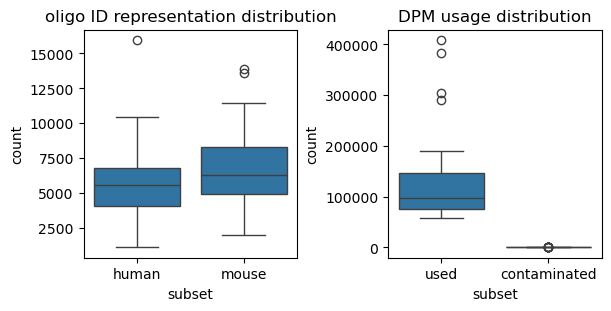

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=False, constrained_layout=True)
sns.boxplot(df_bpm_dpm.loc[mask_bpm], x='subset', y='count', ax=axs[0])
axs[0].set_title('oligo ID representation distribution')
sns.boxplot(df_bpm_dpm.loc[mask_dpm], x='subset', y='count', ax=axs[1])
axs[1].set_title('DPM usage distribution')
fig.show()

# Oligo analysis

Objectives
- More accurate counts of cell oligos, and proportions of those oligos with intermediate and full structures
- Where the DPM tag gets ligated relative to the cell barcode
  - Plot: heatmap of DPM position, where y-axis is the last identified tag group, and x-axis is location of DPM from last identified tag
    - A random distribution of DPM locations from the last identified tag would suggest oligo shearing, whereas predominant DPM detection 7-8 bp from a R1-R3 tag would indicate low cell barcode tag ligation efficiency, leading to incomplete cell barcodes that still remain competent for end repair, dA-tailing, and DPM ligation.
- Specificity of cell barcodes for cells
  - Based on [split-pool distribution calculator](https://colab.research.google.com/drive/1UeDOI-bNvaCIkeO2eJeH4x2j4juVLqS1) for $24^4$ R1-R4 barcodes and 78K cells, ~79% of R1-R4 barcodes should uniquely identify a cell, even without using the oligo ID (i.e., the oligo ID should be the same for a given R1-R4 barcode)

Results
- Number of oligo reads likely in-between detection by 2+ oligo tags (293,275; 5.2% of all reads) and detection by BPM sequence (587,890; 10.5% of all reads). For subsequent analysis, we use the BPM count (587,890).
  - Number of fully barcoded oligo reads likely in-between a strict (35,159; 6.0% of oligo reads; corresponds to 14,823 unique molecules) and loose splitcode config (45,912; 7.8% of oligo reads; corresponds to 18,872 unique molecules)</span>
- DPM ligation position
  - The mode DPM ligation position is the desired, expected position on a fully barcoded cell oligo. However, this only constitutes a minority of all cell oligos, likely due to low ligation efficiencies during rounds R1-R4.
  - The remaining DPM ligation positions are distributed primarily around the ends of RX tags - either right after the unique sequence, or after the overhang.

## Counting cell oligos

Only look at read 1

Splitcode configs Google sheet: https://docs.google.com/spreadsheets/d/1RHsS4Xj-TgYHXvMYk4RHqGc-lxw2bKDLG9jXKqwNbW0

| Splitcode config | Detection count | Description |
| ---------------- | --------------- | ----------- |
| `cell_oligo_total_1` | 293,275 | 2 of oligo ID, R1Top, R2Top, R3Top in the correct absolute locations |
| `cell_oligo_total_2` | 125,173 | oligo ID, R1Top, and R2Top in the correct relative locations |
| `cell_oligo_total_3` | 95,714 | LigEven, LigR1, and LigR2 in the correct absolute locations |
| `cell_oligo_total_4` | 96,027 | LigEven, LigR1, and LigR2 in the correct relative locations |
| `cell_oligo_total_5` | 496,585 | oligo ID, 8 bp UMI, LigEven in the correct absolute locations |

Detection of oligo ID in these splitcode configs allow 1 substitution.

Compare with 587,890 read 1 reads starting with perfectly matched 9 bp BPM.

#### Option 1

In [26]:
path_config_cell_oligo_total_1 = os.path.join(DIR_AUX, 'splitcode_config-cell_oligo_total_1.tsv')
path_out_cell_oligo_total_1 = os.path.join(DIR_PROC, 'oligos_cell-oligo-total_1.txt.gz')

In [27]:
%%bash -s {DIR_DATA} {DIR_PROC} {path_config_cell_oligo_total_1} {path_config_bpm_dpm} {PATH_R1_combined}
DIR_DATA="$1"
DIR_PROC="$2"
PATH_CONFIG1="$3"
PATH_CONFIG2="$4"
PATH_R1="$5"

PATH_MAPPING="$DIR_PROC/mapping_cell-oligo-total_1.tsv"
PATH_OUT="$DIR_PROC/oligos_cell-oligo-total_1.txt.gz"

splitcode -c "$PATH_CONFIG1" \
    --nFastqs=1 --assign --mod-names --no-outb -t 8 \
    --mapping="$PATH_MAPPING" --pipe \
    "$PATH_R1" |
splitcode -c "$PATH_CONFIG2" \
    --nFastqs=1 --mod-names --no-outb --out-fasta -t 8 \
    --pipe - |
grep -E -e '^>' |
grep -o -E -e '::.*' |
sed 's/^:://' |
gzip > "$PATH_OUT"

In [28]:
count_cell_oligo_total_1 = !cut -f 3 "{DIR_PROC}/mapping_cell-oligo-total_1.tsv"
count_cell_oligo_total_1 = sum(map(int, count_cell_oligo_total_1))
print('Number of oligos detected:', count_cell_oligo_total_1)

Number of oligos detected: 293275


Parse counts of detected structures

In [29]:
df_mapping_cell_oligo_total_1 = pd.read_csv(
    os.path.join(DIR_PROC, 'mapping_cell-oligo-total_1.tsv'),
    sep='\t',
    header=None,
    usecols=[1, 2],
    names=['structure', 'count']
)
df_mapping_cell_oligo_total_1['n_tags_detected'] = df_mapping_cell_oligo_total_1['structure'].str.count(',') + 1
df_mapping_cell_oligo_total_1['oligo ID'] = df_mapping_cell_oligo_total_1['structure'].str.contains('human|mouse')
df_mapping_cell_oligo_total_1['R1'] = df_mapping_cell_oligo_total_1['structure'].str.contains('R1Top')
df_mapping_cell_oligo_total_1['R2'] = df_mapping_cell_oligo_total_1['structure'].str.contains('R2Top')
df_mapping_cell_oligo_total_1['R3'] = df_mapping_cell_oligo_total_1['structure'].str.contains('R3Top')

bid_efficiency = {}
for tag_group in ('oligo ID', 'R1', 'R2', 'R3'):
    bid_efficiency[tag_group] = \
        df_mapping_cell_oligo_total_1.loc[df_mapping_cell_oligo_total_1[tag_group].values, 'count'].sum() / \
        df_mapping_cell_oligo_total_1['count'].sum()
bid_efficiency

{'oligo ID': 0.9952774699514108,
 'R1': 0.9727627653226494,
 'R2': 0.4325701133748189,
 'R3': 0.34093598158724747}

In [30]:
(
    df_mapping_cell_oligo_total_1
    .groupby(['oligo ID', 'R1', 'R2', 'R3'])['count'].sum()
    .reset_index()
    .sort_values('count', ascending=False)
    .pipe(lambda df: df.assign(prop=df['count'] / df['count'].sum()))
).head(4)

,oligo ID,R1,R2,R3,count,prop
7,True,True,False,False,155939,0.531716
10,True,True,True,True,88386,0.301376
9,True,True,True,False,36706,0.125159
4,True,False,False,True,7431,0.025338


Compute detection rate by number of tags detected

In [31]:
detection_rate_cell_oligo_total_1 = df_mapping_cell_oligo_total_1.groupby('n_tags_detected')['count'].sum().sort_index(ascending=False)
detection_rate_cell_oligo_total_1 = detection_rate_cell_oligo_total_1.to_frame()
detection_rate_cell_oligo_total_1['prop'] = detection_rate_cell_oligo_total_1['count'] / detection_rate_cell_oligo_total_1['count'].sum()
detection_rate_cell_oligo_total_1['cumsum'] = detection_rate_cell_oligo_total_1['count'].cumsum()
detection_rate_cell_oligo_total_1['cumprop'] = detection_rate_cell_oligo_total_1['prop'].cumsum()
detection_rate_cell_oligo_total_1['cumulative proportion of total reads'] = detection_rate_cell_oligo_total_1['cumsum'] / n_reads_total
detection_rate_cell_oligo_total_1

,count,prop,cumsum,cumprop,cumulative proportion of total reads
n_tags_detected,,,,,
4,88386,0.301376,88386,0.301376,0.015794
3,40705,0.138795,129091,0.440170,0.023068
2,164184,0.559830,293275,1.000000,0.052406


In [32]:
print('Detection rate for 3+ "tags" relative to perfect BPM matching:', detection_rate_cell_oligo_total_1.loc[3, 'cumsum'] / count_bpm)
print('Detection rate for 2+ "tags" relative to perfect BPM matching:', detection_rate_cell_oligo_total_1.loc[2, 'cumsum'] / count_bpm)

Detection rate for 3+ "tags" relative to perfect BPM matching: 0.21958359557059995
Detection rate for 2+ "tags" relative to perfect BPM matching: 0.4988603310143054


Interestingly, there are more reads with 4 tags detected than with 3 tags detected.

In [33]:
df_bpm_dpm_by_n_tags = []
with gzip.open(path_out_cell_oligo_total_1, 'rt') as f:
    for i, line in enumerate(f):
        line = line.strip()
        structure, bpm_dpm = line.split('::')
        n_tags = structure.count(']')
        bpm_dpm = bpm_dpm.strip('[]')
        if len(bpm_dpm) == 0:
            bpm_dpm = 'none'
        elif bpm_dpm.startswith('human') or bpm_dpm.startswith('mouse'):
            bpm_dpm = 'bpm'
        elif bpm_dpm.startswith('DPM'):
            bpm_dpm = 'DPM'
        else:
            raise ValueError
        df_bpm_dpm_by_n_tags.append((n_tags, bpm_dpm))
df_bpm_dpm_by_n_tags = pd.DataFrame(df_bpm_dpm_by_n_tags, columns=['n_tags', 'bpm_dpm'])

In [34]:
(
    df_bpm_dpm_by_n_tags
    .groupby(['n_tags', 'bpm_dpm'])
    .size()
    .rename('count')
    .reset_index()
    .pivot(index='n_tags', columns='bpm_dpm', values='count')
    .fillna(0)
    .astype('int')
    .pipe(lambda df: df.assign(prop_bpm=df['bpm'] / df.sum(axis=1, skipna=True)))
)

bpm_dpm,DPM,bpm,none,prop_bpm
n_tags,,,,
2,94,157396,6694,0.958656
3,92,38375,2238,0.942759
4,0,85864,2522,0.971466


Of sequences with 2+ matched tags, >94% have a perfect BPM sequence, and a neglible proportion have a perfect DPM sequence, suggesting the following interpretation:
- Using 2+ tags for oligo detection is sufficiently specific to distinguish oligos from DPM (chromatin) reads.
  - The majority of these oligos with 2+ tags only have identifiable oligo ID and R1. Why so few tags have 3+ or 4+ tags suggests low ligation efficiency, or shearing of the oligos during sonication.
- Very few DPM-starting sequences match 2+ oligo tags

Therefore, the true number (and proportion) of oligo reads is likely in between detection by 2+ oligo tags (293275; 5.2%) and detection by BPM sequence (587890; 10.5%).

### Option 2

In [37]:
path_config_cell_oligo_total_2 = os.path.join(DIR_AUX, 'splitcode_config-cell_oligo_total_2.tsv')

In [38]:
%%bash -s {DIR_DATA} {DIR_PROC} {path_config_cell_oligo_total_2} {PATH_R1_combined}
DIR_DATA="$1"
DIR_PROC="$2"
PATH_CONFIG="$3"
PATH_R1="$4"

PATH_MAPPING="$DIR_PROC/mapping_cell-oligo-total_2.tsv"

splitcode -c "$PATH_CONFIG" \
    --nFastqs=1 --assign --no-outb --no-output -t 8 \
    --mapping="$PATH_MAPPING" \
    "$PATH_R1"

* Using a list of 144 tags (vector size: 144; map size: 1,408,944; num elements in map: 1,455,021)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data_proc/20240625/R1.fastq.gz
* processing the reads ...
done 
* processed 5,596,174 reads, 125,173 reads were assigned


In [39]:
count_cell_oligo_total_2 = !cut -f 3 "{DIR_PROC}/mapping_cell-oligo-total_2.tsv"
count_cell_oligo_total_2 = int(count_cell_oligo_total_2[0])
print('Number of oligos detected:', count_cell_oligo_total_2)

Number of oligos detected: 125173


The number of reads detected enforcing relative locations of oligo ID, R1Top, and R2Top (125173) is lower than enforcing absolution locations of at least 3 of oligo ID, R1Top, R2Top, and R3Top (129091).

### Option 3

In [40]:
path_config_cell_oligo_total_3 = os.path.join(DIR_AUX, 'splitcode_config-cell_oligo_total_3.tsv')

In [41]:
%%bash -s {DIR_DATA} {DIR_PROC} {path_config_cell_oligo_total_3} {PATH_R1_combined}
DIR_DATA="$1"
DIR_PROC="$2"
PATH_CONFIG="$3"
PATH_R1="$4"

PATH_MAPPING="$DIR_PROC/mapping_cell-oligo-total_3.tsv"

splitcode -c "$PATH_CONFIG" \
    --nFastqs=1 --assign --no-outb --no-output -t 8 \
    --mapping="$PATH_MAPPING" \
    "$PATH_R1"

* Using a list of 3 tags (vector size: 3; map size: 342; num elements in map: 360)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data_proc/20240625/R1.fastq.gz
* processing the reads ...
done 
* processed 5,596,174 reads, 95,714 reads were assigned


In [42]:
count_cell_oligo_total_3 = !cut -f 3 "{DIR_PROC}/mapping_cell-oligo-total_3.tsv"
count_cell_oligo_total_3 = int(count_cell_oligo_total_3[0])
print('Number of oligos detected:', count_cell_oligo_total_3)

Number of oligos detected: 95714


### Option 4

In [44]:
path_config_cell_oligo_total_4 = os.path.join(DIR_AUX, 'splitcode_config-cell_oligo_total_4.tsv')

In [45]:
%%bash -s {DIR_DATA} {DIR_PROC} {path_config_cell_oligo_total_4} {PATH_R1_combined}
DIR_DATA="$1"
DIR_PROC="$2"
PATH_CONFIG="$3"
PATH_R1="$4"

PATH_MAPPING="$DIR_PROC/mapping_cell-oligo-total_4.tsv"

splitcode -c "$PATH_CONFIG" \
    --nFastqs=1 --assign --no-outb --no-output -t 8 \
    --mapping="$PATH_MAPPING" \
    "$PATH_R1"

* Using a list of 3 tags (vector size: 3; map size: 342; num elements in map: 360)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data_proc/20240625/R1.fastq.gz
* processing the reads ...
done 
* processed 5,596,174 reads, 96,027 reads were assigned


In [46]:
count_cell_oligo_total_4 = !cut -f 3 "{DIR_PROC}/mapping_cell-oligo-total_4.tsv"
count_cell_oligo_total_4 = int(count_cell_oligo_total_4[0])
print('Number of oligos detected:', count_cell_oligo_total_4)

Number of oligos detected: 96027


### Option 5

In [47]:
path_config_cell_oligo_total_5 = os.path.join(DIR_AUX, 'splitcode_config-cell_oligo_total_5.tsv')

In [48]:
%%bash -s {DIR_DATA} {DIR_PROC} {path_config_cell_oligo_total_5} {PATH_R1_combined}
DIR_DATA="$1"
DIR_PROC="$2"
PATH_CONFIG="$3"
PATH_R1="$4"

PATH_MAPPING="$DIR_PROC/mapping_cell-oligo-total_5.tsv"

if [ ! -f "$PATH_MAPPING" ]; then
    splitcode -c "$PATH_CONFIG" \
        --nFastqs=1 --assign --no-outb --no-output -t 8 \
        --mapping="$PATH_MAPPING" \
        "$PATH_R1"
fi

* Using a list of 97 tags (vector size: 97; map size: 3,581; num elements in map: 3,581)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data_proc/20240625/R1.fastq.gz
* processing the reads ...
done 
* processed 5,596,174 reads, 496,585 reads were assigned


In [49]:
count_cell_oligo_total_5 = !cut -f 3 "{DIR_PROC}/mapping_cell-oligo-total_5.tsv"
count_cell_oligo_total_5 = int(count_cell_oligo_total_5[0])
print('Number of oligos detected:', count_cell_oligo_total_5)

Number of oligos detected: 496585


## Full oligo barcodes

### Strict
- Read 1: oligo ID + 8 bp UMI + LigEven + R1Top + R2Top + R3Top (partial)
- Read 2: DPM common sequence + R4Bot + R3Bot (matching read 1 R3Top)

Counts summary

| Metric | Number of reads | Number of unique molecules | Notes |
| ------ | --------------- | -------------------------- | ----- |
| Fully barcoded oligos (with R3Bot matching R3Top) | 35159 | 14823 | |
| Fully barcoded oligos with R3Bot not matching R3Top | 12 | 8-10 | 10 barcodes had mismatched R3 tags, 2 of which had 2 reads. I did not bother to check if those reads had different UMIs. |
| Estimated true complexity of fully barcoded cell oligos | -- | 16954 | Simple Poisson estimate |

In [50]:
path_config_cell_barcode_strict = os.path.join(DIR_AUX, 'splitcode_config-cell_barcode_strict.tsv')

In [51]:
%%bash -s {DIR_DATA} {DIR_PROC} {path_config_cell_barcode_strict} {PATH_R1_combined} {PATH_R2_combined}
DIR_DATA="$1"
DIR_PROC="$2"
PATH_CONFIG="$3"
PATH_R1="$4"
PATH_R2="$5"

PATH_MAPPING="$DIR_PROC/mapping_cell-barcode-strict.tsv"
PATH_OUT="$DIR_PROC/oligos_cell-barcode-strict.txt.gz"

if [ ! -f "$PATH_OUT" ]; then
    splitcode -c "$PATH_CONFIG" \
        --nFastqs=2 --assign --com-names --x-names --no-x-out --no-outb --out-fasta -t 8 \
        --mapping="$PATH_MAPPING" --select=0 --pipe \
        "$PATH_R1" "$PATH_R2" |
    grep -E -e '^>' |
    grep -o -E -e ' .*' |
    sed -E -e 's/^\s+//' |
    gzip > "$PATH_OUT"
    
    gzip -f "$PATH_MAPPING"
fi

In [52]:
regex_cell_barcode_strict = (
    '(?P<oligo_ID>[^,]+),'
    'R1Top_(?P<R1>\d+),'
    'R2Top_(?P<R2>\d+),'
    'R3Top_(?P<R3>\d+),'
    'R4Bot_(?P<R4>\d+),'
    'R3Bot_(?P<R3Bot>\d+)'
)
df_mapping_cell_barcode_strict = pd.read_csv(
    os.path.join(DIR_PROC, 'mapping_cell-barcode-strict.tsv.gz'),
    sep='\t',
    header=None,
    usecols=[1, 2],
    names=['structure', 'count']
)
df_mapping_cell_barcode_strict = pd.concat(
    (df_mapping_cell_barcode_strict,
     df_mapping_cell_barcode_strict['structure'].str.extract(regex_cell_barcode_strict)),
    axis=1
).astype({x: np.uint8 for x in ('R1', 'R2', 'R3', 'R4', 'R3Bot')})

In [53]:
mask_match_R3 = (df_mapping_cell_barcode_strict['R3'] == df_mapping_cell_barcode_strict['R3Bot'])
mismatched_cell_ids = set(df_mapping_cell_barcode_strict.index[~mask_match_R3])
print('Number of barcodes with mismatched read 1 and read 2 R3 tag: {} / {} = {:.2%}'.format(
    (~mask_match_R3).sum(),
    len(mask_match_R3),
    (~mask_match_R3).sum() / len(mask_match_R3)
))
print('Count of cell oligo reads with mismatched read 1 and read 2 R3 tag: {} / {} = {:.2%}'.format(
    df_mapping_cell_barcode_strict.loc[~mask_match_R3, 'count'].sum(),
    df_mapping_cell_barcode_strict['count'].sum(),
    df_mapping_cell_barcode_strict.loc[~mask_match_R3, 'count'].sum() / df_mapping_cell_barcode_strict['count'].sum()
))

Number of barcodes with mismatched read 1 and read 2 R3 tag: 10 / 12019 = 0.08%
Count of cell oligo reads with mismatched read 1 and read 2 R3 tag: 12 / 35171 = 0.03%


Deduplicate by UMI
- Given the low total count of cell oligo reads detected (19035), it seems highly unlikely that 2 of them arise from the same cell (i.e., share the same barcode) and share the same UMI (UMI space = $4^8$ = 65536).

In [54]:
p_collision = 1 - scipy.stats.binom.cdf(
    1,
    df_mapping_cell_barcode_strict['count'].max(),
    1/(4**8)
)
print('Maximum number of cell oligos reads with the same cell barcode:',
      df_mapping_cell_barcode_strict['count'].max())
print('Probability that 2 or more of those oligos have the same UMI:', p_collision)

Maximum number of cell oligos reads with the same cell barcode: 486
Probability that 2 or more of those oligos have the same UMI: 2.73055259955024e-05


In [55]:
counter_cell_id_umi = collections.Counter()
with gzip.open(os.path.join(DIR_PROC, 'oligos_cell-barcode-strict.txt.gz'), 'rt') as f:
    for line in f:
        cell_id, umi = line.strip().split('\t')
        cell_id = int(cell_id.split('BI:i:')[1])
        if cell_id in mismatched_cell_ids:
            continue
        umi = umi.split('RX:Z:')[1]
        counter_cell_id_umi[(cell_id, umi)] += 1
df_strict_cell_id_umi = pd.Series(counter_cell_id_umi).rename('count').to_frame().reset_index(names=['cell_id', 'umi'])

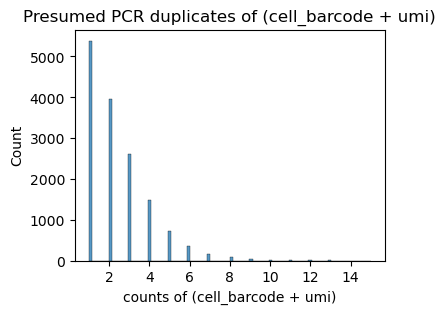

In [57]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(df_strict_cell_id_umi['count'], ax=ax)
ax.set(xlabel='counts of (cell_barcode + umi)', title='Presumed PCR duplicates of (cell_barcode + umi)')
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.figure.show()

The presence of several (cell_barcode + umi) with counts > 1 suggests that we are sequencing many PCR duplicates (as expected). However, this seems to indicate that true cell oligo complexity is extremely low.

In [64]:
print('Detected read count of fully barcoded cell oligo molecules with R3Bot matching R3Top:', df_strict_cell_id_umi['count'].sum())
print('Detected count of presumably unique cell oligo molecules (cell barcode + UMI):', len(df_strict_cell_id_umi))
print(
    'Estimated true complexity of unique cell oligo molecules:',
    int(estimate_library_complexity(
        df_strict_cell_id_umi['count'].sum(),
        len(df_strict_cell_id_umi)))
)
print(
    'Estimated true number of unique cell barcodes (i.e., estimated number of cells):',
    int(estimate_library_complexity(
        len(df_strict_cell_id_umi),
        len(df_strict_cell_id_umi['cell_id'].unique())))
)

Detected read count of fully barcoded cell oligo molecules with R3Bot matching R3Top: 35159
Detected count of presumably unique cell oligo molecules (cell barcode + UMI): 14823
Estimated true complexity of unique cell oligo molecules: 16954
Estimated true number of unique cell barcodes (i.e., estimated number of cells): 33925


In [65]:
df_mapping_cell_barcode_strict = (
    df_mapping_cell_barcode_strict
    .reset_index(names='cell_id')
    .merge(
        df_strict_cell_id_umi.groupby(['cell_id'])['count'].agg(count='sum', count_dedup=len).reset_index(),
        how='outer',
        on=['cell_id', 'count'],
        indicator=True
    )
)
assert df_mapping_cell_barcode_strict['_merge'].value_counts()['left_only'] == (~mask_match_R3).sum()
assert df_mapping_cell_barcode_strict['_merge'].value_counts()['right_only'] == 0

#### Specificity of cell barcodes for cells
- Distribution of number of oligo_IDs per R1-R4 barcode
- Distribution of maximally represented oligo_ID proportion per R1-R4 barcode
- Distribution of maximally represented oligo_ID species proportion per R1-R4 barcode.
- The first 2 distributions can be computed for leaving any one of the 5 "rounds" of cell barcoding out.

In [66]:
df_strict_cell_barcode_specificity = (
    df_mapping_cell_barcode_strict
    .assign(species=df_mapping_cell_barcode_strict['oligo_ID'].str[0:5])
    .loc[mask_match_R3]
    .groupby(['R1', 'R2', 'R3', 'R4'])
    .apply(
        lambda g: pd.Series({
            'n_oligo_IDs': len(g),
            'max_prop_oligo_IDs': g.sort_values('count_dedup', ascending=False)['count_dedup'].iloc[0] / g['count_dedup'].sum(),
            'max_prop_species': g.groupby('species')['count'].sum().pipe(lambda s: (s/s.sum()).max()),
            'count_dedup_total': g['count_dedup'].sum()
        }),
        include_groups=False
    )
    .astype(dict(n_oligo_IDs=int, count_dedup_total=int))
)

##### Number of oligo IDs per R1-R4 barcode

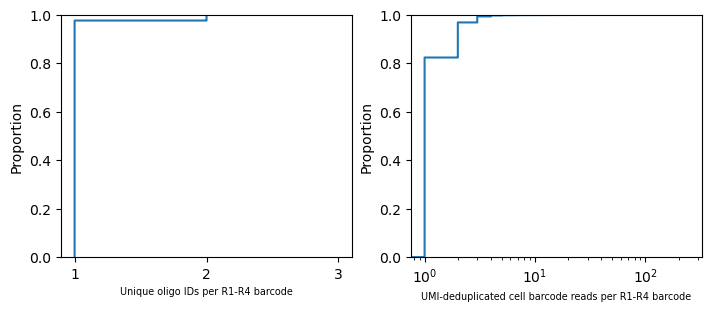

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3), constrained_layout=True)

sns.ecdfplot(df_strict_cell_barcode_specificity['n_oligo_IDs'], ax=axs[0])
axs[0].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
axs[0].set_xlabel('Unique oligo IDs per R1-R4 barcode', fontsize='x-small')

sns.ecdfplot(df_strict_cell_barcode_specificity['count_dedup_total'], ax=axs[1])
axs[1].set_xscale('log')
axs[1].set_xlabel('UMI-deduplicated cell barcode reads per R1-R4 barcode', fontsize='x-small')
fig.show()

At first glance, the metrics appear to indicate high specificity: >95% of R1-R4 barcodes are only associated with 1 unique oligo ID (left plot). However, most (>80%) R1-R4 barcodes are only associated with 1 read after UMI-deduplication (right plot). Consequently, it appears that the low read depth may be confounding the high specificity of R1-R4 barcodes. Consequently, we validate this result with the following analyses:
- Exclude barcodes with only 1 read when visualizing the distributions of maximally represented oligo_ID proportion and maximally represented oligo_ID species proportion.
- Simulate expected distributions

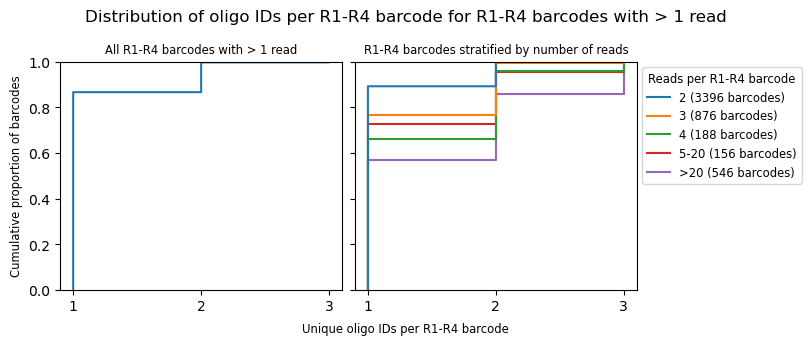

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True, sharex=True, sharey=True)
sns.ecdfplot(
    (
        df_strict_cell_barcode_specificity
        .loc[df_strict_cell_barcode_specificity['count_dedup_total'] > 1]
        .rename(columns={'n_oligo_IDs': 'Unique oligo IDs per R1-R4 barcode'})
    ),
    x='Unique oligo IDs per R1-R4 barcode',
    ax=axs[0]
)
axs[0].set_xlabel(None)
axs[0].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
axs[0].set_title('All R1-R4 barcodes with > 1 read', fontsize='small')
axs[0].set_ylabel('Cumulative proportion of barcodes', fontsize='small')

sns.ecdfplot(
    (
        df_strict_cell_barcode_specificity
        .assign(bins=df_strict_cell_barcode_specificity['count_dedup_total'].map(
          lambda c: np.nan if c < 2 else (str(c) if c < 5 else ('5-20' if c < 21 else '>20'))
        ))
        .pipe(lambda df: df.assign(bins=df['bins'].map(df.groupby('bins')['count_dedup_total'].sum().transform(lambda s: s.index + ' (' + s.astype(str) + ' barcodes)'))))
        .dropna(subset='bins')
        .astype(dict(bins='category'))
        .rename(columns={
            'bins': 'Reads per R1-R4 barcode',
            'n_oligo_IDs': 'Unique oligo IDs per R1-R4 barcode'
        })
    ),
    x='Unique oligo IDs per R1-R4 barcode',
    hue='Reads per R1-R4 barcode',
    ax=axs[1]
)
axs[1].set_xlabel(None)
sns.move_legend(
    axs[1],
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize='small',
    title_fontsize='small'
)
axs[1].set_title('R1-R4 barcodes stratified by number of reads', fontsize='small')

fig.suptitle(
    'Distribution of oligo IDs per R1-R4 barcode for R1-R4 barcodes with > 1 read',
    y=1.1
)
fig.supxlabel('Unique oligo IDs per R1-R4 barcode', fontsize='small')
fig.show()

The number of unique oligo IDs per R1-R4 barcode tends to increase with increasing reads per R1-R4 barcode. This makes sense: barcodes that are "assigned" to more cells (oligo IDs) are more prevalent in the library and will be sampled more frequently as reads. However, without more proper statistical analysis, it is not clear whether the number of unique oligo IDs per R1-R4 barcode increases more rapidly with increasing reads than expected.

Simulate expected distribution
- Ideally, we would have some generative distribution of unique oligo IDs per R1-R4 barcode at arbitrary read depths parameterized by number of cells and extent of mixing. Formally, let $X_i$ and $Y_i$ be the observed number of oligo IDs and reads associated with R1-R4 barcode $i$. We would like to have a likelihood distribution $P(X_i = x_i, Y_i = y_i \mid \theta, n, m, k)$ for the following parameters:
  - $\theta$: probability of mixing - i.e., that a barcode molecule originally associated with one cell is instead associated with a different cell - this is the key parameter we are interested in.
  - $n$: number of cells
  - $m$: number of barcodes
  - $k$: number of reads
  
  Then, given the data, we could perform statistical inference to estimate $\theta$ (and ideally $n$ and $m$ as well).
- The eCDF on the left above is precisely the data distribution $\hat{f}(X_i)$. One of the plots below gives the data distribution $\hat{f}(Y_i)$.

In [69]:
def simulate_barcode_counts(n, m, k, theta, trials, seed=None, full=False):
    '''
    Simulate selecting k reads from n cells barcoded by m possible barcodes (with replacement).

    Args
    - n: int
        number of cells
    - m: int
        number of possible unique barcodes
    - k: int
        number of cells (reads) to sample with replacement
    - theta: float
        probability of mixing - i.e., that a barcode molecule originally associated with one cell
        is instead associated with a different cell
    - trials: int
        number of simulations to perform
    - full: bool. default=False
        Return a large, detailed DataFrame where each row corresponds to a barcode from a particular trial.
        If False (default), return an aggregated DataFrame. See below.

    Returns: pd.DataFrame
    - If full=False:
        Columns
          - read count: int
          - cell count: int
          - number of barcodes: int
          - trial: int
        Each row gives the number of barcodes with `read count` observed reads from
          `cell count` cells in trial `trial`
    - If full=True:
        Columns
          - read count: int
          - cell count: int
          - max_oligo_prop: float
          - max_species_prop: float
          - trial: int
        Each row corresponds to a barcode from a particular trial.
        To convert a "full" output to an aggregated output:
        df.groupby(['read count', 'cell count', 'trial']).size().rename('number of barcodes').reset_index()
    '''
    rng = np.random.default_rng(seed)
    df = []
    for trial in tqdm(range(trials)):

        # cell_barcodes[i] is the barcode ID of cell i, i = 1,...,n
        cell_barcodes = rng.choice(m, size=n)

        # barcode_to_cells[barcode] is a list of cells with that barcode
        # the number of barcodes is l1 < min(m, n)
        barcode_to_cells = collections.defaultdict(list)
        for i, barcode in enumerate(cell_barcodes):
            barcode_to_cells[barcode].append(i)

        # barcodes_detected[j] is the barcode of read j, j = 1,...,k
        barcodes_detected = rng.choice(cell_barcodes, size=k)

        # barcodes_detected_unique is an array of length l2 < l1 of unique barcodes detected
        # barcodes_detected_counts[p] is the number of reads with barcode barcodes_detected_unique[p]
        barcodes_detected_unique, barcodes_detected_counts = np.unique(barcodes_detected, return_counts=True)

        if full:
            for barcode, read_count in zip(barcodes_detected_unique, barcodes_detected_counts):
                potential_cells = barcode_to_cells[barcode]
                cells_detected = rng.choice(potential_cells, size=read_count)
                n_mixes = rng.binomial(n=read_count, p=theta)
                if n_mixes > 0:
                    cells_detected[:n_mixes] = rng.choice(n, size=n_mixes)

                cells_detected_unique, cells_detected_counts = np.unique(cells_detected, return_counts=True)
                cell_count = len(cells_detected_unique)
                max_oligo_prop = cells_detected_counts.max() / read_count
                max_species_prop = (cells_detected >= (n / 2)).mean()
                max_species_prop = max(max_species_prop, 1 - max_species_prop)
                df.append((read_count, cell_count, max_oligo_prop, max_species_prop, trial))
        else:
            # counter[(r, c)] gives the number of barcodes with r observed reads from c cells
            counter = collections.Counter()
            for barcode, read_count in zip(barcodes_detected_unique, barcodes_detected_counts):
                potential_cells = barcode_to_cells[barcode]
                cells_detected = rng.choice(potential_cells, size=read_count)
                n_mixes = rng.binomial(n=read_count, p=theta)
                if n_mixes > 0:
                    cells_detected[:n_mixes] = rng.choice(n, size=n_mixes)
                cell_count = len(np.unique(cells_detected))
                counter[(read_count, cell_count)] += 1
            df.append(
                pd.Series(counter, name='number of barcodes')
                .to_frame()
                .reset_index(names=['read count', 'cell count'])
                .assign(trial=trial)
            )
    if full:
        df = pd.DataFrame(df, columns=('read count', 'cell count', 'max_oligo_prop', 'max_species_prop', 'trial'))
    else:
        df = pd.concat(df, axis=0, ignore_index=True)
    return df


def counts_to_mat(df_barcode_counts, max_read_count, max_cell_count):
    '''
    Convert table of read counts into a matrix

    Args
    - df_barcode_counts: pd.DataFrame, dtype=int
        Columns = read count, cell count, number of barcodes
    - max_read_count: int
        Maximum read count at and above which to group into a single category
    - max_cell_count: int
        Maximum cell count at and above which to group into a single category 

    Returns
    - mat: np.array, shape=(max_read_count, max_cell_count), dtype=int
      - Rows represent read count: 1, 2, ..., max_read_count - 1, max_read_count+
      - Columns represent cell count: 1, 2, ..., max_cell_count - 1, max_cell_count+
      - mat[r, c] represents the number of barcodes with r + 1 reads from c + 1 cells

    Usage
    - For a given read count (row), the eCDF is
      ecdf = np.cumsum(mat[r, :]) / mat[r, :].sum()
    - To plot this eCDF with matplotlib.pyplot:
      plt.stairs(
        ecdf,
        edges=list(range(1, max_cell_count + 1)) + [max_cell_count],
        baseline=np.append(np.zeros(max_cell_count), [np.nan])
      )
    '''
    mat = np.zeros((max_read_count, max_cell_count), dtype=int)
    for _, row in df_barcode_counts.iterrows():
        mat[
            min(row['read count'], max_read_count) - 1,
            min(row['cell count'], max_cell_count) - 1
        ] += row['number of barcodes']
    return mat


def counts_to_ecdf(df_simulated_barcode_counts, max_read_count=6, max_cell_count=5):
    '''
    Args
    - df_simulated_barcode_counts: pd.DataFrame
        Table as returned by simulate_barcode_counts()
    - max_read_count: int
        Maximum read count at and above which to group into a single category
    - max_cell_count: int
        Maximum cell count at and above which to group into a single category

    Returns
    - df_ecdfs: pd.DataFrame
      - Columns: cell count (int)
      - Index: trial (int), read count (str)
      - Values (float): for a given trial and read count, the cumulative proportion of barcodes
          by the number of originating cells
    '''
    df_ecdfs = []
    index = range(1, max_cell_count + 1)
    for trial, group in df_simulated_barcode_counts.groupby('trial'):
        result = []
        mat = counts_to_mat(group, max_read_count=6, max_cell_count=5)

        # compute total eCDF of cell count
        total_counts = mat.sum(axis=0)
        with np.errstate(divide='raise', invalid='raise'):
            ecdf = np.cumsum(total_counts) / total_counts.sum()
        result.append(pd.Series(ecdf, name='all reads', index=index))

        # compute eCDF for subsets of read counts
        for i in range(1, max_read_count):
            name = f'{i + 1} reads' if i < (max_read_count - 1) else f'{i + 1}+ reads'
            with np.errstate(divide='ignore', invalid='ignore'):
                ecdf = np.cumsum(mat[i, :]) / mat[i, :].sum()
            result.append(pd.Series(ecdf, name=name, index=index))

        df_ecdfs.append(pd.concat(result, axis=1).T.reset_index(names='read count').assign(trial=trial))

    df_ecdfs = (
        pd.concat(df_ecdfs, axis=0, ignore_index=True)
        .set_index(['trial', 'read count'])
        .rename_axis('cell count', axis=1)
    )

    return df_ecdfs


def ecdfs_to_confidence_intervals(df_ecdfs, percentiles=(5, 95)):
    '''
    Args
    - df_ecdfs: pd.DataFrame
      - Columns: cell count (int)
      - Index: trial (int), read count (str)
      - Values (float): for a given trial and read count, the cumulative proportion of barcodes
          by the number of originating cells
    - percentiles: 2-tuple of float. default=(5, 95)
        Lower and upper percentiles (values between 0 and 100) to use for confidence interval.

    Returns
    - upper: pd.DataFrame, shape=(max_read_count, max_cell_count)
      - Index: read count (str)
      - Columns: cell count (int)
      - Values: for a given read count and cell count, the percentiles[1]'th percentile of
          cumulative proportion of barcodes across all trials
    - lower: pd.DataFrame, shape=(max_read_count, max_cell_count)
        Analogous to `upper` but for the percentiles[0]'th percentile
    '''
    assert len(percentiles) == 2 and percentiles[1] >= percentiles[0]
    upper = (
        df_ecdfs
        .groupby(level='read count')
        .apply(lambda g: g.apply(np.nanpercentile, axis=0, raw=True, args=(percentiles[1],)))
    )
    lower = (
        df_ecdfs
        .groupby(level='read count')
        .apply(lambda g: g.apply(np.nanpercentile, axis=0, raw=True, args=(percentiles[0],)))
    )
    return upper, lower

In [72]:
# simulation parameters
m = 24**4 # number of barcodes
n = 78000 # number of cells
k = df_strict_cell_barcode_specificity['count_dedup_total'].sum() # number of deduplicated reads
trials = 1000
seed = 0

# visualization parameters
max_read_count = 6
max_cell_count = 5
percentiles = (5, 95)

# perform simulation with theta = 0
path_simulated_barcode_counts_strict = os.path.join(DIR_PROC, 'simulated_barcode_counts_strict_full.csv.gz')
if not os.path.exists(path_simulated_barcode_counts_strict) or reprocess:
    df_simulated_barcode_counts = simulate_barcode_counts(m, n, k, 0, trials, seed=0, full=True)
    df_simulated_barcode_counts.to_csv(path_simulated_barcode_counts_strict)
else:
    df_simulated_barcode_counts = pd.read_csv(path_simulated_barcode_counts_strict)

# perform simulation with theta = 0.5
path_simulated_barcode_counts_strict_mixed = os.path.join(DIR_PROC, 'simulated_barcode_counts_strict_full_mixed.csv.gz')
if not os.path.exists(path_simulated_barcode_counts_strict_mixed) or reprocess:
    df_simulated_barcode_counts_mixed = simulate_barcode_counts(m, n, k, 0.5, trials, seed=0, full=True)
    df_simulated_barcode_counts_mixed.to_csv(path_simulated_barcode_counts_strict_mixed)
else:
    df_simulated_barcode_counts_mixed = pd.read_csv(path_simulated_barcode_counts_strict_mixed)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [73]:
df_simulated_read_counts_ecdfs = (
    df_simulated_barcode_counts
    .groupby(['trial', 'read count'])
    .size()
    .rename('number of barcodes')
    .reset_index()
    .groupby('trial')
    .apply(
        lambda g: (
            g
            .sort_values('read count')
            .pipe(lambda df: df.assign(cum_prop=df['number of barcodes'].cumsum() / df['number of barcodes'].sum()))
        ),
        include_groups=False
    )
    .groupby('read count')['cum_prop']
    .agg(
        lower=lambda x: np.percentile(x, percentiles[0]),
        upper=lambda x: np.percentile(x, percentiles[1])
    )
)

df_simulated_read_counts_ecdfs_mixed = (
    df_simulated_barcode_counts_mixed
    .groupby(['trial', 'read count'])
    .size()
    .rename('number of barcodes')
    .reset_index()
    .groupby('trial')
    .apply(
        lambda g: (
            g
            .sort_values('read count')
            .pipe(lambda df: df.assign(cum_prop=df['number of barcodes'].cumsum() / df['number of barcodes'].sum()))
        ),
        include_groups=False
    )
    .groupby('read count')['cum_prop']
    .agg(
        lower=lambda x: np.percentile(x, percentiles[0]),
        upper=lambda x: np.percentile(x, percentiles[1])
    )
)

In [74]:
df_simulated_barcode_counts_summarized = (
    df_simulated_barcode_counts
    .groupby(['read count', 'cell count', 'trial'])
    .size()
    .rename('number of barcodes')
    .reset_index()
)

# wrangle data to form that can be visualized
df_simulated_barcode_counts_ecdfs = counts_to_ecdf(df_simulated_barcode_counts_summarized, max_read_count=max_read_count, max_cell_count=max_cell_count)
upper, lower = ecdfs_to_confidence_intervals(df_simulated_barcode_counts_ecdfs, percentiles=percentiles)

df_simulated_barcode_counts_summarized_mixed = (
    df_simulated_barcode_counts_mixed
    .groupby(['read count', 'cell count', 'trial'])
    .size()
    .rename('number of barcodes')
    .reset_index()
)

# wrangle data to form that can be visualized
df_simulated_barcode_counts_ecdfs_mixed = counts_to_ecdf(df_simulated_barcode_counts_summarized_mixed, max_read_count=max_read_count, max_cell_count=max_cell_count)
upper_mixed, lower_mixed = ecdfs_to_confidence_intervals(df_simulated_barcode_counts_ecdfs_mixed, percentiles=percentiles)

Validate simulation with different values of $\theta$
- Different values of $\theta$ should not affect read counts distribution
- Increased values of $\theta$ should increase number of cells (oligo IDs) associated with each barcode.
  - Result: the effect of $\theta=0.5$ on the distribution of number of oligo IDs per barcode is less dramatic than I would have thought.

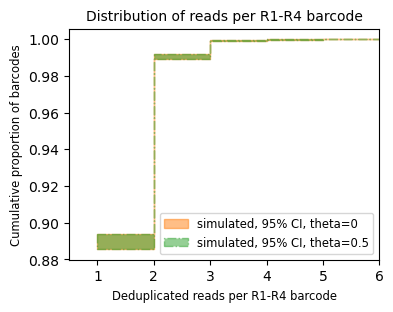

In [75]:
fig, ax = plt.subplots(figsize=(4, 3))
# sns.ecdfplot(df_strict_cell_barcode_specificity['count_dedup_total'], label='data', ax=ax)
# ax.set_xscale('log')
ax.fill_between(
    x=np.arange(1, df_simulated_read_counts_ecdfs.index.max() + 1),
    y1=df_simulated_read_counts_ecdfs['lower'],
    y2=df_simulated_read_counts_ecdfs['upper'],
    step='post',
    color='C1',
    alpha=0.5,
    label='simulated, 95% CI, theta=0'
)
ax.fill_between(
    x=np.arange(1, df_simulated_read_counts_ecdfs_mixed.index.max() + 1),
    y1=df_simulated_read_counts_ecdfs_mixed['lower'],
    y2=df_simulated_read_counts_ecdfs_mixed['upper'],
    step='post',
    color='C2',
    alpha=0.5,
    ls='-.',
    label='simulated, 95% CI, theta=0.5'
)
ax.set_xlabel('Deduplicated reads per R1-R4 barcode', fontsize='small')
ax.set_ylabel('Cumulative proportion of barcodes', fontsize='small')
ax.set_title('Distribution of reads per R1-R4 barcode', fontsize='medium')
ax.legend(fontsize='small')
ax.set_xlim(0.5, 6)
# ax.set_ylim(0.5, None)
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
fig.show()

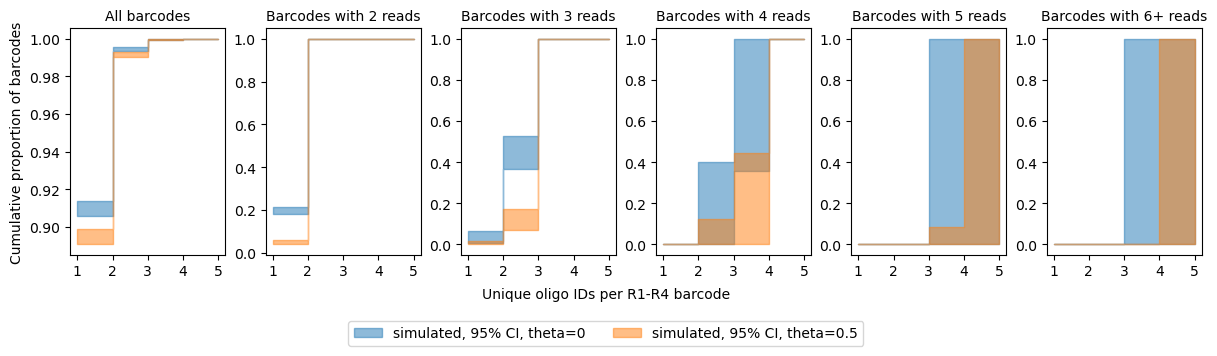

In [76]:
fig, axs = plt.subplots(1, max_read_count, figsize=(12, 3), constrained_layout=True, sharex=True)

# all reads
fill_object = axs[0].fill_between(
    x=np.arange(1, max_cell_count + 1),
    y1=upper.loc['all reads'],
    y2=lower.loc['all reads'],
    step='post',
    color='C0',
    alpha=0.5,
    label='simulated, 95% CI, theta=0'
)
fill_object2 = axs[0].fill_between(
    x=np.arange(1, max_cell_count + 1),
    y1=upper_mixed.loc['all reads'],
    y2=lower_mixed.loc['all reads'],
    step='post',
    color='C1',
    alpha=0.5,
    label='simulated, 95% CI, theta=0.5'
)
axs[0].set_ylabel('Cumulative proportion of barcodes', fontsize='medium')
axs[0].set_title('All barcodes', fontsize='medium')
# axs[0].set_ylim(0.9, 1.01)
axs[0].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

# read count values of 2 to max_read_count+
for read_count in range(2, max_read_count + 1):
    ax = axs[read_count - 1]
    read_count_idx = f'{read_count}{"+" if read_count == max_read_count else ""} reads'
    ax.fill_between(
        x=np.arange(1, max_cell_count + 1),
        y1=upper.loc[read_count_idx],
        y2=lower.loc[read_count_idx],
        step='post',
        color='C0',
        alpha=0.5,
        label='simulated, 95% CI, theta=0'
    )
    ax.fill_between(
        x=np.arange(1, max_cell_count + 1),
        y1=upper_mixed.loc[read_count_idx],
        y2=lower_mixed.loc[read_count_idx],
        step='post',
        color='C1',
        alpha=0.5,
        label='simulated, 95% CI, theta=0.5'
    )
    ax.set_title('Barcodes with ' + read_count_idx, fontsize='medium')

fig.supxlabel('Unique oligo IDs per R1-R4 barcode', fontsize='medium')

fig.legend(
    handles=[fill_object, fill_object2],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.03),
    ncols=2
)

fig.show()

For comparing confidence intervals from simulations to data, we use $\theta = 0$.

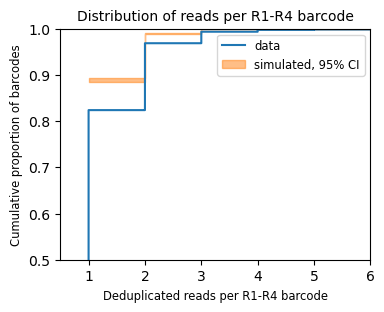

In [138]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.ecdfplot(df_strict_cell_barcode_specificity['count_dedup_total'], label='data', ax=ax)
# ax.set_xscale('log')
fill_object = ax.fill_between(
    x=np.arange(1, df_simulated_read_counts_ecdfs.index.max() + 1),
    y1=df_simulated_read_counts_ecdfs['lower'],
    y2=df_simulated_read_counts_ecdfs['upper'],
    step='post',
    color='C1',
    alpha=0.5,
    label='simulated, 95% CI'
)
ax.set_xlabel('Deduplicated reads per R1-R4 barcode', fontsize='small')
ax.set_ylabel('Cumulative proportion of barcodes', fontsize='small')
ax.set_title('Distribution of reads per R1-R4 barcode', fontsize='medium')
ax.legend(fontsize='small')
ax.set_xlim(0.5, 6)
ax.set_ylim(0.5, None)
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
fig.savefig(os.path.join(DIR_RESULTS, 'distribution_of_reads_per_R1-R4_barcode.png'), dpi=300, bbox_inches='tight')
fig.show()

More R1-R4 barcodes have > 1 read than expected by simulation, suggesting that the distribution of reads to barcodes is biased (not perfectly random). This probably reflects that clusters captured on protein G beads sometimes have more than 1 cell oligo (whether due to 2 separate labeling events, or multiple oligos conjugated per streptavidin), which would likely come from the same cell and therefore have the same barcode.

This distribution of reads per R1-R4 barcode is the marginal data distribution $\hat{f}(Y_i)$. The fact that we fail to accurately model the marginal distribution of $Y_i$ decreases our confidence in the accuracy of our model of $X_i$.

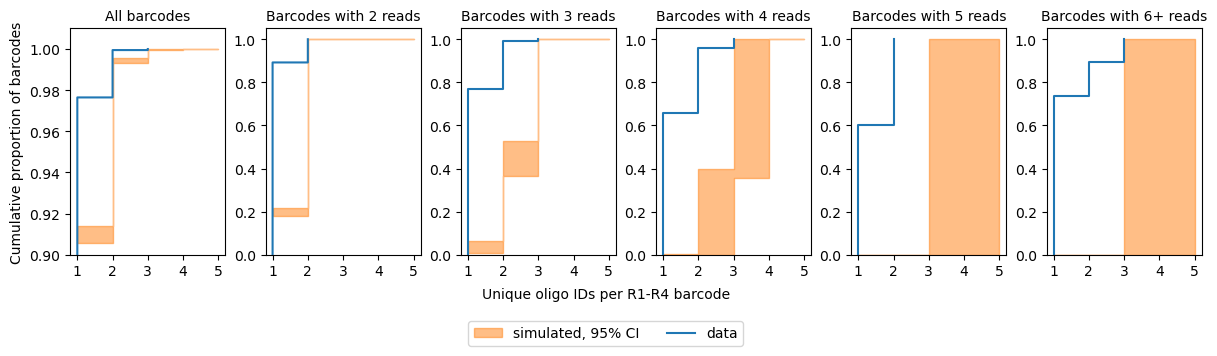

In [139]:
fig, axs = plt.subplots(1, max_read_count, figsize=(12, 3), constrained_layout=True, sharex=True)

# all reads
fill_object = axs[0].fill_between(
    x=np.arange(1, max_cell_count + 1),
    y1=upper.loc['all reads'],
    y2=lower.loc['all reads'],
    step='post',
    color='C1',
    alpha=0.5,
    label='simulated, 95% CI'
)
ecdf_object = axs[0].ecdf(df_strict_cell_barcode_specificity['n_oligo_IDs'], color='C0', label='data')
axs[0].set_ylabel('Cumulative proportion of barcodes', fontsize='medium')
axs[0].set_title('All barcodes', fontsize='medium')
axs[0].set_ylim(0.9, 1.01)
axs[0].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

# read count values of 2 to max_read_count+
for read_count in range(2, max_read_count + 1):
    ax = axs[read_count - 1]
    read_count_idx = f'{read_count}{"+" if read_count == max_read_count else ""} reads'
    ax.fill_between(
        x=np.arange(1, max_cell_count + 1),
        y1=upper.loc[read_count_idx],
        y2=lower.loc[read_count_idx],
        step='post',
        color='C1',
        alpha=0.5,
        label='simulated, 5th-95th percentile'
    )
    if read_count < max_read_count:
        mask_data = df_strict_cell_barcode_specificity['count_dedup_total'] == read_count
    else:
        mask_data = df_strict_cell_barcode_specificity['count_dedup_total'] >= read_count
    ax.ecdf(
        df_strict_cell_barcode_specificity.loc[mask_data, 'n_oligo_IDs'],
        color='C0',
        label='data'
    )
    ax.set_ylim(None, 1.05)
    ax.set_title('Barcodes with ' + read_count_idx, fontsize='medium')

fig.supxlabel('Unique oligo IDs per R1-R4 barcode', fontsize='medium')

fig.legend(
    handles=[fill_object, ecdf_object],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.03),
    ncols=2
)

fig.savefig(
    os.path.join(DIR_RESULTS, 'distribution_of_oligo_IDs_per_R1-R4_barcode.png'),
    dpi=300,
    bbox_inches='tight'
)
fig.show()

The observed data appears even more specific (i.e., fewer unique oligo IDs per R1-R4 barcode) than expected by simulation. However, a clear interpretation of this analysis is confounded by the biased distribution of reads to barcodes observed in the data.

##### Maximally represented oligo ID proportion per R1-R4 barcode

The above distributions of unique oligo IDs per R1-R4 barcode were discrete distributions, making confidence intervals of eCDFs easy to compute - percentiles need to be computed at each discrete value 1, 2, ..., 5. However, the distributions of maximally represented oligo ID / species proportion are continuous distributions.

In [79]:
df_simulated_max_oligo_ID_prop_ecdf_cis = []
subset_to_mask = {
    'all barcodes': np.array([True] * len(df_simulated_barcode_counts)),
    'barcodes with 2+ reads': df_simulated_barcode_counts['read count'] > 1,
    'barcodes with 2+ oligo IDs': df_simulated_barcode_counts['cell count'] > 1
}
for subset, mask in subset_to_mask.items():
    tmp = dict()
    for value in np.sort(df_simulated_barcode_counts['max_oligo_prop'].unique()):
        tmp[value] = (
            df_simulated_barcode_counts
            .loc[mask]
            .groupby('trial')
            ['max_oligo_prop']
            .agg(lambda x: (x <= value).mean())
            .quantile(np.array(percentiles) / 100)
        )
    df_simulated_max_oligo_ID_prop_ecdf_cis.append(
        pd.DataFrame(tmp)
        .T
        .rename(columns={percentiles[0] / 100: 'lower', percentiles[1] / 100: 'upper'})
        .reset_index(names='quantile')
        .assign(subset=subset)
    )
df_simulated_max_oligo_ID_prop_ecdf_cis = pd.concat(df_simulated_max_oligo_ID_prop_ecdf_cis, axis=0, ignore_index=True)

In [80]:
df_simulated_max_species_prop_ecdf_cis = []
subset_to_mask = {
    'all barcodes': np.array([True] * len(df_simulated_barcode_counts)),
    'barcodes with 2+ reads': df_simulated_barcode_counts['read count'] > 1,
    'barcodes with 2+ oligo IDs': df_simulated_barcode_counts['cell count'] > 1
}
for subset, mask in subset_to_mask.items():
    tmp = dict()
    for value in np.sort(df_simulated_barcode_counts['max_oligo_prop'].unique()):
        tmp[value] = (
            df_simulated_barcode_counts
            .loc[mask]
            .groupby('trial')
            ['max_species_prop']
            .agg(lambda x: (x <= value).mean())
            .quantile(np.array(percentiles) / 100)
        )
    df_simulated_max_species_prop_ecdf_cis.append(
        pd.DataFrame(tmp)
        .T
        .rename(columns={percentiles[0] / 100: 'lower', percentiles[1] / 100: 'upper'})
        .reset_index(names='quantile')
        .assign(subset=subset)
    )
df_simulated_max_species_prop_ecdf_cis = pd.concat(df_simulated_max_species_prop_ecdf_cis, axis=0, ignore_index=True)

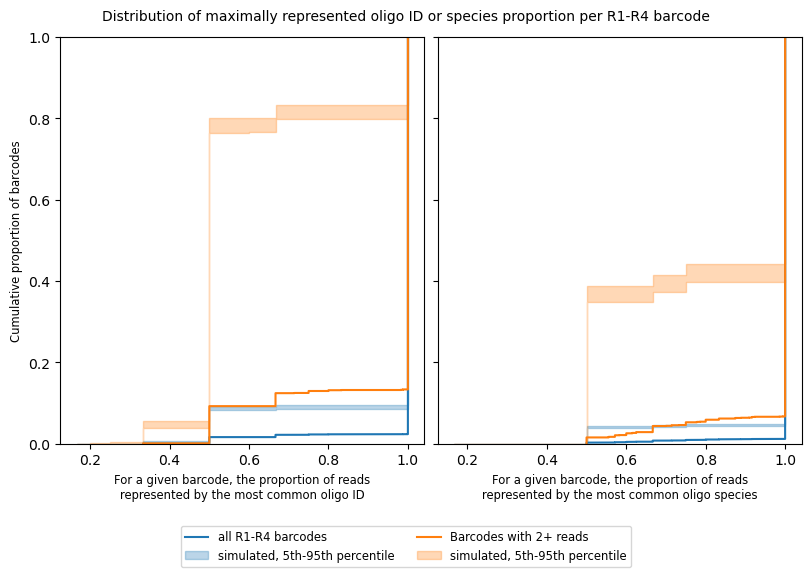

In [140]:
fig, axs = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True, sharex=False, sharey=True)

# subplot 1: maximally represented oligo ID proportion per R1-R4 barcode
handles = []
h = axs[0].ecdf(
    df_strict_cell_barcode_specificity['max_prop_oligo_IDs'],
    label='all R1-R4 barcodes'
)
handles.append(h)
mask = df_simulated_max_oligo_ID_prop_ecdf_cis['subset'] == 'all barcodes'
h = axs[0].fill_between(
    df_simulated_max_oligo_ID_prop_ecdf_cis.loc[mask, 'quantile'],
    df_simulated_max_oligo_ID_prop_ecdf_cis.loc[mask, 'lower'],
    df_simulated_max_oligo_ID_prop_ecdf_cis.loc[mask, 'upper'],
    step='post',
    color='C0',
    alpha=0.3,
    label='simulated, 5th-95th percentile'
)
handles.append(h)
h = axs[0].ecdf(
    df_strict_cell_barcode_specificity.loc[df_strict_cell_barcode_specificity['count_dedup_total'] > 1, 'max_prop_oligo_IDs'],
    label='Barcodes with 2+ reads'
)
handles.append(h)
mask = df_simulated_max_oligo_ID_prop_ecdf_cis['subset'] == 'barcodes with 2+ reads'
h = axs[0].fill_between(
    df_simulated_max_oligo_ID_prop_ecdf_cis.loc[mask, 'quantile'],
    df_simulated_max_oligo_ID_prop_ecdf_cis.loc[mask, 'lower'],
    df_simulated_max_oligo_ID_prop_ecdf_cis.loc[mask, 'upper'],
    step='post',
    color='C1',
    alpha=0.3,
    label='simulated, 5th-95th percentile'
)
handles.append(h)
axs[0].set_xlabel(
    '\n'.join((
        'For a given barcode, the proportion of reads',
        'represented by the most common oligo ID')),
    fontsize='small'
)
axs[0].set_ylabel('Cumulative proportion of barcodes', fontsize='small')

# subplot 2: maximally represented oligo species proportion per R1-R4 barcode
axs[1].ecdf(
    df_strict_cell_barcode_specificity['max_prop_species'],
    label='all R1-R4 barcodes'
)
mask = df_simulated_max_species_prop_ecdf_cis['subset'] == 'all barcodes'
axs[1].fill_between(
    df_simulated_max_species_prop_ecdf_cis.loc[mask, 'quantile'],
    df_simulated_max_species_prop_ecdf_cis.loc[mask, 'lower'],
    df_simulated_max_species_prop_ecdf_cis.loc[mask, 'upper'],
    step='post',
    color='C0',
    alpha=0.3,
    label='simulated, 5th-95th percentile'
)
axs[1].ecdf(
    df_strict_cell_barcode_specificity.loc[df_strict_cell_barcode_specificity['count_dedup_total'] > 1, 'max_prop_species'],
    label='Barcodes with 2+ reads'
)
mask = df_simulated_max_species_prop_ecdf_cis['subset'] == 'barcodes with 2+ reads'
axs[1].fill_between(
    df_simulated_max_species_prop_ecdf_cis.loc[mask, 'quantile'],
    df_simulated_max_species_prop_ecdf_cis.loc[mask, 'lower'],
    df_simulated_max_species_prop_ecdf_cis.loc[mask, 'upper'],
    step='post',
    color='C1',
    alpha=0.3,
    label='simulated, 5th-95th percentile'
)
axs[1].set_xlabel(
    '\n'.join((
        'For a given barcode, the proportion of reads',
        'represented by the most common oligo species')),
    fontsize='small'
)

fig.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.03),
    ncols=2,
    fontsize='small'
)
fig.suptitle(
    'Distribution of maximally represented oligo ID or species proportion per R1-R4 barcode',
    fontsize='medium'
)
fig.savefig(
    os.path.join(DIR_RESULTS, 'distribution_of_maximally_represented_oligo_ID_or_species_proportion_per_R1-R4_barcode.png'),
    dpi=300,
    bbox_inches='tight'
)
fig.show()

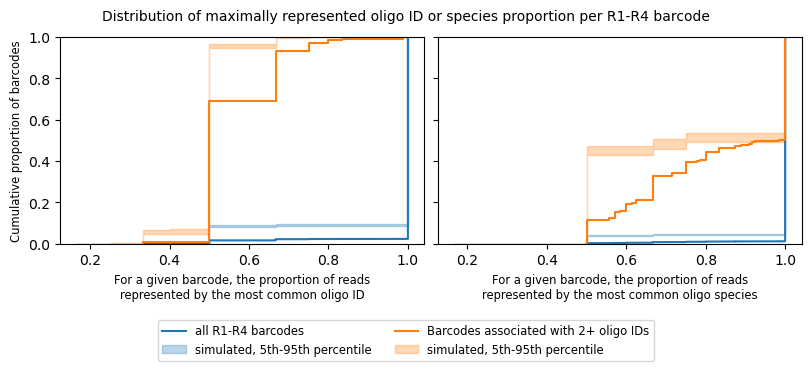

In [141]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True, sharex=False, sharey=True)
handles = []

# subplot 1: maximally represented oligo ID proportion per R1-R4 barcode
h = axs[0].ecdf(
    df_strict_cell_barcode_specificity['max_prop_oligo_IDs'],
    label='all R1-R4 barcodes'
)
handles.append(h)
mask = df_simulated_max_oligo_ID_prop_ecdf_cis['subset'] == 'all barcodes'
h = axs[0].fill_between(
    df_simulated_max_oligo_ID_prop_ecdf_cis.loc[mask, 'quantile'],
    df_simulated_max_oligo_ID_prop_ecdf_cis.loc[mask, 'lower'],
    df_simulated_max_oligo_ID_prop_ecdf_cis.loc[mask, 'upper'],
    step='post',
    color='C0',
    alpha=0.3,
    label='simulated, 5th-95th percentile'
)
handles.append(h)
h = axs[0].ecdf(
    df_strict_cell_barcode_specificity.loc[df_strict_cell_barcode_specificity['n_oligo_IDs'] > 1, 'max_prop_oligo_IDs'],
    label='Barcodes associated with 2+ oligo IDs'
)
handles.append(h)
mask = df_simulated_max_oligo_ID_prop_ecdf_cis['subset'] == 'barcodes with 2+ oligo IDs'
h = axs[0].fill_between(
    df_simulated_max_oligo_ID_prop_ecdf_cis.loc[mask, 'quantile'],
    df_simulated_max_oligo_ID_prop_ecdf_cis.loc[mask, 'lower'],
    df_simulated_max_oligo_ID_prop_ecdf_cis.loc[mask, 'upper'],
    step='post',
    color='C1',
    alpha=0.3,
    label='simulated, 5th-95th percentile'
)
handles.append(h)
axs[0].set_xlabel(
    '\n'.join((
        'For a given barcode, the proportion of reads',
        'represented by the most common oligo ID')),
    fontsize='small'
)
axs[0].set_ylabel('Cumulative proportion of barcodes', fontsize='small')

# subplot 2: maximally represented oligo species proportion per R1-R4 barcode
axs[1].ecdf(
    df_strict_cell_barcode_specificity['max_prop_species'],
    label='all R1-R4 barcodes'
)
mask = df_simulated_max_species_prop_ecdf_cis['subset'] == 'all barcodes'
axs[1].fill_between(
    df_simulated_max_species_prop_ecdf_cis.loc[mask, 'quantile'],
    df_simulated_max_species_prop_ecdf_cis.loc[mask, 'lower'],
    df_simulated_max_species_prop_ecdf_cis.loc[mask, 'upper'],
    step='post',
    color='C0',
    alpha=0.3,
    label='simulated, 5th-95th percentile'
)
axs[1].ecdf(
    df_strict_cell_barcode_specificity.loc[df_strict_cell_barcode_specificity['n_oligo_IDs'] > 1, 'max_prop_species'],
    label='Barcodes associated with 2+ oligo IDs'
)
mask = df_simulated_max_species_prop_ecdf_cis['subset'] == 'barcodes with 2+ oligo IDs'
axs[1].fill_between(
    df_simulated_max_species_prop_ecdf_cis.loc[mask, 'quantile'],
    df_simulated_max_species_prop_ecdf_cis.loc[mask, 'lower'],
    df_simulated_max_species_prop_ecdf_cis.loc[mask, 'upper'],
    step='post',
    color='C1',
    alpha=0.3,
    label='simulated, 5th-95th percentile'
)
axs[1].set_xlabel(
    '\n'.join((
        'For a given barcode, the proportion of reads',
        'represented by the most common oligo species')),
    fontsize='small'
)

fig.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.03),
    ncols=2,
    fontsize='small'
)
fig.suptitle(
    'Distribution of maximally represented oligo ID or species proportion per R1-R4 barcode',
    fontsize='medium'
)
fig.savefig(
    os.path.join(DIR_RESULTS, 'distribution_of_maximally_represented_oligo_ID_or_species_proportion_per_R1-R4_barcode2.png'),
    dpi=300,
    bbox_inches='tight'
)
fig.show()

Again, the observed data appears even more specific (i.e., higher proportion of molecules with each R1-R4 barcode are represented by the most common oligo ID and species) than expected by simulation. However, a clear interpretation of this analysis is confounded by the biased distribution of reads to barcodes observed in the data.

### Loose

R3 can be found in either read 1 or read 2; if found in both, must match
- Read 1: oligo ID + 8 bp UMI + LigEven + R1Top + R2Top + (optional) R3Top (partial)
- Read 2: (optional) R3Top + R4Top, in reverse-complemenet of read 2
  - Scanning the reverse-complement of read 2 from left to right is presumably less likely to erroneously (false positive) recognize an odd/even/DPM sequence as an R4 sequence

Splitcode config notes
- If an R3 tag is detected 2+ times, the 2nd detection (and any additional detections) is almost certainly from read 2.
  - This is because any detection on read 1 is constrained by the `previous` column that requires an immediate previous detection of R2Top.
  - No conclusion can be drawn about the first detection of R3, which can occur on either read 1 or read 2.

Counts summary

| Metric | Number of reads | Number of unique molecules | Notes |
| ------ | --------------- | -------------------------- | ----- |
| Fully barcoded oligos (assigned by splitcode) | 46352 | 19077 | |
| Fully barcoded oligos (R3 detected 2 times) | 44407 | 17845 | |
| Fully barcoded oligos (R3 detected 2 times, mismatched) | 18| 17 | |
| Fully barcoded oligos (not expected structure) | 440 | 205 | e.g., detection of 3+ instances of an R3 tag or 2+ instances of an R4 tag |
| Fully barcoded oligos (expected structure) | 45912 | 18872 | if 2 instances of R3 tags detected, filtered for reads where those 2 instances match |
| Estimated true complexity of fully barcoded cell oligos (expected structure) | | 21362 | |

In [83]:
path_config_cell_barcode_loose = os.path.join(DIR_AUX, 'splitcode_config-cell_barcode_loose.tsv')

In [84]:
%%bash -s {DIR_DATA} {DIR_PROC} {path_config_cell_barcode_loose} {PATH_R1_combined} {PATH_R2_combined}
DIR_DATA="$1"
DIR_PROC="$2"
PATH_CONFIG="$3"
PATH_R1="$4"
PATH_R2="$5"

PATH_MAPPING="$DIR_PROC/mapping_cell-barcode-loose.tsv"
PATH_OUT="$DIR_PROC/oligos_cell-barcode-loose.txt.gz"

if [ ! -f "$PATH_OUT" ]; then
    splitcode -c "$PATH_CONFIG" \
        --nFastqs=2 --assign --com-names --x-names --no-x-out --no-outb --out-fasta -t 8 \
        --mapping="$PATH_MAPPING" --select=0 --pipe \
        "$PATH_R1" <(seqtk seq -r "$PATH_R2") |
    grep -E -e '^>' |
    grep -o -E -e ' .*' |
    sed -E -e 's/^\s+//' |
    gzip > "$PATH_OUT"
    
    gzip -f "$PATH_MAPPING"
fi

In [85]:
regex_cell_barcode_loose = (
    '(?P<oligo_ID>[^,]+),'
    'R1Top_(?P<R1>\d+),'
    'R2Top_(?P<R2>\d+),'
    '(?:R3Top_(?P<R3>\d+)),'
    '(?:R3Top_(?P<R3_2>\d+),)?'
    'R4Top_(?P<R4>\d+)$'
)
df_mapping_cell_barcode_loose = pd.read_csv(
    os.path.join(DIR_PROC, 'mapping_cell-barcode-loose.tsv.gz'),
    sep='\t',
    header=None,
    usecols=[1, 2],
    names=['structure', 'count']
)
df_mapping_cell_barcode_loose = (
    pd.concat(
        (df_mapping_cell_barcode_loose,
         df_mapping_cell_barcode_loose['structure'].str.extract(regex_cell_barcode_loose)),
        axis=1
    )
    .astype({x: 'Int64' for x in ('R1', 'R2', 'R3', 'R3_2', 'R4')})
    .pipe(lambda df: df.assign(cell_id=range(len(df))))
)

In [86]:
counter_cell_id_umi = collections.Counter()
with gzip.open(os.path.join(DIR_PROC, 'oligos_cell-barcode-loose.txt.gz'), 'rt') as f:
    for line in f:
        cell_id, umi = line.strip().split('\t')
        cell_id = int(cell_id.split('BI:i:')[1])
        umi = umi.split('RX:Z:')[1]
        counter_cell_id_umi[(cell_id, umi)] += 1
df_loose_cell_id_umi = pd.Series(counter_cell_id_umi).rename('count').to_frame().reset_index(names=['cell_id', 'umi'])

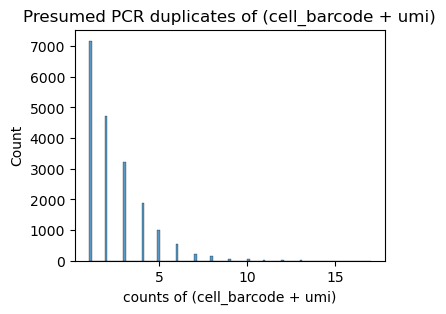

In [87]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(df_loose_cell_id_umi['count'], ax=ax)
ax.set(xlabel='counts of (cell_barcode + umi)', title='Presumed PCR duplicates of (cell_barcode + umi)')
ax.figure.show()

The presence of several (cell_barcode + umi) with counts > 1 suggests that we are sequencing many PCR duplicates (as expected). However, this seems to indicate that true cell oligo complexity is extremely low.

In [90]:
print(
    'Detected count of presumably unique cell oligo molecules (cell barcode + UMI):',
    len(df_loose_cell_id_umi)
)
print(
    'Estimated true complexity of unique cell oligo molecules:',
    int(estimate_library_complexity(
        df_loose_cell_id_umi['count'].sum(),
        len(df_loose_cell_id_umi)))
)
print(
    'Estimated true number of unique cell barcodes (i.e., estimated number of cells):',
    int(estimate_library_complexity(
        len(df_loose_cell_id_umi),
        len(df_loose_cell_id_umi['cell_id'].unique()),
    ))
)

Detected count of presumably unique cell oligo molecules (cell barcode + UMI): 19077
Estimated true complexity of unique cell oligo molecules: 21605
Estimated true number of unique cell barcodes (i.e., estimated number of cells): 39661


In [91]:
df_mapping_cell_barcode_loose = (
    df_mapping_cell_barcode_loose
    .merge(
        df_loose_cell_id_umi.groupby(['cell_id'])['count'].agg(count='sum', count_dedup=len).reset_index(),
        how='outer',
        on=['cell_id', 'count'],
        indicator=True
    )
)
assert (df_mapping_cell_barcode_loose['_merge'] == 'both').all()

In [92]:
print('Counts = reads, unique molecules.')
print('Fully barcoded cell oligos assigned by splitcode: {}, {}'.format(
    df_mapping_cell_barcode_loose['count'].sum(),
    df_mapping_cell_barcode_loose['count_dedup'].sum()
))
mask_expected_structure = (
    (~df_mapping_cell_barcode_loose['R4'].isna()) & 
    (df_mapping_cell_barcode_loose['R3_2'].isna() | (df_mapping_cell_barcode_loose['R3'] == df_mapping_cell_barcode_loose['R3_2']))
)
print('Fully barcoded cell oligos with expected structure: {}, {}'.format(
    df_mapping_cell_barcode_loose.loc[mask_expected_structure, 'count'].sum(),
    df_mapping_cell_barcode_loose.loc[mask_expected_structure, 'count_dedup'].sum()
))
print('Fully barcoded cell oligos without expected structure: {}, {}'.format(
    df_mapping_cell_barcode_loose.loc[~mask_expected_structure, 'count'].sum(),
    df_mapping_cell_barcode_loose.loc[~mask_expected_structure, 'count_dedup'].sum()
))
print('Fully barcoded cell oligos with 2 detections of R3 tag: {}, {}'.format(
    df_mapping_cell_barcode_loose.loc[~df_mapping_cell_barcode_loose['R3_2'].isna(), 'count'].sum(),
    df_mapping_cell_barcode_loose.loc[~df_mapping_cell_barcode_loose['R3_2'].isna(), 'count_dedup'].sum()
))
mask_R3_mismatch = (
    (~df_mapping_cell_barcode_loose['R3_2'].isna()) &
    (df_mapping_cell_barcode_loose['R3'] != df_mapping_cell_barcode_loose['R3_2'])
)
print('Fully barcoded cell oligos with 2 mismatched detections of R3 tag: {}, {}'.format(
    df_mapping_cell_barcode_loose.loc[mask_R3_mismatch, 'count'].sum(),
    df_mapping_cell_barcode_loose.loc[mask_R3_mismatch, 'count_dedup'].sum()
))
print('Estimated true complexity of fully barcoded cell oligos (expected structure):',
      int(estimate_library_complexity(
          df_mapping_cell_barcode_loose.loc[mask_expected_structure, 'count'].sum(),
          df_mapping_cell_barcode_loose.loc[mask_expected_structure, 'count_dedup'].sum()))
)
print(
    'Estimated true number of unique fully barcoded cell barcodes of expected structure (i.e., estimated number of cells):',
    int(estimate_library_complexity(
        df_mapping_cell_barcode_loose.loc[mask_expected_structure, 'count_dedup'].sum(),
        len(df_mapping_cell_barcode_loose.loc[mask_expected_structure, 'structure'].unique())))
)

Counts = reads, unique molecules.
Fully barcoded cell oligos assigned by splitcode: 46352, 19077
Fully barcoded cell oligos with expected structure: 45912, 18872
Fully barcoded cell oligos without expected structure: 440, 205
Fully barcoded cell oligos with 2 detections of R3 tag: 44407, 17845
Fully barcoded cell oligos with 2 mismatched detections of R3 tag: 18, 17
Estimated true complexity of fully barcoded cell oligos (expected structure): 21362
Estimated true number of unique fully barcoded cell barcodes of expected structure (i.e., estimated number of cells): 38926


## DPM position relative to cell barcode

Objectives
- Where the DPM tag gets ligated relative to the cell barcode?
  - If DPM is ligated at unexpected positions, is it biased towards particular subsequences or specific tags?
  - What proportion of DPM tag is ligated at different positions?
    - Expected positions: DPM ligated 7-8 bp from a R1-R3 tag unique sequence
    - Unexpected positions

### DPM detection from read 1

#### Splitcode config 1
- Oligo detection: loose - only oligo ID
- DPM detection: moderate (9 bp DPMTop unique sequence + 7 bp DPMTop common sequence) from position 10 (1-indexed; after oligo ID) onward
  - (Tried, data not shown) Requiring a stricter form of DPM detection (9 bp DPMTop unique sequence + 16 bp DPMTop common sequence) does not noticeably change the shape of the histogram below.

In [94]:
path_config_cell_oligo_DPM_1 = os.path.join(DIR_AUX, 'splitcode_config-cell_oligo_DPM_positioning_1.tsv')

In [103]:
%%bash -s {DIR_DATA} {DIR_PROC} {path_config_cell_oligo_DPM_1} {PATH_R1_combined} {reprocess}
DIR_DATA="$1"
DIR_PROC="$2"
PATH_CONFIG="$3"
PATH_R1="$4"
reprocess="$5"

PATH_OUT="$DIR_PROC/oligos_DPM-positioning-1.csv"

if [ ! -f "$PATH_OUT" ] || [ "$reprocess" = True ]; then
    splitcode -c "$PATH_CONFIG" \
        --nFastqs=1 --assign --loc-names --no-outb --out-fasta -t 8 \
        --mapping=/dev/null --pipe \
        "$PATH_R1" |
    grep -E -e '^>' |
    grep -o -E -e 'DPMTop6_[0-9]+:0,[0-9]+-[0-9]+,DPMTop_common.*' |
    sed -E -e 's/[^:]+:0,([0-9]+)-.*DPMTop_common.*/\1/' |
    sort -n |
    uniq -c |
    awk '{print $2","$1}' > "$PATH_OUT"
fi

# the splitcode config allows for DPMTop6_([0-9])+ to be detected multiple times -->
# the grep pattern 'DPMTop6_[0-9]+:0,[0-9]+-[0-9]+.*' ensures that only the first detection of DPMTop6 is used for analysis

In [143]:
dpm_position_counts = pd.read_csv(os.path.join(DIR_PROC, 'oligos_DPM-positioning-1.csv'), names=['DPM_position', 'count'])

In [144]:
print('Number of cell oligo reads with detectable DPM in read 1: {} ({:.1%} of all cell oligo reads)'.format(
    dpm_position_counts['count'].sum(),
    dpm_position_counts['count'].sum() / count_bpm
))

Number of cell oligo reads with detectable DPM in read 1: 170232 (29.0% of all cell oligo reads)


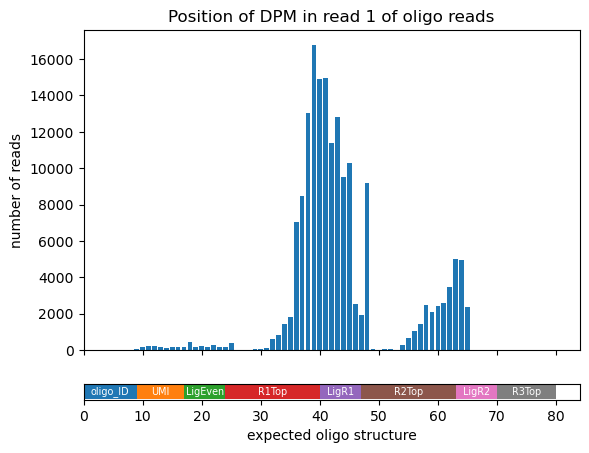

In [146]:
fig, axs = plt.subplots(2, 1, sharex=True, height_ratios=(2, 0.1))

expected_oligo_structure = {
    'oligo_ID': (0, 9),
    'UMI': (9, 17),
    'LigEven': (17, 24),
    'R1Top': (24, 40),
    'LigR1': (40, 47),
    'R2Top': (47, 63),
    'LigR2': (63, 70),
    'R3Top': (70, 80)
}

axs[0].bar(dpm_position_counts['DPM_position'], dpm_position_counts['count'], align='center', width=0.8)
axs[0].set_ylabel('number of reads')
axs[0].set_title('Position of DPM in read 1 of oligo reads')

for part, (start, end) in expected_oligo_structure.items():
    axs[1].barh(y=0, width=end-start, left=start)
    axs[1].text(x=(end+start)/2, y=0, s=part, fontsize='x-small', color='white', ha='center', va='center')
axs[1].yaxis.set_ticks([])
axs[1].set_xlabel('expected oligo structure')
fig.savefig(
    os.path.join(DIR_RESULTS, 'DPM_position_in_read1_of_oligo_loose.png'),
    dpi=300,
    bbox_inches='tight'
)
fig.show()

Interpretation
- If R2 failed to ligate R1 on the oligo, then I would expect the R1 tag (with its 5' R1 overhang on the bottom strand) to be end-repaired and dA-tailed such that the DPMTop sequence should start 1 bp after the end of LigR1. Indeed, we see a peak in DPMTop detection frequency at 1 bp just past LigR1.
- However, it is unclear why most DPMs (out of the ones detectable on read 1) are detected at the end of R1Top.
- The lack of a constant background frequency suggests that any background level of DPM ligation (e.g., from random fragmentation resulting in random DPM ligation positions) is low. Instead, there are clear biases towards certain positions. These biases may result from fragmentation bias, end repair bias, and most importantly, incomplete tag ligation.

#### Splitcode config 2
- Oligo detection: strict - oligo ID, UMI, and LigEven (total of 24 bp)
- DPM detection: moderate - (9 bp DPMTop unique sequence + 7 bp DPMTop common sequence) from position 25 (1-indexed) onward
  - (Data not shown) Using a strict DPM detection config (9 bp DPMTop unique sequence + 16 bp DPMTop common sequence) does not noticeably change results (see `splitcode_config-cell_oligo_DPM_positioning_1.2.tsv`)
- Unlike splitcode config 1, this splitcode config includes detection of R1, R2, and R3 tags, so we can see where DPM is ligated relative to these cell barcode tags.

In [107]:
path_config_cell_oligo_DPM_2 = os.path.join(DIR_AUX, 'splitcode_config-cell_oligo_DPM_positioning_2.tsv')

In [108]:
%%bash -s {DIR_DATA} {DIR_PROC} {path_config_cell_oligo_DPM_2} {PATH_R1_combined} {reprocess}
DIR_DATA="$1"
DIR_PROC="$2"
PATH_CONFIG="$3"
PATH_R1="$4"
reprocess="$5"

PATH_OUT="$DIR_PROC/oligos_DPM-positioning-2.tsv"

if [ ! -f "$PATH_OUT" ] || [ "$reprocess" = True ]; then
    splitcode -c "$PATH_CONFIG" \
        --nFastqs=1 --assign --loc-names --no-outb --no-x-out --x-names --out-fasta -t 8 \
        --mapping=/dev/null --pipe \
        "$PATH_R1" |
    grep -E -e '^>' |
    grep -o -E -e '[^:,]+:0,[0-9]+-[0-9]+,DPMTop6_[0-9]+:0,[0-9]+-[0-9]+,DPMTop_common.*' |
    sed -E -e 's/:0,([0-9]+)-([0-9]+)/:\1-\2/g' -e 's/-[0-9]+,DPMTop_common:\S+//' |
    sort -n |
    uniq -c |
    awk 'BEGIN {OFS="\t"} {print $2, $3, $1}' > "$PATH_OUT"
fi

In [147]:
dpm_position_counts = pd.read_csv(
    os.path.join(DIR_PROC, 'oligos_DPM-positioning-2.tsv'),
    sep='\t',
    names=['structure', 'pre_DPM_4bp', 'count']
)
dpm_position_counts['pre_DPM_4bp'] = dpm_position_counts['pre_DPM_4bp'].str.replace('RX:Z:', '')
regex_structure = (
    '(?P<previous_tag_type>[^:_]+)_?(?P<previous_tag_index>\d+)?:'
    '(?P<previous_tag_start>\d+)-'
    '(?P<previous_tag_end>\d+),DPMTop6_(?P<DPM_index>\d+):'
    '(?P<DPM_start>\d+)'
)
dpm_position_counts = pd.concat(
    (dpm_position_counts, dpm_position_counts['structure'].str.extract(regex_structure)),
    axis=1
).astype(dict(previous_tag_start=int, previous_tag_end=int, DPM_start=int))
dpm_position_counts['DPM distance from last tag'] = dpm_position_counts['DPM_start'] - dpm_position_counts['previous_tag_end']

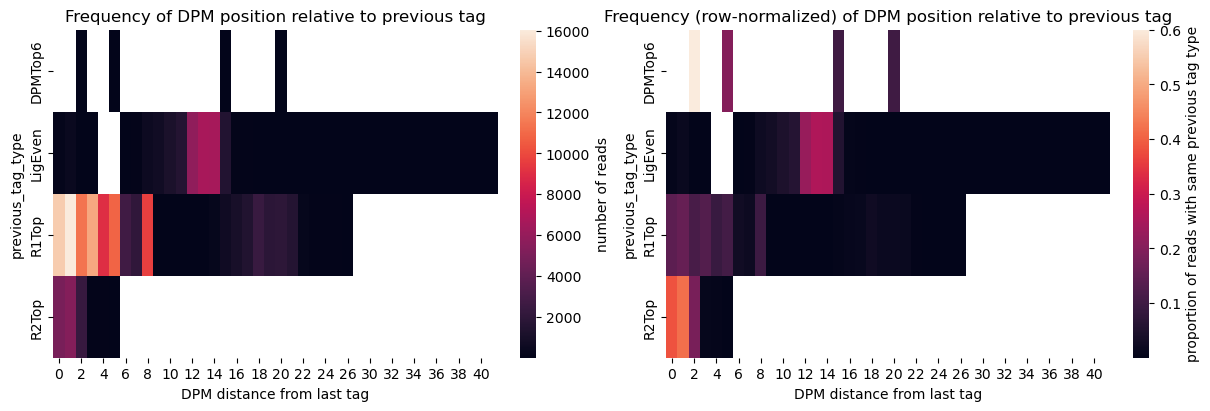

In [148]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
dpm_position_counts_by_previous_tag = (
    dpm_position_counts
    .groupby(['previous_tag_type', 'DPM distance from last tag'])
    ['count'].sum()
    .reset_index()
    .pivot(index='previous_tag_type', columns='DPM distance from last tag', values='count')
)
sns.heatmap(
    dpm_position_counts_by_previous_tag,
    cbar_kws=dict(label='number of reads'),
    ax=axs[0]
)
sns.heatmap(
    dpm_position_counts_by_previous_tag / np.nansum(dpm_position_counts_by_previous_tag.values, axis=1)[:, None],
    cbar_kws=dict(label='proportion of reads with same previous tag type'),
    ax=axs[1]
)
axs[0].set_title('Frequency of DPM position relative to previous tag')
axs[1].set_title('Frequency (row-normalized) of DPM position relative to previous tag')
fig.show()

In [149]:
print('Number of cell oligo reads with detectable DPM in read 1: {} ({:.1%} of all cell oligo reads)'.format(
    dpm_position_counts['count'].sum(),
    dpm_position_counts['count'].sum() / count_cell_oligo_total_5
))

Number of cell oligo reads with detectable DPM in read 1: 139721 (28.1% of all cell oligo reads)


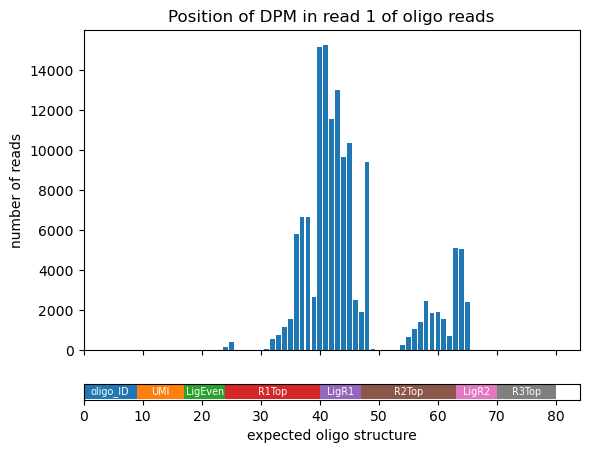

In [150]:
fig, axs = plt.subplots(2, 1, sharex=True, height_ratios=(2, 0.1))

expected_oligo_structure = {
    'oligo_ID': (0, 9),
    'UMI': (9, 17),
    'LigEven': (17, 24),
    'R1Top': (24, 40),
    'LigR1': (40, 47),
    'R2Top': (47, 63),
    'LigR2': (63, 70),
    'R3Top': (70, 80)
}

axs[0].bar(
    dpm_position_counts.groupby('DPM_start')['count'].sum().reset_index()['DPM_start'],
    dpm_position_counts.groupby('DPM_start')['count'].sum().reset_index()['count'],
    align='center',
    width=0.8
)
axs[0].set_ylabel('number of reads')
axs[0].set_title('Position of DPM in read 1 of oligo reads')

for part, (start, end) in expected_oligo_structure.items():
    axs[1].barh(y=0, width=end-start, left=start)
    axs[1].text(x=(end+start)/2, y=0, s=part, fontsize='x-small', color='white', ha='center', va='center')
axs[1].yaxis.set_ticks([])
axs[1].set_xlabel('expected oligo structure')
fig.savefig(
    os.path.join(DIR_RESULTS, 'DPM_position_in_read1_of_oligo_strict.png'),
    dpi=300,
    bbox_inches='tight'
)
fig.show()

Are early DPM ligations biased towards certain previous tags or certain DPM tags?
- There may be a tag-specific bias towards R1Top_20 (`CAAGTCACAGCTACGTGCATTCT`) and DPMTop6_21 (`AAGGCAAGT`)?
- There appears to be a bias towards top strand sequences ending in `T` or `C`, although this is confounded by the fact that the LigR1 overhang is almost exclusively `C`s and `T`s, except for a single base.
  - The most common 3 bp prefix preceding the DPM tag is `TCT`, which is an internal subsequence of the LigR1 overhang.
  - The 2nd most common 3 bp prefix preceding the DPM tag is `CGT`, which is the last 3 bp of the LigR1 overhang.
  - The 3rd most common 3 bp prefix preceding the DPM tag is `CTC`, which is an internal subsequence of the LigR1 overhang.

In [113]:
(
    dpm_position_counts
    .groupby(['previous_tag_type', 'previous_tag_index', 'DPM_index', 'DPM distance from last tag'])
    ['count'].sum()
    .reset_index()
    .sort_values('count', ascending=False)
).head(10)

,previous_tag_type,previous_tag_index,DPM_index,DPM distance from last tag,count
4722,R1Top,20,21,1,320
6722,R1Top,3,21,0,309
4724,R1Top,20,21,3,258
6569,R1Top,3,1,0,214
6936,R1Top,3,6,0,189
9065,R2Top,1,21,1,164
4558,R1Top,20,1,1,160
4725,R1Top,20,21,4,155
6856,R1Top,3,32,0,155
9309,R2Top,12,21,0,153


In [114]:
(
    dpm_position_counts
    .loc[dpm_position_counts['pre_DPM_4bp'].map(len) == 4]
    .groupby('pre_DPM_4bp')
    ['count'].sum()
    .sort_values(ascending=False)
    .head(10)
)

pre_DPM_4bp
TCTA    20459
CGTA    12497
CTCA    10583
TTCA     5480
CCTA     4015
ATTA     3704
GATA     3467
CTTA     3240
GCTA     3200
TACA     3137
Name: count, dtype: int64

In [115]:
(
    dpm_position_counts
    .loc[dpm_position_counts['pre_DPM_4bp'] == 'TCTA']
    .groupby(['previous_tag_type', 'DPM distance from last tag'])
    ['count'].sum()
    .reset_index()
    .sort_values('count', ascending=False)
    .head(8)
)

,previous_tag_type,DPM distance from last tag,count
20,R1Top,5,8375
18,R1Top,3,5970
16,R1Top,1,3040
15,R1Top,0,1013
19,R1Top,4,939
22,R1Top,7,438
21,R1Top,6,248
17,R1Top,2,129


In [116]:
(
    dpm_position_counts
    .loc[dpm_position_counts['pre_DPM_4bp'] == 'CGTA']
    .groupby(['previous_tag_type', 'DPM distance from last tag'])
    ['count'].sum()
    .reset_index()
    .sort_values('count', ascending=False)
    .head(8)
)

,previous_tag_type,DPM distance from last tag,count
16,R1Top,8,9514
8,R1Top,0,1346
15,R1Top,7,671
24,R1Top,20,288
0,LigEven,9,124
14,R1Top,6,116
1,LigEven,10,92
23,R1Top,19,82


In [117]:
(
    dpm_position_counts
    .loc[dpm_position_counts['pre_DPM_4bp'] == 'CTCA']
    .groupby(['previous_tag_type', 'DPM distance from last tag'])
    ['count'].sum()
    .reset_index()
    .sort_values('count', ascending=False)
    .head(8)
)

,previous_tag_type,DPM distance from last tag,count
21,R1Top,4,6834
23,R1Top,6,1313
19,R1Top,2,1152
22,R1Top,5,891
20,R1Top,3,216
6,LigEven,14,31
18,R1Top,1,31
27,R1Top,19,20


In [118]:
(
    dpm_position_counts
    .loc[dpm_position_counts['pre_DPM_4bp'] == 'ATTA']
    .groupby(['previous_tag_type', 'DPM distance from last tag'])
    ['count'].sum()
    .reset_index()
    .sort_values('count', ascending=False)
    .head(8)
)

,previous_tag_type,DPM distance from last tag,count
23,R2Top,1,1441
11,R1Top,0,900
4,LigEven,14,859
19,R1Top,19,104
3,LigEven,13,79
18,R1Top,18,76
2,LigEven,11,70
5,LigEven,15,68


Look for examples of reads with DPM detected in the following positions:
- 13 bp into R1Top unique sequence: [read 1](https://benchling.com/s/seq-h6H3JsXFcmMApTqyfKee), [read 2](https://benchling.com/s/seq-Ap0lS2R3hHDLmK55ajab)
- Immediately after R1Top: [read 1](https://benchling.com/s/seq-iQPml1cFJUv4geSpQWRh), [read2](https://benchling.com/s/seq-foXjNRon8Eh7fGVc5KQH)
- Midway through LigR1: [read 1](https://benchling.com/s/seq-Pw4kk3xPWwmX8RwIh4fg)
- Immediately after LigR1: [read 1](https://benchling.com/s/seq-xqjhLGt7v8mhZEwoU9yA)
- Midway through R2Top: [read 1](https://benchling.com/s/seq-NciLC1XQM94huB8A1Nzt)

In [119]:
%%bash -s {DIR_DATA} {DIR_PROC} {path_config_cell_oligo_DPM_2} {PATH_R1_combined} {reprocess}
DIR_DATA="$1"
DIR_PROC="$2"
PATH_CONFIG="$3"
PATH_R1="$4"
reprocess="$5"

PATH_OUT="$DIR_PROC/oligos_DPM-positioning-2.fasta.gz"

if [ ! -f "$PATH_OUT" ] || [ "$reprocess" = True ]; then
    splitcode -c "$PATH_CONFIG" \
        --nFastqs=1 --assign --loc-names --no-outb --no-x-out --out-fasta --gzip -t 8 \
        --mapping=/dev/null --output="$PATH_OUT" \
        "$PATH_R1"
fi

* Using a list of 266 tags (vector size: 266; map size: 1,633,407; num elements in map: 1,679,957)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data_proc/20240625/R1.fastq.gz
* processing the reads ...
done 
* processed 5,596,174 reads, 139,721 reads were assigned


Interpretation
- Increasing specificity of cell oligo detection and DPM detection does not significantly change DPM position distribution, suggesting that the distribution observed using splitcode config 1 above is real.
- Unclear why/how DPM gets ligated into unexpected positions - cannot distinguish between sonication of cell oligo vs. end processing enzyme activity.
  - Some apparent sequence-based biases for sequences ending in `C` and `T`.

### DPM detection from read 2

#### Splitcode config 3

- Oligo detection from read 1: strict - oligo ID, UMI, and LigEven (total of 24 bp)
- Use reverse complement of read 2
- DPM detection: strict - (9 bp DPMTop unique sequence + 7 bp DPMTop common sequence)

In [120]:
path_config_cell_oligo_DPM_3 = os.path.join(DIR_AUX, 'splitcode_config-cell_oligo_DPM_positioning_3.tsv')

In [121]:
%%bash -s {DIR_DATA} {DIR_PROC} {path_config_cell_oligo_DPM_3} {PATH_R1_combined} {PATH_R2_combined} {reprocess}
DIR_DATA="$1"
DIR_PROC="$2"
PATH_CONFIG="$3"
PATH_R1="$4"
PATH_R2="$5"
reprocess="$6"

PATH_OUT="$DIR_PROC/oligos_DPM-positioning-3.tsv.gz"

if [ ! -f "$PATH_OUT" ] || [ "$reprocess" = True ]; then
    splitcode -c "$PATH_CONFIG" \
        --nFastqs=2 --assign --loc-names --no-outb --no-x-out --x-names --out-fasta -t 8 \
        --mapping=/dev/null --select=0 --pipe \
        "$PATH_R1" <(seqtk seq -r "$PATH_R2") |
    grep -E -e '^>' |
    sed -E -e 's/>AV.*LX:Z:(mouse|human)_[0-9]+:0,0-9,LigEven:0,17-24,//' \
        -e 's/:1,([0-9]+)-([0-9]+)/:\1-\2/g' |
    gzip > "$PATH_OUT"
fi

In [151]:
dpm_positions = pd.read_csv(
    os.path.join(DIR_PROC, 'oligos_DPM-positioning-3.tsv.gz'),
    sep='\t',
    names=['structure', 'pre_DPM_4bp']
)
dpm_positions['pre_DPM_4bp'] = dpm_positions['pre_DPM_4bp'].str.replace('RX:Z:', '')
regex_structure = (
    '(?P<previous_tag_type>[^:_,]+)_?(?P<previous_tag_index>\d+)?:'
    '(?P<previous_tag_start>\d+)-'
    '(?P<previous_tag_end>\d+),DPMTop6_(?P<DPM_index>\d+):'
    '(?P<DPM_start>\d+)'
)
dpm_positions = pd.concat(
    (dpm_positions, dpm_positions['structure'].str.extract(regex_structure)),
    axis=1
).astype(dict(previous_tag_start='Int64', previous_tag_end='Int64', DPM_start='Int64'))
dpm_positions['DPM distance from last tag'] = dpm_positions['DPM_start'] - dpm_positions['previous_tag_end']
dpm_positions['DPM position'] = dpm_positions['previous_tag_type'].map(dict(
    R1Top=0,
    R2Top=23,
    R3Top=46,
    R4Top=69
)) + dpm_positions['DPM distance from last tag'] + 40

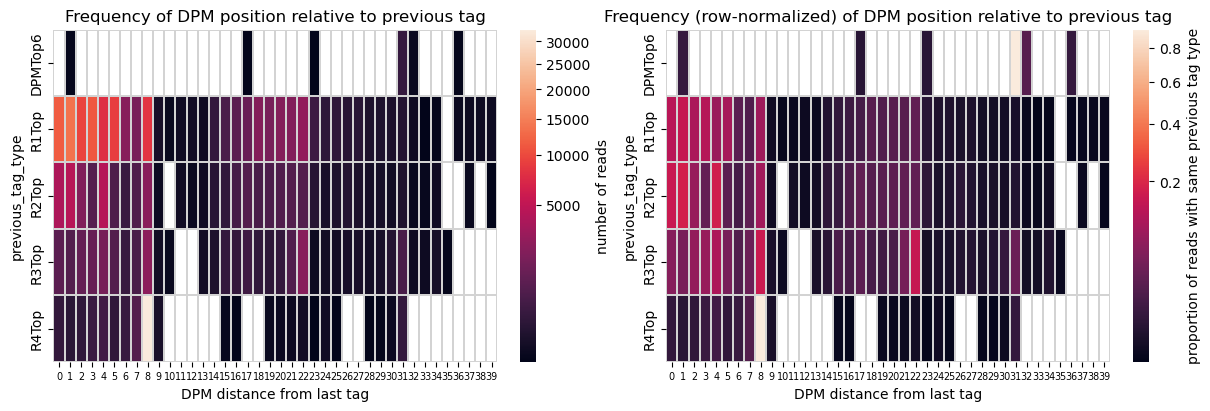

In [123]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
dpm_position_counts_by_previous_tag = (
    dpm_positions
    .groupby(['previous_tag_type', 'DPM distance from last tag'])
    .size()
    .rename('count')
    .reset_index()
    .pivot(index='previous_tag_type', columns='DPM distance from last tag', values='count')
)
sns.heatmap(
    dpm_position_counts_by_previous_tag,
    norm=matplotlib.colors.PowerNorm(0.4),
    linewidths=0.25,
    linecolor='lightgrey',
    cbar_kws=dict(label='number of reads'),
    ax=axs[0]
)
sns.heatmap(
    dpm_position_counts_by_previous_tag / np.nansum(dpm_position_counts_by_previous_tag.values, axis=1)[:, None],
    cbar_kws=dict(label='proportion of reads with same previous tag type'),
    norm=matplotlib.colors.PowerNorm(0.4),
    linewidths=0.01,
    linecolor='lightgrey',
    ax=axs[1]
)
for ax in axs.flatten():
    ax.set_xlim(0, 40)
    ax.set_xticks(
        np.arange(0.5, 40.5),
        labels=np.arange(40).astype(str),
        fontsize='x-small'
    )
axs[0].set_title('Frequency of DPM position relative to previous tag')
axs[1].set_title('Frequency (row-normalized) of DPM position relative to previous tag')
fig.show()

In [152]:
dpm_position_counts = (
    dpm_positions
    .groupby('DPM position')
    .size()
    .reset_index()
    .astype({'DPM position': int})
    .set_index('DPM position')
    .squeeze()
    .rename('count')
)

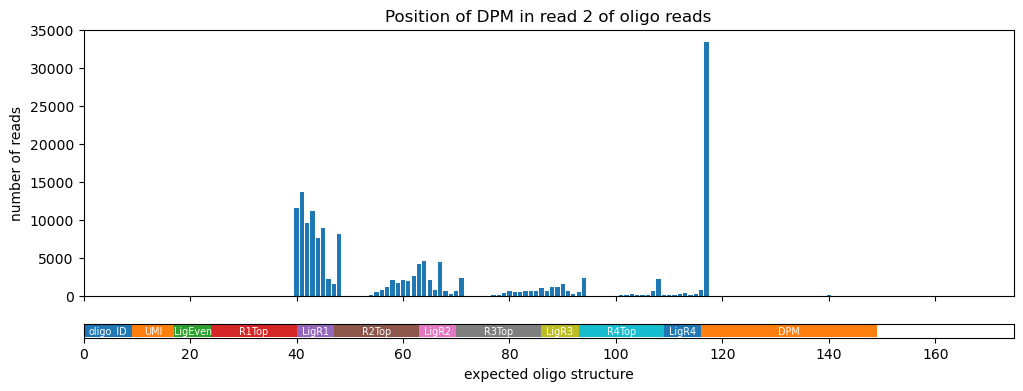

In [153]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 4), height_ratios=(2, 0.1))

expected_oligo_structure = {
    'oligo_ID': (0, 9),
    'UMI': (9, 17),
    'LigEven': (17, 24),
    'R1Top': (24, 40),
    'LigR1': (40, 47),
    'R2Top': (47, 63),
    'LigR2': (63, 70),
    'R3Top': (70, 86),
    'LigR3': (86, 93),
    'R4Top': (93, 109),
    'LigR4': (109, 116),
    'DPM': (116, 149)
}

axs[0].bar(
    dpm_position_counts.index,
    dpm_position_counts.values,
    align='center',
    width=0.8
)
axs[0].set_ylabel('number of reads')
axs[0].set_title('Position of DPM in read 2 of oligo reads')

for part, (start, end) in expected_oligo_structure.items():
    axs[1].barh(y=0, width=end-start, left=start)
    axs[1].text(x=(end+start)/2, y=0, s=part, fontsize='x-small', color='white', ha='center', va='center')
axs[1].yaxis.set_ticks([])
axs[1].set_xlabel('expected oligo structure')
fig.savefig(
    os.path.join(DIR_RESULTS, 'DPM_position_in_read12_of_oligo.png'),
    dpi=300,
    bbox_inches='tight'
)
fig.show()

In [126]:
print('- Number of cell oligo reads with detectable DPM in read 2: {} ({:.1%} of all cell oligo reads)'.format(
    len(dpm_positions),
    len(dpm_positions) / count_cell_oligo_total_5
))
print((
    '- Proportion of cell oligo reads with detectable and locatable DPM tag in read 2 '
    'of all cell oligo reads with detectable DPM in read 2: {:.1%}'
).format(
    dpm_position_counts.sum() / len(dpm_positions)
))
print((
    '- Proportion of cell oligo reads with DPM in desired position (after LigR4) '
    'of all cell oligo reads with detectable and locatable DPM tag in read 2: {:.1%}'
).format(
    dpm_position_counts[117] / dpm_position_counts.sum()
))

- Number of cell oligo reads with detectable DPM in read 2: 234946 (47.3% of all cell oligo reads)
- Proportion of cell oligo reads with detectable and locatable DPM tag in read 2 of all cell oligo reads with detectable DPM in read 2: 70.3%
- Proportion of cell oligo reads with DPM in desired position (after LigR4) of all cell oligo reads with detectable and locatable DPM tag in read 2: 20.2%


Interpretation
- The mode DPM ligation position is the desired, expected position on a fully barcoded cell oligo. However, this only constitutes a minority of all cell oligos, likely due to low ligation efficiencies during rounds R1-R4.
- The remaining DPM ligation positions are distributed primarily around the ends of RX tags - either right after the unique sequence, or after the overhang.

## Total chromatin detection by alignment

1. Align last 45 bp of read 2.
2. Allow multi-mapping, check Bowtie 2 settings (?)
3. Count how many have DPM sequence on read 1
4. How many of DPM-containing read 1s are aligned?

TODO

# Pipeline

1. Identify and trim bead barcode for all reads (add barcode to read name). Discard reads without a complete bead barcode.
2. Split cell oligos from chromatin. Discard reads that do not match either.
   - Trim DPM from Read 1 of chromatin reads

Cell oligo processing
- ✅ Identify cell barcode + UMI (add barcode and UMI as SAM tags)
- ✅ Deduplicate by cell barcode, bead barcode, and UMI

Chromatin processing
- ✅ Check that DPM sequence on Read 1 and Read 2 match
- ✅ Paired-end alignment to human-mouse mixed genome
- ✅ Deduplicate by alignment position and bead barcode

Read counts

| Stage | Read count | Proportion of parent stage | Proportion of total |
| ----- | ---------: | -------------------------: | -------------------: |
| Total | 5,596,174  | | |
| `- Identifiable bead barcode` | 2,230,670 | 40% | 40% |
| `  - Oligo` | 157,029 | 7% | 2.8% |
| `    - Full cell barcode` | 24,834 | 16% | 0.4% |
| `      - Deduplicated` | 11,475 | 46% | 0.2% |
| `        - Human` | 5,290 | 46% | 0.1% |
| `        - Mouse` | 6,185 | 54% | 0.1% |
| `    - Partial cell barcode` | 132,195 | 84% | 2.4% |
| `      - Deduplicated` | 49,010 | 37% | 0.9% |
| `        - Human` | 22,166 | 45% | 0.4% |
| `        - Mouse` | 26,844 | 55% | 0.5% |
| `  - Chromatin` | 1,928,821 | 86% | 34% |
| `    - Aligned properly` | 1,481,351 | 77% | 26% |
| `      - Deduplicated` | 945,369 | 64% | 17% |
| `        - Human, not blacklisted` | 458,303 | 48% | 8% |
| `        - Mouse, not blacklisted` | 476,506 | 50% | 9% |

Pipeline read counts from reads obtained from first sequencing run on 2024-06-25:

| Stage | Read count | Proportion of parent stage | Proportion of total |
| ----- | ---------: | -------------------------: | -------------------: |
| Total | 3,307,406  | | |
| `- Identifiable bead barcode` | 1,190,856 | 36% | 36% |
| `  - Oligo` | 82,998 | 7% | 2.5% |
| `    - Full cell barcode` | 12,768 | 15% | 0.4% |
| `      - Deduplicated` | 7,793 | 61% | 0.2% |
| `        - Human` | 3,558 | 46% | 0.1% |
| `        - Mouse` | 4,235 | 54% | 0.1% |
| `    - Partial cell barcode` | 70,230 | 85% | 2.1% |
| `      - Deduplicated` | 36,656 | 52% | 1.1% |
| `        - Human` | 16,484 | 45% | 0.5% |
| `        - Mouse` | 20,172 | 55% | 0.6% |
| `  - Chromatin` | 1,016,694 | 85% | 31% |
| `    - Aligned properly` | 770,893 | 76% | 23% |
| `      - Deduplicated` | 570,288 | 74% | 17% |
| `        - Human, not blacklisted` | 273903 | 48% | 8% |
| `        - Mouse, not blacklisted` | 290128 | 51% | 9% |

## Identify bead barcode

In [127]:
path_config_bead_barcode = os.path.join(DIR_AUX, 'splitcode_config-bead_barcode.tsv')

In [129]:
%%bash -s {DIR_DATA} {DIR_PROC} {path_config_bead_barcode} {PATH_R1_combined} {PATH_R2_combined}
DIR_DATA="$1"
DIR_PROC="$2"
PATH_CONFIG="$3"
PATH_R1="$4"
PATH_R2="$5"

PATH_MAPPING="$DIR_PROC/mapping_bead-barcode.tsv"
PATH_SUMMARY="$DIR_PROC/summary_bead-barcode.json"
PATH_OUT1="$DIR_PROC/R1_bead-barcode.fastq.gz"
PATH_OUT2="$DIR_PROC/R2_bead-barcode.fastq.gz"

splitcode -c "$PATH_CONFIG" \
    --nFastqs=2 --com-names --assign --no-outb -t 8 \
    --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" --output="$PATH_OUT1","$PATH_OUT2" \
    "$PATH_R1" "$PATH_R2"

gzip -f "$PATH_MAPPING"

* Forcing --gzip because all output file names end in .gz
* Using a list of 289 tags (vector size: 289; map size: 110,903; num elements in map: 113,119)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data_proc/20240625/R1.fastq.gz
                         /central/groups/guttman/btyeh/scBarcode/data_proc/20240625/R2.fastq.gz
* processing the reads ...
done 
* processed 5,596,174 reads, 2,230,670 reads were assigned


Modify read names so that there is no whitespace between the read name and bead barcode.

In [130]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

PATH_OUT1="$DIR_PROC/R1_bead-barcode.fastq.gz"
PATH_OUT2="$DIR_PROC/R2_bead-barcode.fastq.gz"
PATH_TMP="$DIR_PROC/tmp.fastq.gz"

zcat "$PATH_OUT1" | sed -e 's/ BI:i:/::bead=/' | gzip > "$PATH_TMP"
mv "$PATH_TMP" "$PATH_OUT1"

zcat "$PATH_OUT2" | sed -e 's/ BI:i:/::bead=/' | gzip > "$PATH_TMP"
mv "$PATH_TMP" "$PATH_OUT2"

Parse mapping into pandas DataFrame

In [131]:
regex_bead_barcode = (
    'NYStgBot_(?P<Y>\d+),'
    'OddBot_(?P<Odd3>\d+),'
    'EvenBot_(?P<Even2>\d+),'
    'OddBot_(?P<Odd2>\d+),'
    'EvenBot_(?P<Even>\d+),'
    'OddBot_(?P<Odd>\d+),'
    'DPMBot6_(?P<DPM>\d+)'
)
df_bead_barcodes = pd.read_csv(
    os.path.join(DIR_PROC, 'mapping_bead-barcode.tsv.gz'),
    sep='\t',
    names=['final_barcode', 'barcode', 'count'],
    dtype={'count': int}
)
df_bead_barcodes = pd.concat(
    (
        df_bead_barcodes.drop(columns=['final_barcode', 'barcode']),
        df_bead_barcodes['barcode'].str.extract(regex_bead_barcode).astype(np.uint8)
    ),
    axis=1
)

## Split cell oligos and chromatin

In [132]:
path_config_split_cell_oligo_chromatin = os.path.join(DIR_AUX, 'splitcode_config-split_cell_oligo_chromatin.tsv')
path_keep_grp = os.path.join(DIR_AUX, 'keep_group-split_cell_oligo_chromatin.txt')

In [133]:
%%bash -s {DIR_PROC} {path_config_split_cell_oligo_chromatin} {path_keep_grp}
DIR_PROC="$1"
PATH_CONFIG="$2"
PATH_KEEP_GRP="$3"

PATH_R1="$DIR_PROC/R1_bead-barcode.fastq.gz"
PATH_R2="$DIR_PROC/R2_bead-barcode.fastq.gz"

# change working directory to DIR_PROC so that the split files are generated in that directory
cd "$DIR_PROC"

splitcode -c "$PATH_CONFIG" \
    --nFastqs=2 --assign --no-outb -t 8 --mod-names --keep-grp="$PATH_KEEP_GRP" --keep-r1-r2 --gzip --no-output \
    --mapping=/dev/null \
    "$PATH_R1" "$PATH_R2"

* Using a list of 133 tags (vector size: 133; map size: 197; num elements in map: 197)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data_proc/20240625/R1_bead-barcode.fastq.gz
                         /central/groups/guttman/btyeh/scBarcode/data_proc/20240625/R2_bead-barcode.fastq.gz
* processing the reads ...
done 
* processed 2,230,670 reads, 2,087,715 reads were assigned


## Chromatin read processing

Discard genomic reads with unmatched DPM sequence on Read 1 and Read 2, since we cannot be sure which bead they correspond to.

In [134]:
regex_bead = re.compile(r'bead=(\d+):')
regex_DPM = re.compile('\[DPMBot6_(\d+)\]')

In [135]:
path_genomic_R1 = os.path.join(DIR_PROC, 'genomic_R1.fastq.gz')
path_tmp_R1 = os.path.join(DIR_PROC, 'tmp_R1.fastq.gz')

path_genomic_R2 = os.path.join(DIR_PROC, 'genomic_R2.fastq.gz')
path_tmp_R2 = os.path.join(DIR_PROC, 'tmp_R2.fastq.gz')

bead_to_DPM = df_bead_barcodes['DPM'].to_dict()
count_mismatch = 0

with gzip.open(path_genomic_R1, 'rt') as f1, \
     gzip.open(path_genomic_R2, 'rt') as f2, \
     gzip.open(path_tmp_R1, 'wt') as o1, \
     gzip.open(path_tmp_R2, 'wt') as o2:
    for i, ((name1, seq1, thrd1, qual1), (name2, seq2, thrd2, qual2)) in tqdm(enumerate(zip(fastq_parse(f1), fastq_parse(f2)))):
        bead = int(regex_bead.search(name1).groups()[0])
        bead_DPM = int(bead_to_DPM[bead])
        chromatin_DPM = int(regex_DPM.search(name1).groups()[0])
        if bead_DPM == chromatin_DPM:
            o1.write(f'{name1}\n{seq1}\n{thrd1}\n{qual1}\n')
            o2.write(f'{name2}\n{seq2}\n{thrd2}\n{qual2}\n')
        else:
            count_mismatch += 1

os.replace(path_tmp_R1, path_genomic_R1)
os.replace(path_tmp_R2, path_genomic_R2)

print(f'Number of reads with mismatched DPM on read 1 and read 2: {count_mismatch} / {i} = {count_mismatch / i:.3%}')

0it [00:00, ?it/s]

Number of reads with mismatched DPM on read 1 and read 2: 1865 / 1930685 = 0.097%


Trim sequencing adapters

In [136]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"
DIR_TRIMMED="${DIR_PROC}/trimmed"
mkdir -p "$DIR_TRIMMED"

PATH_R1="${DIR_PROC}/genomic_R1.fastq.gz"
PATH_R2="${DIR_PROC}/genomic_R2.fastq.gz"
PATH_LOG="${DIR_TRIMMED}/trim_galore.log"

source ~/.bashrc
conda activate chipdip

trim_galore \
  --paired \
  --gzip \
  --cores 2 \
  --quality 20 \
  -o "$DIR_TRIMMED" \
  "$PATH_R1" "$PATH_R2" &> "$PATH_LOG"

Paired-end alignment to combined human-mouse genome
- I use a maximum insert size of 2500 bp (Bowtie2 parameter `--maxins 2500` (default value is 500))

In [137]:
%%bash -s {DIR_PROJECT} {DIR_PROC}
DIR_PROJECT="$1"
DIR_PROC="$2"
PATH_SBATCH="${DIR_PROJECT}/scripts/20240625/align.sbatch"
sbatch --output="$DIR_PROC"/slurm_align.out --error="$DIR_PROC"/slurm_align.err "$PATH_SBATCH"

Submitted batch job 42646317


Filter aligned reads
- required flags: 3
  - 0x1: read paired
  - 0x2: read mapped in proper pair
- exclude flags (any): 2828
  - read unmapped: 0x4
  - mate unmapped: 0x8
  - secondary alignment: 0x100
  - not passing filters, such as platform/vendor quality controls: 0x200 
  - supplementary (chimeric) alignment: 0x800
- mapping quality: at least 20 (corresponding to 1% probability that mapping position is wrong)

In [154]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"
source ~/.bashrc
conda activate chipdip
samtools view -h -b -q 20 -f 3 -F 2828 "${DIR_PROC}/genomic.bam" |
    samtools sort -@ 4 -o "${DIR_PROC}/genomic_filtered.sorted.bam"
samtools index -@ 4 "${DIR_PROC}/genomic_filtered.sorted.bam" # index for loading into IGV

[bam_sort_core] merging from 0 files and 4 in-memory blocks...


Create name-sorted BAM file for easy read-pair identification

In [155]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"
source ~/.bashrc
conda activate chipdip
samtools sort -@ 4 -n "${DIR_PROC}/genomic_filtered.sorted.bam" > "${DIR_PROC}/genomic_filtered.name_sorted.bam"

[bam_sort_core] merging from 0 files and 4 in-memory blocks...


### Convert read pairs to single entries of (bead, chr, start, end)

At this point, all read pairs now have one of the following pairs of flags:
- 99 (R1 sense) + 147 (R2 antisense)
- 83 (R1 antisense) + 163 (R2 sense)

Notes about `pysam.AlignedSegment` (determined empirically when [documentation](https://pysam.readthedocs.io/en/latest/api.html#pysam.AlignedSegment) is lacking)
- For any mapped read, `reference_end` >= `reference_start`
- `reference_end` points to one past the last aligned residue
- `template_length` is obtained from column 9 in the underlying SAM/BAM file.
  - From the SAM format specification: "The `TLEN` field is positive for the leftmost segment of the template, negative for the rightmost"

Here, I essentially try to create a BED3 file entry for each read pair.

In [156]:
path_bam_name_sorted = os.path.join(DIR_PROC, 'genomic_filtered.name_sorted.bam')
path_chromatin_counts = os.path.join(DIR_PROC, 'chromatin_counts.tsv')

In [157]:
if not os.path.exists(path_chromatin_counts) or reprocess:
    df_chromatin = []
    with pysam.AlignmentFile(path_bam_name_sorted, 'rb', threads=n_proc) as f:
        for read1, read2 in tqdm(grouper(f.fetch(until_eof=True), 2, incomplete='strict')):
            assert read1.qname == read2.qname
            assert read1.reference_name == read2.reference_name
            assert read1.reference_end >= read1.reference_start
            assert read2.reference_end >= read2.reference_start
            assert read1.template_length == -read2.template_length
            bead = int(regex_bead.search(read1.qname).groups()[0])
            if read1.is_reverse:
                assert read2.is_forward
                entry = (bead, read1.reference_name, read2.reference_start, read1.reference_end)
            else:
                assert read1.is_forward and read2.is_reverse
                entry = (bead, read1.reference_name, read1.reference_start, read2.reference_end)
            assert entry[3] >= entry[2]
            assert entry[3] - entry[2] == abs(read1.template_length)
            df_chromatin.append(entry)
    df_chromatin = (
        pd.DataFrame(df_chromatin, columns=['bead', 'chr', 'start', 'end'])
        .groupby(['bead', 'chr', 'start', 'end'])
        .size()
        .rename('count')
        .reset_index()
    )
    df_chromatin.to_csv(path_chromatin_counts, sep='\t', index=False, header=True)
else:
    df_chromatin = pd.read_csv(path_chromatin_counts, sep='\t', header=0, index_col=False)

0it [00:00, ?it/s]

### Deduplicate chromatin read pairs

Options of deduplicating chromatin read pairs
1. Least conservative (i.e., retaining the most reads): only count as duplicates read pairs with identical bead, chr, start, and end.
2. Count as duplicates read pairs with identical bead, chr, and start.
3. Count as duplicates read pairs with identical bead, chr, and start.
4. Most conservative (i.e., retaining the fewest reads): any read pair with identical bead, chr, and either start or end.
   - This deduplicates over sets of reads, not just pairs of reads. Two reads with different start and end positions can now count as duplicates if a third read shares the start of the first read and the end of the second read.

Note that each DNA fragment yields 2 unique amplicons due to ligating DPMs on both ends of the fragment - one where read 1 yields the sense sequence, and one where read 1 yields the antisense sequence. This raises some potential concerns:
1. Deduplication. We want to treat all reads arising from the same DNA fragment as duplicates, regardless of orientation. By essentially creating a BED3 entry for each read pair, we already remove strandedness information. Consequently, any of the deduplication options proposed above will treat as duplicates 2 read pairs arising from the same DNA fragment but with different orientations.
2. Complexity. By counting duplicates per concern 1 above, this means that the complexity that we estimate is of the true number of DNA fragments, which is what we want to know.
3. Ligation and sequencing errors. The DPM ligations on either end of the DNA fragment may have have slightly different insertions/deletions, leading to slightly offset start and end positions. Consequently, deduplicating by both start *or* end positions would better account for ligation and sequencing errors.

In [158]:
n_chromatin_nodedup = df_chromatin['count'].sum()
n_chromatin_dedup_start_and_end = len(df_chromatin)
n_chromatin_dedup_start = len(df_chromatin.drop_duplicates(['bead', 'chr', 'start']))
n_chromatin_dedup_end = len(df_chromatin.drop_duplicates(['bead', 'chr', 'end']))

read_pairs_start_or_end = collections.defaultdict(list)
for row in df_chromatin.itertuples(index=False):
    bead, chrom, start, end = row.bead, row.chr, row.start, row.end
    read_pairs_start_or_end[(bead, chrom)].append({'start': set((start,)), 'end': set((end,))})
for (bead, chrom), deduped_pairs in read_pairs_start_or_end.items():
    for i in range(len(deduped_pairs) - 1):
        pair_i = deduped_pairs[i]
        for j in range(i+1, len(deduped_pairs)):
            pair_j = deduped_pairs[j]
            if (len(pair_i['start'] & pair_j['start']) > 0) or (len(pair_i['end'] & pair_j['end']) > 0):
                # merge start and end positions of pair j into pair i
                pair_i['start'] |= pair_j['start']
                pair_i['end'] |= pair_j['end']
                deduped_pairs[i] = pair_i
                deduped_pairs[j] = {'start': set(), 'end': set()}
    read_pairs_start_or_end[(bead, chrom)] = [pair for pair in deduped_pairs if len(pair['start']) > 0]
# validate this 4th method of deduplication
for (bead, chrom), deduped_pairs in read_pairs_start_or_end.items():
    for i in range(len(deduped_pairs) - 1):
        pair_i = deduped_pairs[i]
        assert len(pair_i['start']) > 0 and len(pair_i['end']) > 0
        for j in range(i+1, len(deduped_pairs)):
            pair_j = deduped_pairs[j]
            assert (len(pair_i['start'] & pair_j['start']) == 0) and (len(pair_i['end'] & pair_j['end']) == 0)
    assert len(deduped_pairs[-1]['start']) > 0 and len(deduped_pairs[-1]['end']) > 0

n_chromatin_dedup_start_or_end = sum(map(len, read_pairs_start_or_end.values()))

In [159]:
print('Properly aligned chromatin read pairs (prior to deduplication)', n_chromatin_nodedup)
print('Deduplicated by start and end positions:', n_chromatin_dedup_start_and_end)
print('Deduplicated by start position only:', n_chromatin_dedup_start)
print('Deduplicated by end position only:', n_chromatin_dedup_end)
print('Deduplicated by start or end positions:', n_chromatin_dedup_start_or_end)

Properly aligned chromatin read pairs (prior to deduplication) 1481351
Deduplicated by start and end positions: 945369
Deduplicated by start position only: 943703
Deduplicated by end position only: 943725
Deduplicated by start or end positions: 942059


Result: the method of deduplication does not matter too much.

### Generate deduplicated BAM files

For simplicity, I deduplicate by start and end positions, as in the current (commit `04a1174`) ChIP-DIP pipeline.

In [160]:
path_bam_dedup = os.path.join(DIR_PROC, 'genomic_dedup.bam')

In [161]:
if not os.path.exists(path_bam_dedup) or reprocess:
    entries = set()
    with pysam.AlignmentFile(path_bam_name_sorted, 'rb', threads=n_proc) as file_bam_in:
        header = file_bam_in.header.to_dict()
        with pysam.AlignmentFile(path_bam_dedup, 'wb', threads=n_proc, header=header) as file_bam_out:
            for read1, read2 in tqdm(grouper(file_bam_in.fetch(until_eof=True), 2, incomplete='strict')):
                bead = int(regex_bead.search(read1.qname).groups()[0])
                if read1.is_reverse:
                    entry = (bead, read1.reference_name, read2.reference_start, read1.reference_end)
                else:
                    entry = (bead, read1.reference_name, read1.reference_start, read2.reference_end)
                if entry not in entries:
                    entries.add(entry)
                    file_bam_out.write(read1)
                    file_bam_out.write(read2)
    del entries

0it [00:00, ?it/s]

Split deduplicated BAM file into mouse and human BAM files for easy visualization and comparison with existing hg38 and mm10 genomes.

In [162]:
chrom_map_human = {chrom: chrom[2:] for chrom in df_chromatin['chr'].values if chrom.startswith('h_')}
chrom_map_mouse = {chrom: chrom[2:] for chrom in df_chromatin['chr'].values if chrom.startswith('m_')}

In [163]:
path_bam_human = os.path.join(DIR_PROC, 'genomic_dedup_human.bam')
path_bam_sorted_human = os.path.join(DIR_PROC, 'genomic_dedup_human.sorted.bam')
path_bam_mouse = os.path.join(DIR_PROC, 'genomic_dedup_mouse.bam')
path_bam_sorted_mouse = os.path.join(DIR_PROC, 'genomic_dedup_mouse.sorted.bam')
path_bigwig_human = os.path.join(DIR_PROC, 'genomic_dedup_human.bw')
path_bigwig_mouse = os.path.join(DIR_PROC, 'genomic_dedup_mouse.bw')

In [164]:
if not os.path.exists(path_bam_human) or reprocess:
    print('Extracting human reads')
    rename_and_filter_chr.filter_reads(
        path_bam_dedup,
        path_bam_human,
        chrom_map_human,
        sort=False,
        threads=n_proc
    )
if not os.path.exists(path_bam_mouse) or reprocess:
    print('Extracting mouse reads')
    rename_and_filter_chr.filter_reads(
        path_bam_dedup,
        path_bam_mouse,
        chrom_map_mouse,
        sort=False,
        threads=n_proc
    )

Extracting human reads


Discarded reads: 970740
Written out reads: 919998


Extracting mouse reads


Discarded reads: 919998
Written out reads: 970740


Sort human and mouse BAM files and apply ENCODE ChIP blacklists

In [165]:
path_blacklist_human = '/central/groups/guttman/projects/chip-dip/github_private/assets/blacklist_hg38.bed'
path_blacklist_mouse = '/central/groups/guttman/projects/chip-dip/github_private/assets/blacklist_mm10.bed'

In [166]:
%%bash -s {path_bam_human} {path_blacklist_human} {n_proc} {reprocess}
PATH_BAM="$1"
PATH_MASK="$2"
THREADS="$3"
reprocess="$4"
PATH_BAM_SORTED="$(echo "$PATH_BAM" | sed -e 's/\.bam/.sorted.bam/')"

if [ ! -f "$PATH_BAM_SORTED" ] || [ "$reprocess" = True ]; then
    source ~/.bashrc
    conda activate chipdip
    bedtools intersect -v -a "$PATH_BAM" -b "$PATH_MASK" |
        samtools sort -@ "$THREADS" -o "$PATH_BAM_SORTED"
    samtools index -@ "$THREADS" "$PATH_BAM_SORTED" # index for loading into IGV
fi

[bam_sort_core] merging from 0 files and 4 in-memory blocks...


In [167]:
%%bash -s {path_bam_mouse} {path_blacklist_mouse} {n_proc} {reprocess}
PATH_BAM="$1"
PATH_MASK="$2"
THREADS="$3"
reprocess="$4"
PATH_BAM_SORTED="$(echo "$PATH_BAM" | sed -e 's/\.bam/.sorted.bam/')"

if [ ! -f "$PATH_BAM_SORTED" ] || [ "$reprocess" = True ]; then
    source ~/.bashrc
    conda activate chipdip
    bedtools intersect -v -a "$PATH_BAM" -b "$PATH_MASK" |
        samtools sort -@ "$THREADS" -o "$PATH_BAM_SORTED"
    samtools index -@ "$THREADS" "$PATH_BAM_SORTED" # index for loading into IGV
fi

[bam_sort_core] merging from 0 files and 4 in-memory blocks...


Convert to BigWigs

In [168]:
%%bash -s {path_bam_sorted_human} {path_bigwig_human} {reprocess}
PATH_BAM="$1"
PATH_BIGWIG="$2"
reprocess="$3"

if [ ! -f "$PATH_BIGWIG" ] || [ "$reprocess" = True ]; then
    source ~/.bashrc
    conda activate chipdip
    
    bamCoverage --binSize 50 --extendReads -p 20 --extendReads \
      --bam "$PATH_BAM" --outFileName "$PATH_BIGWIG"
fi

bamFilesList: ['/central/groups/guttman/btyeh/scBarcode/data_proc/20240625/genomic_dedup_human.sorted.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
genomeChunkSize: None
defaultFragmentLength: 215
numberOfProcessors: 20
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 50
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 860


In [169]:
%%bash -s {path_bam_sorted_mouse} {path_bigwig_mouse} {reprocess}
PATH_BAM="$1"
PATH_BIGWIG="$2"
reprocess="$3"

if [ ! -f "$PATH_BIGWIG" ] || [ "$reprocess" = True ]; then
    source ~/.bashrc
    conda activate chipdip
    
    bamCoverage --binSize 50 --extendReads -p 20 --extendReads \
      --bam "$PATH_BAM" --outFileName "$PATH_BIGWIG"
fi

bamFilesList: ['/central/groups/guttman/btyeh/scBarcode/data_proc/20240625/genomic_dedup_mouse.sorted.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
genomeChunkSize: None
defaultFragmentLength: 200
numberOfProcessors: 20
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 50
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 800


Export deduplicated read pairs as BED files for annotation analysis

In [170]:
path_bed_human = os.path.join(DIR_PROC, 'genomic_dedup_human.bed')
path_bed_mouse = os.path.join(DIR_PROC, 'genomic_dedup_mouse.bed')

In [171]:
(
    df_chromatin
    .loc[df_chromatin['chr'].str.startswith('h_')]
    .pipe(lambda df: df.assign(chr=df['chr'].str.replace('h_', '')))
    [['chr', 'start', 'end']]
    .to_csv(path_bed_human, sep='\t', index=False, header=False)
)

(
    df_chromatin
    .loc[df_chromatin['chr'].str.startswith('m_')]
    .pipe(lambda df: df.assign(chr=df['chr'].str.replace('m_', '')))
    [['chr', 'start', 'end']]
    .to_csv(path_bed_mouse, sep='\t', index=False, header=False)
)

What proportion of deduplicated read pairs intersect ENCODE blacklist?

In [172]:
%%bash -s {path_bed_human} {path_blacklist_human}
PATH_BED="$1"
PATH_BLACKLIST="$2"

source ~/.bashrc
conda activate chipdip

n_intersect=$(
    bedtools intersect -u -a <(sort -k1,1 -k2,2n -k3,3n "$PATH_BED") -b <(sort -k1,1 -k2,2n -k3,3n "$PATH_BLACKLIST") |
    wc -l
)
n_reads=$(cat "$PATH_BED" | wc -l)
percent_intersect=$(echo "scale=5; ${n_intersect}/${n_reads}*100" | bc)
echo "Percent of deduplicated human reads intersecting ENCODE blacklist: ${n_intersect} / ${n_reads} = ${percent_intersect}%"

Percent of deduplicated human reads intersecting ENCODE blacklist: 1696 / 459999 = .36800%


In [173]:
%%bash -s {path_bed_mouse} {path_blacklist_mouse}
PATH_BED="$1"
PATH_BLACKLIST="$2"

source ~/.bashrc
conda activate chipdip

n_intersect=$(
    bedtools intersect -u -a <(sort -k1,1 -k2,2n -k3,3n "$PATH_BED") -b <(sort -k1,1 -k2,2n -k3,3n "$PATH_BLACKLIST") |
    wc -l
)
n_reads=$(cat "$PATH_BED" | wc -l)
percent_intersect=$(echo "scale=5; ${n_intersect}/${n_reads}*100" | bc)
echo "Percent of deduplicated mouse reads intersecting ENCODE blacklist: ${n_intersect} / ${n_reads} = ${percent_intersect}%"

Percent of deduplicated mouse reads intersecting ENCODE blacklist: 8864 / 485370 = 1.82600%


#### Motif analysis

In [174]:
DIR_ANALYSIS = os.path.join(DIR_RESULTS, 'motif_analysis')
os.makedirs(DIR_ANALYSIS, exist_ok=True)

In [175]:
path_sbatch_homer = os.path.join(DIR_PROJECT, 'scripts', '20240625', 'homer_motif_analysis.sbatch')
for species in ('human', 'mouse'):
    path_bed = path_bed_human if species == 'human' else path_bed_mouse
    genome = 'hg38' if species == 'human' else 'mm10'
    for size in (100, 'given'):
        dir_analysis_current = os.path.join(DIR_ANALYSIS, f'{species}_size_{size}')
        if not os.path.exists(dir_analysis_current) or reprocess:
            os.makedirs(dir_analysis_current, exist_ok=True)
            path_log = os.path.join(dir_analysis_current, 'homer.log')
            path_err = os.path.join(dir_analysis_current, 'slurm.err')
            path_out = os.path.join(dir_analysis_current, 'slurm.out')
            !sbatch --chdir="{dir_analysis_current}" --output="{path_out}" --error="{path_err}" \
                    --export=ALL,PATH_BED="{path_bed}",GENOME="{genome}",DIR_ANALYSIS="{dir_analysis_current}",SIZE="{size}",PATH_LOG="{path_log}" \
                    "{path_sbatch_homer}"

Submitted batch job 42646319
Submitted batch job 42646320
Submitted batch job 42646321
Submitted batch job 42646322


### Estimate complexity

Complexity estimates

In [176]:
complexity_chromatin_high = estimate_library_complexity(n_chromatin_nodedup, n_chromatin_dedup_start_and_end)
complexity_chromatin_low = estimate_library_complexity(n_chromatin_nodedup, n_chromatin_dedup_start_or_end)
print('Complexity estimates (conservative, liberal): ({:.0f}, {:.0f})'.format(complexity_chromatin_low, complexity_chromatin_high))

Complexity estimates (conservative, liberal): (1503014, 1515874)


Estimate additional reads required to obtain saturation. For simplicity, I use deduplication by start and end positions in this calculation.

In [177]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

source ~/.bashrc
conda activate genomics

PATH_CHROMATIN_COUNTS="${DIR_PROC}/chromatin_counts.tsv"
PATH_CHROMATIN_COMPLEXITY_CURVE="${DIR_PROC}/chromatin_complexity_curve.tsv"
PATH_CHROMATIN_COMPLEXITY_TOTAL="${DIR_PROC}/chromatin_complexity_total.tsv"

preseq lc_extrap -o "$PATH_CHROMATIN_COMPLEXITY_CURVE" -e 30000000 -s 100000 \
    -V <(tail -n +2 "$PATH_CHROMATIN_COUNTS" | cut -f 5)

preseq pop_size -o "$PATH_CHROMATIN_COMPLEXITY_TOTAL" -V <(tail -n +2 "$PATH_CHROMATIN_COUNTS" | cut -f 5)

In [178]:
path_chromatin_complexity_curve = os.path.join(DIR_PROC, 'chromatin_complexity_curve.tsv')
path_chromatin_complexity_total = os.path.join(DIR_PROC, 'chromatin_complexity_total.tsv')

df_chromatin_complexity_curve = pd.read_csv(path_chromatin_complexity_curve, sep='\t', header=0)
complexity_chromatin_preseq = pd.read_csv(path_chromatin_complexity_total, sep='\t', header=0).squeeze()

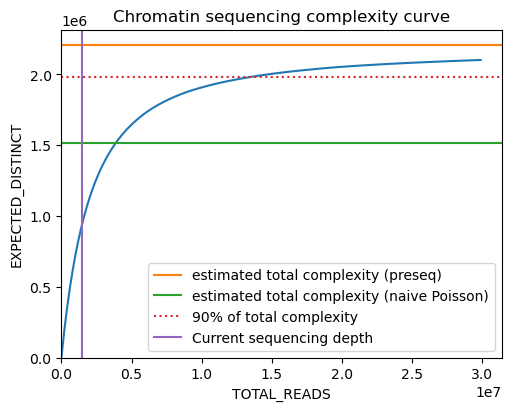

In [207]:
fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
ax.axhline(
    y=complexity_chromatin_preseq['pop_size_estimate'],
    c='C1',
    label='estimated total complexity (preseq)'
)
ax = sns.lineplot(
    df_chromatin_complexity_curve,
    x='TOTAL_READS',
    y='EXPECTED_DISTINCT'
)
ax.axhline(
    y=complexity_chromatin_high,
    c='C2',
    label='estimated total complexity (naive Poisson)'
)
ax.axhline(
    y=0.90*complexity_chromatin_preseq['pop_size_estimate'],
    c='C3',
    ls='dotted',
    label='90% of total complexity'
)
ax.axvline(
    x=df_chromatin['count'].sum(),
    c='C4',
    label='Current sequencing depth'
)
ax.set_title('Chromatin sequencing complexity curve')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
ax.legend()
fig.savefig(
    os.path.join(DIR_RESULTS, 'chromatin sequencing complexity curve.png'),
    dpi=300,
    bbox_inches='tight'
)
fig.show()

In [202]:
print('Amount (fold) more sequencing required to achieve 90% coverage:')
df_chromatin_complexity_curve.loc[
    df_chromatin_complexity_curve['EXPECTED_DISTINCT'] >= 0.9 * complexity_chromatin_preseq['pop_size_estimate'],
    'TOTAL_READS'
].min() / df_chromatin['count'].sum()

Amount (fold) more sequencing required to achieve 90% coverage:


9.248314545303577

Coverage estimates

In [203]:
print('Coverage estimate (naive Poisson model): ~{:.1%}'.format(n_chromatin_dedup_start_and_end / complexity_chromatin_high))
# alternatively use n_chromatin_dedup_start_or_end / complexity_chromatin_low, which gives a similar result

print('Coverage estimate (preseq): ~{:.1%}'.format(n_chromatin_dedup_start_and_end / complexity_chromatin_preseq['pop_size_estimate']))

Coverage estimate (naive Poisson model): ~62.4%
Coverage estimate (preseq): ~42.9%


### Chromatin analysis

In [204]:
df_chromatin['length'] = df_chromatin['end'] - df_chromatin['start']
df_chromatin['species'] = df_chromatin['chr'].str[0].map(dict(h='human', m='mouse')).astype('category')

Number of deduplicated mouse and human chromatin reads is very similar

In [205]:
df_chromatin.groupby('species').size()

/tmp/ipykernel_1877134/642868734.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_chromatin.groupby('species').size()


species
human    459999
mouse    485370
dtype: int64

Mouse and human chromatin have similar fragmentation sizes, with mouse fragments slightly smaller than human.

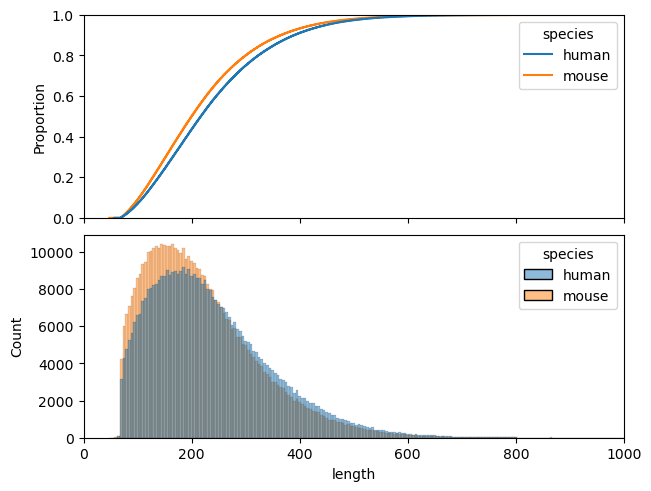

In [206]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=False, constrained_layout=True)
sns.ecdfplot(df_chromatin, x='length', hue='species', ax=axs[0])
sns.histplot(df_chromatin, x='length', binwidth=5, hue='species', ax=axs[1])
# auto binning can lead to artifactual periodic peaks in the histogram --> need to manually set binwidth
# - can verify no actual periodic peaks by manually looking at values in the df_chromatin table

axs[1].set_xlim(0, 1000)
fig.savefig(os.path.join(DIR_RESULTS, 'chromatin_fragmentation_size.png'), bbox_inches='tight', dpi=300)

In [208]:
df_chromatin_species_per_bead = (
    df_chromatin
    .groupby(['bead', 'species'], observed=True)
    .size()
    .rename('count')
    .reset_index()
    .pivot(index='bead', values='count', columns='species')
    .fillna(0)
    .astype(int)
    .pipe(lambda df: df.assign(total=df['human'] + df['mouse']))
    .pipe(lambda df: df.assign(human=df['human']/df['total'], mouse=df['mouse']/df['total']))
)
df_chromatin_species_per_bead = df_chromatin_species_per_bead.assign(**{
    'chromatin molecules per bead': pd.cut(
        df_chromatin_species_per_bead['total'],
        bins=[0, 1, 4, 16, 64, 256, 1024, np.inf],
        right=True,
        labels=['1', '2-4', '5-16', '17-64', '65-256', '257-1024', '1025+']
    )}
)

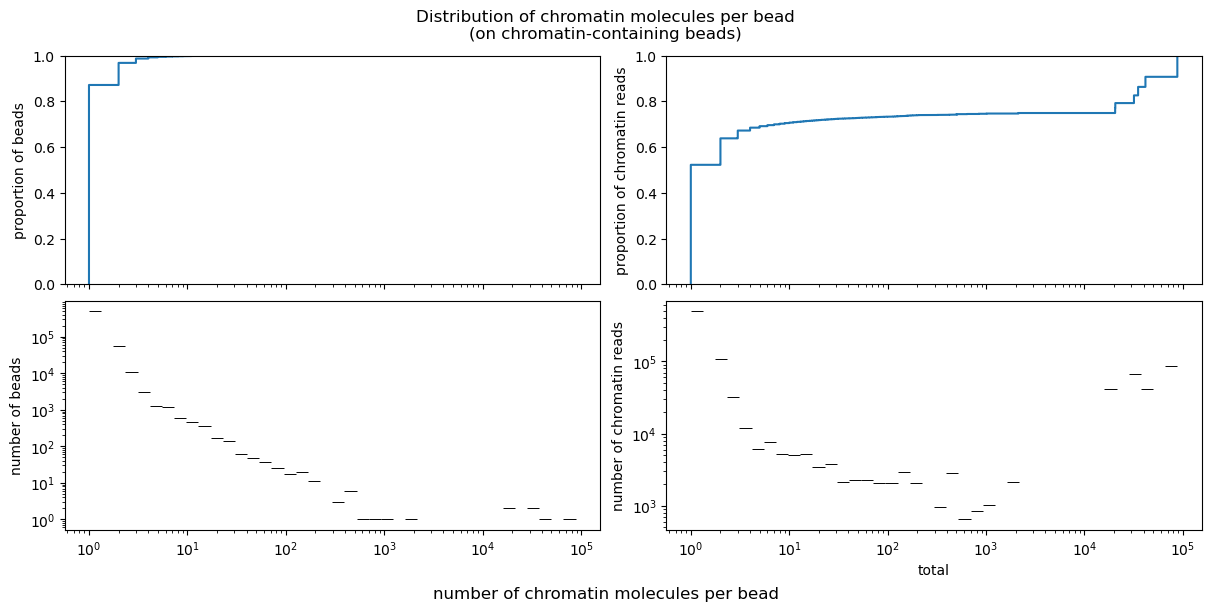

In [209]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex=True, constrained_layout=True)
sns.ecdfplot(df_chromatin_species_per_bead, x='total', log_scale=True, ax=axs[0, 0])
axs[0, 0].set_ylabel('proportion of beads')
sns.ecdfplot(df_chromatin_species_per_bead, x='total', weights='total', log_scale=True, ax=axs[0, 1])
axs[0, 1].set_ylabel('proportion of chromatin reads')
sns.histplot(df_chromatin_species_per_bead, x='total', bins=40, log_scale=(True, True), ax=axs[1, 0])
axs[1, 0].set_ylabel('number of beads')
sns.histplot(df_chromatin_species_per_bead, x='total', weights='total', bins=40, log_scale=(True, True), ax=axs[1, 1])
axs[1, 1].set_ylabel('number of chromatin reads')
axs[1, 0].set_xlabel(None)
fig.supxlabel('number of chromatin molecules per bead')
fig.suptitle('Distribution of chromatin molecules per bead\n(on chromatin-containing beads)')
fig.savefig(
    os.path.join(DIR_RESULTS, 'distribution of chromatin molecules per bead.png'),
    dpi=300,
    bbox_inches='tight'
)
fig.show()

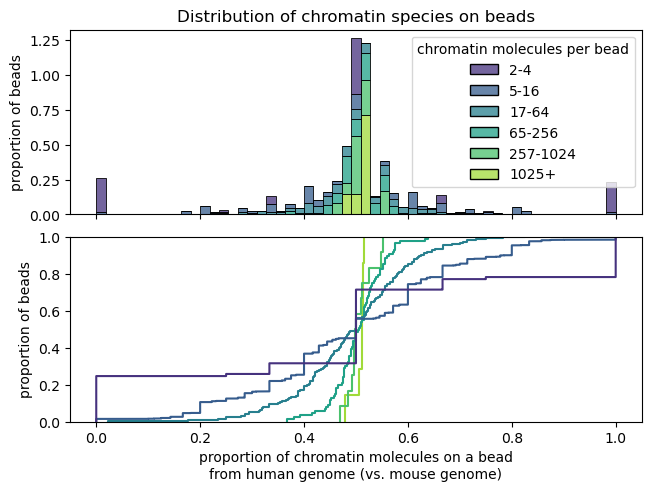

In [210]:
fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True)
sns.histplot(
    df_chromatin_species_per_bead.loc[df_chromatin_species_per_bead['total'] > 1]
    .pipe(lambda df: df.assign(**{
        'chromatin molecules per bead': df['chromatin molecules per bead'].cat.remove_categories('1')
    })),
    x='human',
    stat='proportion',
    multiple='stack',
    common_norm=False,
    hue='chromatin molecules per bead',
    palette='viridis',
    ax=axs[0]
)
sns.ecdfplot(
    df_chromatin_species_per_bead.loc[df_chromatin_species_per_bead['total'] > 1]
    .pipe(lambda df: df.assign(**{
        'chromatin molecules per bead': df['chromatin molecules per bead'].cat.remove_categories('1')
    })),
    x='human',
    hue='chromatin molecules per bead',
    palette='viridis',
    legend=False,
    ax=axs[1]
)
axs[0].set_ylabel('proportion of beads')
axs[1].set_ylabel('proportion of beads')
axs[1].set_xlabel('proportion of chromatin molecules on a bead\nfrom human genome (vs. mouse genome)')
axs[0].set_title('Distribution of chromatin species on beads')
fig.savefig(
    os.path.join(DIR_RESULTS, 'distribution of chromatin species on beads.png'),
    dpi=300,
    bbox_inches='tight'
)
fig.show()

Interpretation
- Most (~87%) beads with any chromatin have only 1 observed chromatin read. Of the remaining beads with 2+ observed chromatin molecules, most (>56%) have more than 1 observed species of chromatin associated.
- Overloaded beads are very evenly mixed.
  - 8 beads with over 1000 chromatin reads each account for ~25% of all chromatin reads.
- Beads that captured a single chromatin cluster from a single cell may potentially be associated with many distinct chromatin fragments from a cluster, and those should all be from the same species. (This would be consistent with the observed reads per R1-R4 barcode distribution, which appears biased in a way that could be explained by this kind of clustering.)
  - Are beads with a few (say, 2-4) chromatin fragments more likely to be uniformly of one species, compared to a uniformly random distribution of species?
    - Comparison with simulation results below suggests that on beads with 2+ chromatin reads, the data is consistent with species being randomly distributed across those reads - i.e., there is no evidence of beads capturing chromatin in clusters.

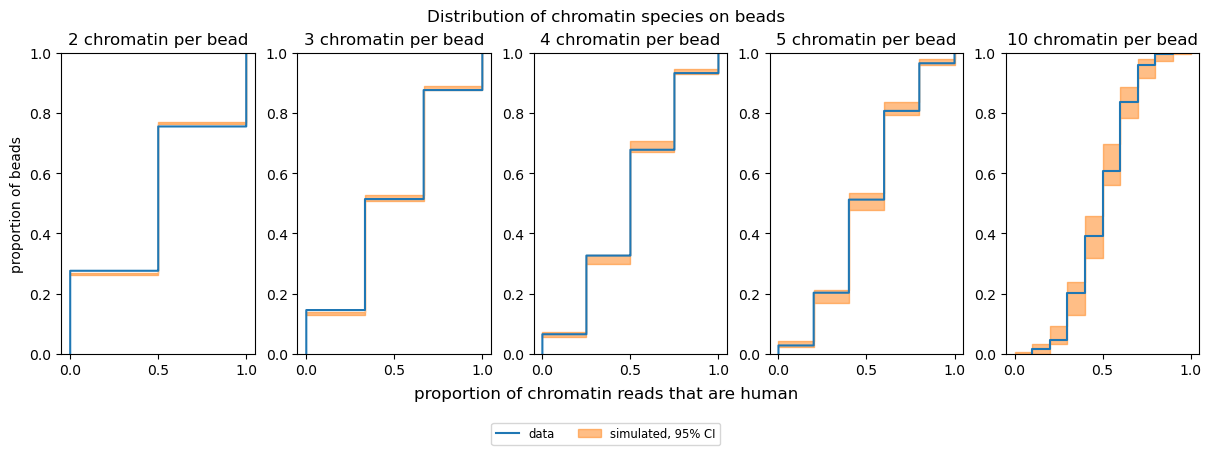

In [211]:
# simulation parameters
trials = 1000
rng = np.random.default_rng(seed=10)

fig, axs = plt.subplots(1, 5, figsize=(12, 4), constrained_layout=True)
for i, total_chromatin in enumerate([2, 3, 4, 5, 10]):
    mask = df_chromatin_species_per_bead['total'] == total_chromatin
    n_beads = mask.sum()

    ecdf_object = axs[i].ecdf(df_chromatin_species_per_bead.loc[mask, 'human'], label='data')
    axs[i].set_title(f'{total_chromatin} chromatin per bead')

    # proportion of all chromatin reads that are human
    p = (df_chromatin_species_per_bead.loc[mask, 'human'] * df_chromatin_species_per_bead.loc[mask, 'total']).sum() / \
        df_chromatin_species_per_bead.loc[mask, 'total'].sum()
    simulated_human_chromatin_count = rng.binomial(total_chromatin, p, size=(n_beads, trials))
    ecdf_ci = []
    for n_chromatin_human in np.arange(total_chromatin + 1):
        cumulative_n_beads = (simulated_human_chromatin_count <= n_chromatin_human).sum(axis=0)
        ecdf_ci.append(dict(
            n_chromatin_human=n_chromatin_human,
            lower=np.percentile(cumulative_n_beads, 2.5) / n_beads,
            upper=np.percentile(cumulative_n_beads, 97.5) / n_beads
        ))
    ecdf_ci = pd.DataFrame(ecdf_ci)
    fill_object = axs[i].fill_between(
        x=ecdf_ci['n_chromatin_human'] / total_chromatin,
        y1=ecdf_ci['upper'],
        y2=ecdf_ci['lower'],
        step='post',
        color='C1',
        alpha=0.5,
        label='simulated, 95% CI'
    )

handles = [ecdf_object, fill_object]
fig.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.03),
    ncols=2,
    fontsize='small'
)

axs[0].set_ylabel('proportion of beads')
fig.supxlabel('proportion of chromatin reads that are human')
fig.suptitle('Distribution of chromatin species on beads')
fig.savefig(
    os.path.join(DIR_RESULTS, 'distribution of chromatin species on beads.png'),
    dpi=300,
    bbox_inches='tight'
)
fig.show()

In [212]:
print('Proportion of chromatin-containing beads with single chromatin species:', df_chromatin_species_per_bead['human'].isin([0.0, 1.0]).mean())
print('Proportion of chromatin-containing beads with single chromatin molecule:', (df_chromatin_species_per_bead['total'] == 1).mean())

Proportion of chromatin-containing beads with single chromatin species: 0.9276790331319613
Proportion of chromatin-containing beads with single chromatin molecule: 0.8714184108024349


## Oligo read processing

### Extract UMIs and reformat read names
- splitcode-output read name structure: `@<name>::bead=<#>::[oligo_ID][LigEven] RX:Z:ACCCGTGC`
- Final read name structure = `@<name>::bead=<#>::[oligo_ID]::umi=<umi>`

In [213]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

PATH_R1="${DIR_PROC}/oligos_R1.fastq.gz"
PATH_R2="${DIR_PROC}/oligos_R2.fastq.gz"
PATH_TMP1="${DIR_PROC}/tmp_R1.fastq.gz"
PATH_TMP2="${DIR_PROC}/tmp_R2.fastq.gz"

splitcode --nFastqs=2 --extract '0:9<umi[8]>' --x-names --no-x-out -t 8 \
    --output="$PATH_TMP1","$PATH_TMP2" \
    "$PATH_R1" "$PATH_R2"

unpigz -c "$PATH_TMP1" |
    sed -E -e 's/(\[LigEven\])? RX:Z:([ATCGN]+)/::umi=\2/' |
    gzip > "$PATH_R1"
rm "$PATH_TMP1"

unpigz -c "$PATH_TMP2" |
    sed -E -e 's/(\[LigEven\])? RX:Z:([ATCGN]+)/::umi=\2/' |
    gzip > "$PATH_R2"
rm "$PATH_TMP2"

* Forcing --gzip because all output file names end in .gz
* Using a list of 0 tags (vector size: 0; map size: 0; num elements in map: 0)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data_proc/20240625/oligos_R1.fastq.gz
                         /central/groups/guttman/btyeh/scBarcode/data_proc/20240625/oligos_R2.fastq.gz
* processing the reads ...
done 
* processed 157,029 reads


### Detect cell barcodes from both read 1 and read 2

Read pairs with complete barcodes are separated from read pairs with incomplete barcodes.

In [214]:
path_config_cell_barcode = os.path.join(DIR_AUX, 'splitcode_config-cell_barcode.tsv')

In [215]:
%%bash -s {DIR_PROC} {path_config_cell_barcode}
DIR_PROC="$1"
PATH_CONFIG="$2"

PATH_R1="${DIR_PROC}/oligos_R1.fastq.gz"
PATH_R2="${DIR_PROC}/oligos_R2.fastq.gz"
PATH_MAPPING="${DIR_PROC}/mapping_cell-barcode.tsv"
PATH_SUMMARY="${DIR_PROC}/summary_cell-barcode.json"
PATH_OUT1="${DIR_PROC}/oligos_cell-barcode_R1.fasta.gz"
PATH_OUT2="${DIR_PROC}/oligos_cell-barcode_R2.fasta.gz"
PATH_UNASSIGNED1="${DIR_PROC}/oligos_unassigned_R1.fasta.gz"
PATH_UNASSIGNED2="${DIR_PROC}/oligos_unassigned_R2.fasta.gz"

splitcode -c "$PATH_CONFIG" \
    --nFastqs=2 --com-names --assign --no-outb --x-names --no-x-out --out-fasta -t 8 \
    --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" \
    --output="$PATH_OUT1","$PATH_OUT2" --unassigned="$PATH_UNASSIGNED1","$PATH_UNASSIGNED2" \
    "$PATH_R1" "$PATH_R2"

gzip -f "$PATH_MAPPING"

* Forcing --gzip because all output file names end in .gz
* Using a list of 193 tags (vector size: 193; map size: 31,280; num elements in map: 31,970)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data_proc/20240625/oligos_R1.fastq.gz
                         /central/groups/guttman/btyeh/scBarcode/data_proc/20240625/oligos_R2.fastq.gz
* processing the reads ...
done 
* processed 157,029 reads, 24,834 reads were assigned


For fully-barcoded cell oligos, modify read names so that there is no whitespace between the read name and cell barcode.

In [216]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

PATH_OUT1="${DIR_PROC}/oligos_cell-barcode_R1.fasta.gz"
PATH_OUT2="${DIR_PROC}/oligos_cell-barcode_R2.fasta.gz"
PATH_TMP="${DIR_PROC}/tmp.fasta.gz"

zcat "$PATH_OUT1" | sed -e 's/ BI:i:/::cell=/' | gzip > "$PATH_TMP"
mv "$PATH_TMP" "$PATH_OUT1"

zcat "$PATH_OUT2" | sed -e 's/ BI:i:/::cell=/' | gzip > "$PATH_TMP"
mv "$PATH_TMP" "$PATH_OUT2"

### Deduplicate and simplify oligos

At this point, we have extracted all possible information from the cell oligos and no longer need the read sequences or even the original read names.

#### Fully barcoded oligos

Simplify the representation of each cell oligo read into the following structure:

`bead=<#>::[human/mouse_<#>]::umi=<umi>::cell=<#>`

This allows for easy deduplication based on bead barcode, cell barcode, and UMI.

In [217]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

PATH_OUT1="${DIR_PROC}/oligos_cell-barcode_R1.fasta.gz"
PATH_OLIGO_FULL_COUNTS="${DIR_PROC}/oligos_full_barcode_counts.txt"

zcat "$PATH_OUT1" |
    grep -E -o "::bead.*" | 
    sed -E -e 's/^:://' -e 's/ BI:i:/::cell=/' |
    sort |
    uniq -c |
    sed -E -e 's/^ *([^ ]+) +/\1\t/' > "$PATH_OLIGO_FULL_COUNTS"

echo "Number of unique cell oligos:" $(wc -l "$PATH_OLIGO_FULL_COUNTS" | cut -f 1 -d ' ')
echo "Number of unique cells:" $(grep -E -o 'cell=.*' "$PATH_OLIGO_FULL_COUNTS" | sort | uniq | wc -l)
echo "Number of unique beads:" $(grep -E -o '(bead=[0-9]+)' "$PATH_OLIGO_FULL_COUNTS" | sort | uniq | wc -l)

Number of unique cell oligos: 11475
Number of unique cells: 9789
Number of unique beads: 8436


Compare with expected number of cells: 78,000  
Compare with expected number of beads: 1% * 148.15 uL * 2.7e6 beads/uL = 4,000,000 beads

##### Complexity and sequencing saturation estimates

In [218]:
dtype_species = pd.CategoricalDtype(categories=('human', 'mouse'), ordered=True)
dtype_oligo_ID = pd.CategoricalDtype(categories=[f'human_{i}' for i in range(1, 49)] + [f'mouse_{i}' for i in range(1, 49)], ordered=True)

In [219]:
path_oligo_counts = os.path.join(DIR_PROC, 'oligos_full_barcode_counts.txt')
df_oligo_counts = pd.read_csv(path_oligo_counts, sep='\t', names=['count', 'oligo'])

regex_oligo_full_barcode = 'bead=(?P<bead>\d+)::\[(?P<oligo_ID>.*)\]::umi=(?P<umi>[ATCGN]+)::cell=(?P<cell>\d+)'
df_oligo_counts = pd.concat(
    (
        df_oligo_counts.drop(columns='oligo'),
        df_oligo_counts['oligo'].str.extract(regex_oligo_full_barcode)
    ),
    axis=1
).astype({'bead': int, 'cell': 'Int64', 'oligo_ID': dtype_oligo_ID})
df_oligo_counts['species'] = df_oligo_counts['oligo_ID'].str.extract('(mouse|human)').astype(dtype_species)

Estimate additional reads required to obtain saturation

In [220]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

source ~/.bashrc
conda activate genomics

PATH_OLIGO_FULL_COUNTS="${DIR_PROC}/oligos_full_barcode_counts.txt"
PATH_OLIGO_FULL_BARCODE_COMPLEXITY_CURVE="${DIR_PROC}/oligos_full_barcode_complexity_curve.tsv"
PATH_OLIGO_FULL_BARCODE_COMPLEXITY_TOTAL="${DIR_PROC}/oligos_full_barcode_complexity_total.tsv"

preseq lc_extrap -o "$PATH_OLIGO_FULL_BARCODE_COMPLEXITY_CURVE" -e 1000000 -s 10000 \
    -V <(cut -f 1 "$PATH_OLIGO_FULL_COUNTS")

preseq pop_size -o "$PATH_OLIGO_FULL_BARCODE_COMPLEXITY_TOTAL" -V <(cut -f 1 "$PATH_OLIGO_FULL_COUNTS")

In [221]:
path_oligo_full_barcode_complexity_curve = os.path.join(DIR_PROC, 'oligos_full_barcode_complexity_curve.tsv')
path_oligo_full_barcode_complexity_total = os.path.join(DIR_PROC, 'oligos_full_barcode_complexity_total.tsv')

df_oligo_full_barcode_complexity_curve = pd.read_csv(path_oligo_full_barcode_complexity_curve, sep='\t', header=0)
oligo_full_barcode_complexity_total = pd.read_csv(path_oligo_full_barcode_complexity_total, sep='\t', header=0).squeeze()

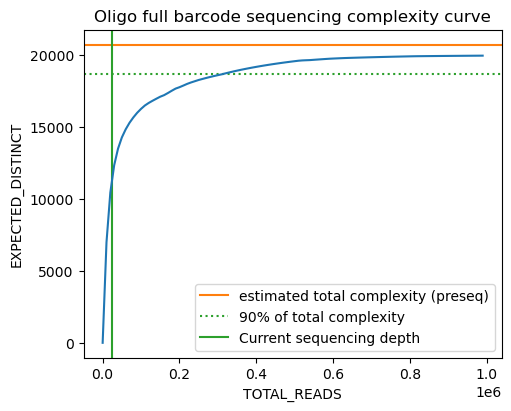

In [225]:
fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
ax.axhline(
    y=oligo_full_barcode_complexity_total['pop_size_estimate'],
    c='C1',
    label='estimated total complexity (preseq)'
)
ax.axhline(
    y=0.90*oligo_full_barcode_complexity_total['pop_size_estimate'],
    c='C2',
    ls='dotted',
    label='90% of total complexity'
)
ax.axvline(
    x=df_oligo_counts['count'].sum(),
    c='C2',
    label='Current sequencing depth'
)
sns.lineplot(
    df_oligo_full_barcode_complexity_curve,
    x='TOTAL_READS',
    y='EXPECTED_DISTINCT',
    ax=ax
)
ax.set_title('Oligo full barcode sequencing complexity curve')
ax.legend()
fig.savefig(
    os.path.join(DIR_RESULTS, 'oligo full barcode sequencing complexity curve.png'),
    dpi=300,
    bbox_inches='tight'
)
fig.show()

In [226]:
print('Amount (fold) more sequencing required to achieve 90% coverage:')
df_oligo_full_barcode_complexity_curve.loc[
    df_oligo_full_barcode_complexity_curve['EXPECTED_DISTINCT'] >= 0.9 * oligo_full_barcode_complexity_total['pop_size_estimate'],
    'TOTAL_READS'
].min() / df_oligo_counts['count'].sum()

Amount (fold) more sequencing required to achieve 90% coverage:


12.4828863654667

In [227]:
complexity_oligo_est1 = estimate_library_complexity(df_oligo_counts['count'].sum(), len(df_oligo_counts))
complexity_oligo_est2 = estimate_library_complexity2(df_oligo_counts['count'].sum(), df_oligo_counts['count'].mean())

print('Total reads of fully barcoded cell oligos observed:', df_oligo_counts['count'].sum())
print('Unique fully barcoded cell oligos observed:', len(df_oligo_counts['count']))
print('2 estimates of total unique fully barcoded cell oligos in the aliquot: {:.0f}, {:.0f}'.format(complexity_oligo_est1, complexity_oligo_est2))
print('Estimated fully barcoded cell oligo coverage (naive): {:.2%}'.format(len(df_oligo_counts['count']) / complexity_oligo_est1))
print('Estimated fully barcoded cell oligo coverage (preseq): {:.2%}'.format(len(df_oligo_counts['count']) / oligo_full_barcode_complexity_total['pop_size_estimate']))

Total reads of fully barcoded cell oligos observed: 24834
Unique fully barcoded cell oligos observed: 11475
2 estimates of total unique fully barcoded cell oligos in the aliquot: 13720, 13720
Estimated fully barcoded cell oligo coverage (naive): 83.63%
Estimated fully barcoded cell oligo coverage (preseq): 55.41%


#### Non-fully barcoded oligos

Simplify the representation of each cell oligo read into the following structure:

`bead=<#>::[human/mouse_<#>]::umi=<umi>`

Deduplicate based on bead barcode, species, and UMI.

In [228]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

PATH_UNASSIGNED1="${DIR_PROC}/oligos_unassigned_R1.fasta.gz"
PATH_OLIGO_PARTIAL_COUNTS="${DIR_PROC}/oligos_partial_barcode_counts.txt"

zcat "$PATH_UNASSIGNED1" |
    grep -E -o "::bead.*" | 
    sed -E -e 's/^:://' |
    sort |
    uniq -c |
    sed -E -e 's/^ *([^ ]+) +/\1\t/' > "$PATH_OLIGO_PARTIAL_COUNTS"

echo "Number of unique cell oligos:" $(wc -l "$PATH_OLIGO_PARTIAL_COUNTS" | cut -f 1 -d ' ')

Number of unique cell oligos: 49010


Probability that UMIs are insufficient to resolve these non-fully-barcoded oligos
- Determine the maximum number of non-fully barcoded oligos per `bead=<#>::[human/mouse_<#>]` class and compare that with the representation space of the 8 bp UMIs.
  - Binomial distribution: $n$ trials = number of reads in a particular `bead=<#>::[human/mouse_<#>]` class, $p$ probability = 1/UMI space.
  - Probability of a collision = 1-CDF(1)
- Result: extremely unlikely for 2 such deduplicated reads to actually originate from the same original oligo --> we assume that the deduplication here is "complete."
- 457 of these partial barcodes may actually be PCR duplicates of a full barcode, where the partial barcode was not detected as a full barcode due to sequencing errors.
  - For beads associated with multiple oligo barcodes (whether partial or full), these partial barcodes may erroneously inflate the perceived number of on-bead collisions.
  - We exclude these partial barcodes in downstream analyses.

In [229]:
path_oligo_partial_counts = os.path.join(DIR_PROC, 'oligos_partial_barcode_counts.txt')
df_oligo_partial_counts = pd.read_csv(path_oligo_partial_counts, sep='\t', names=['count', 'oligo'])

regex_oligo_partial_barcode = r'bead=(?P<bead>\d+)::\[(?P<oligo_ID>.*)\]::umi=(?P<umi>[ATCGN]+)'
df_oligo_partial_counts = pd.concat(
    (
        df_oligo_partial_counts.drop(columns='oligo'),
        df_oligo_partial_counts['oligo'].str.extract(regex_oligo_partial_barcode)
    ),
    axis=1
).astype({'bead': int, 'oligo_ID': dtype_oligo_ID})
df_oligo_partial_counts['species'] = df_oligo_partial_counts['oligo_ID'].str.extract('(mouse|human)').astype(dtype_species)

In [230]:
p_collision = 1 - scipy.stats.binom.cdf(
    1,
    df_oligo_partial_counts.groupby(['bead', 'oligo_ID'])['count'].sum().max(),
    1/(4**8)
)
print(
    'Maximum number of non-fully-barcoded oligos sharing a bead and oligo ID:',
    df_oligo_partial_counts.groupby(['bead', 'oligo_ID'])['count'].sum().max()
)
print(
    'Probability that 2 or more of those oligos have the same UMI:',
    p_collision
)

/tmp/ipykernel_1877134/3834708285.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_oligo_partial_counts.groupby(['bead', 'oligo_ID'])['count'].sum().max(),
/tmp/ipykernel_1877134/3834708285.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_oligo_partial_counts.groupby(['bead', 'oligo_ID'])['count'].sum().max()


Maximum number of non-fully-barcoded oligos sharing a bead and oligo ID: 273
Probability that 2 or more of those oligos have the same UMI: 8.620742050435837e-06


In [231]:
df_oligo_counts_merged = (
    df_oligo_counts
    .drop(columns='count')
    .merge(
        df_oligo_partial_counts[['bead', 'oligo_ID', 'umi', 'species']],
        how='outer',
        indicator=True
    )
)
sum(df_oligo_counts_merged['_merge'] == 'both')

457

### Oligo analysis

- Oligos per bead
- Oligo species per bead
- Cells per bead

In [232]:
display(df_oligo_counts_merged.groupby('species').size())
p_oligo_human = (df_oligo_counts_merged['species'] == 'human').mean()
print('Proportion of human oligos:', p_oligo_human)

/tmp/ipykernel_1877134/1337887933.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df_oligo_counts_merged.groupby('species').size())


species
human    27231
mouse    32797
dtype: int64

Proportion of human oligos: 0.4536383021256747


Oligos per bead

In [233]:
df_oligo_species_per_bead = (
    df_oligo_counts_merged
    .groupby(['bead', 'species'], observed=True)
    .size()
    .rename('count')
    .reset_index()
    .pivot(index='bead', values='count', columns='species')
    .fillna(0)
    .astype(int)
    .pipe(lambda df: df.assign(total=df['human'] + df['mouse']))
    .pipe(lambda df: df.assign(human=df['human']/df['total'], mouse=df['mouse']/df['total']))
)
df_oligo_species_per_bead = df_oligo_species_per_bead.assign(**{
    'oligo molecules per bead': pd.cut(
        df_oligo_species_per_bead['total'],
        bins=[0, 1, 4, 16, 64, 256, 1024, np.inf],
        right=True,
        labels=['1', '2-4', '5-16', '17-64', '65-256', '257-1024', '1025+']
    )}
)

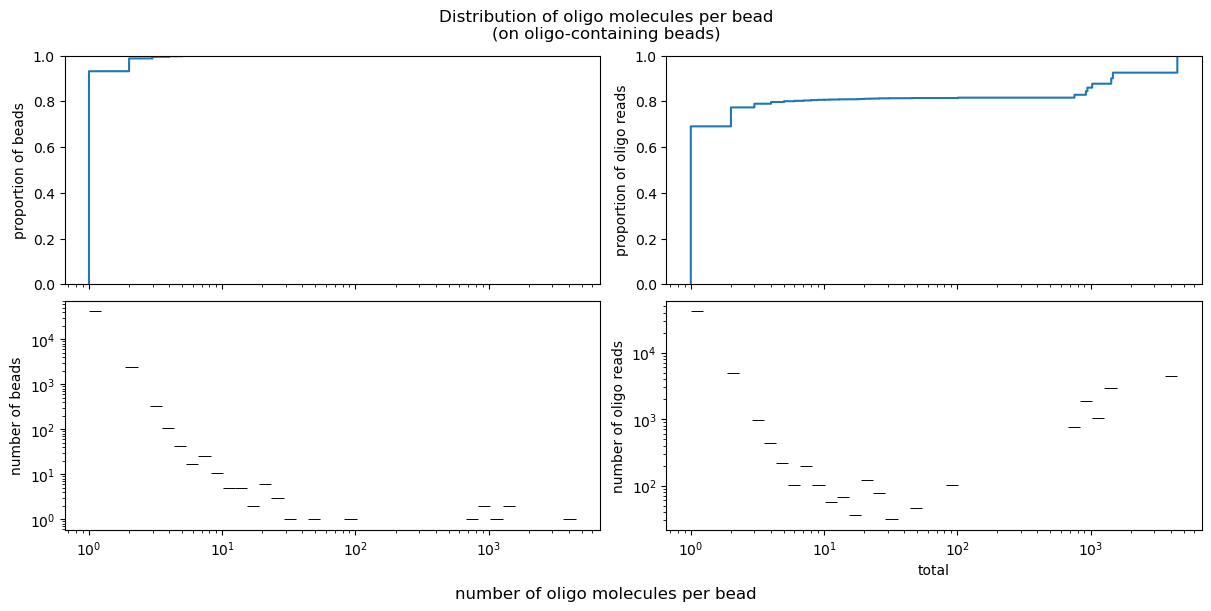

In [234]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex=True, constrained_layout=True)
sns.ecdfplot(df_oligo_species_per_bead, x='total', log_scale=True, ax=axs[0, 0])
axs[0, 0].set_ylabel('proportion of beads')
sns.ecdfplot(df_oligo_species_per_bead, x='total', weights='total', log_scale=True, ax=axs[0, 1])
axs[0, 1].set_ylabel('proportion of oligo reads')
sns.histplot(df_oligo_species_per_bead, x='total', bins=40, log_scale=(True, True), ax=axs[1, 0])
axs[1, 0].set_ylabel('number of beads')
sns.histplot(df_oligo_species_per_bead, x='total', weights='total', bins=40, log_scale=(True, True), ax=axs[1, 1])
axs[1, 1].set_ylabel('number of oligo reads')
axs[1, 0].set_xlabel(None)
fig.supxlabel('number of oligo molecules per bead')
fig.suptitle('Distribution of oligo molecules per bead\n(on oligo-containing beads)')
fig.savefig(
    os.path.join(DIR_RESULTS, 'distribution of oligo molecules per bead.png'),
    dpi=300,
    bbox_inches='tight'
)
fig.show()

Oligo species per bead

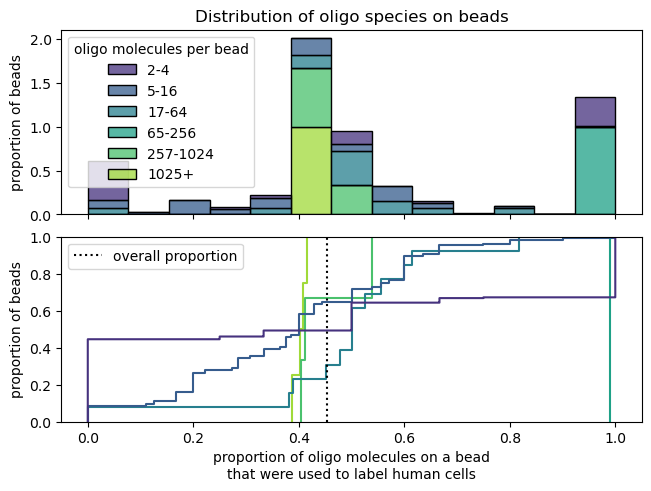

In [235]:
fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True)
sns.histplot(
    df_oligo_species_per_bead.loc[df_oligo_species_per_bead['total'] > 1]
    .pipe(lambda df: df.assign(**{
        'oligo molecules per bead': df['oligo molecules per bead'].cat.remove_categories('1')
    })),
    x='human',
    stat='proportion',
    multiple='stack',
    common_norm=False,
    hue='oligo molecules per bead',
    palette='viridis',
    ax=axs[0]
)
sns.ecdfplot(
    df_oligo_species_per_bead.loc[df_oligo_species_per_bead['total'] > 1]
    .pipe(lambda df: df.assign(**{
        'oligo molecules per bead': df['oligo molecules per bead'].cat.remove_categories('1')
    })),
    x='human',
    hue='oligo molecules per bead',
    palette='viridis',
    legend=False,
    ax=axs[1]
)
axs[0].set_ylabel('proportion of beads')
axs[1].set_ylabel('proportion of beads')
axs[1].set_xlabel('proportion of oligo molecules on a bead\nthat were used to label human cells')
axs[1].axvline(x=p_oligo_human, color='black', ls=':', label='overall proportion')
axs[1].legend()
axs[0].set_title('Distribution of oligo species on beads')
fig.savefig(
    os.path.join(DIR_RESULTS, 'distribution of oligo species on beads.png'),
    dpi=300,
    bbox_inches='tight'
)
fig.show()

In [236]:
df_chromatin_species_per_bead.join(
    df_oligo_species_per_bead.loc[df_oligo_species_per_bead['total'] > 100],
    how='right',
    lsuffix='_chromatin',
    rsuffix='_oligo'
)

species,human_chromatin,mouse_chromatin,total_chromatin,chromatin molecules per bead,human_oligo,mouse_oligo,total_oligo,oligo molecules per bead
bead,,,,,,,,
15,0.513798,0.486202,35078.0,1025+,0.416158,0.583842,1473,1025+
22,0.511230,0.488770,87843.0,1025+,0.386622,0.613378,4485,1025+
36,0.511178,0.488822,41643.0,1025+,0.402516,0.597484,1431,1025+
41,0.513789,0.486211,31838.0,1025+,0.408738,0.591262,1030,1025+
42,0.505171,0.494829,20498.0,1025+,0.411609,0.588391,758,257-1024
68,0.515263,0.484737,20572.0,1025+,0.404117,0.595883,923,257-1024
272,0.478424,0.521576,2132.0,1025+,0.537975,0.462025,948,257-1024
340,NaN,NaN,NaN,NaN,0.990099,0.009901,101,65-256


In [237]:
df_molecules_per_bead = (
    df_chromatin_species_per_bead.join(
        df_oligo_species_per_bead,
        how='outer',
        lsuffix='_chromatin',
        rsuffix='_oligo'
    )
    .drop(columns=['chromatin molecules per bead', 'oligo molecules per bead'])
    .fillna(0)
    .astype(dict(total_chromatin=int, total_oligo=int))
    .rename(columns=dict(total_chromatin='chromatin per bead', total_oligo='oligos per bead'))
)

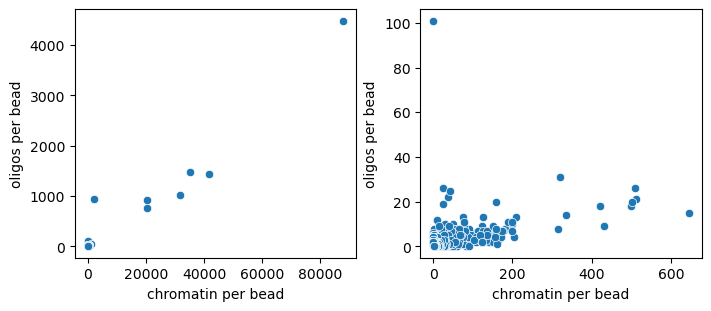

In [238]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3), constrained_layout=True)
sns.scatterplot(
    df_molecules_per_bead,
    x='chromatin per bead',
    y='oligos per bead',
    ax=axs[0]
)
sns.scatterplot(
    df_molecules_per_bead.loc[df_molecules_per_bead['chromatin per bead'] < 750],
    x='chromatin per bead',
    y='oligos per bead',
    ax=axs[1]
)
fig.savefig(
    os.path.join(DIR_RESULTS, 'distribution of molecules per bead, all.png'),
    dpi=300,
    bbox_inches='tight'
)
fig.show()

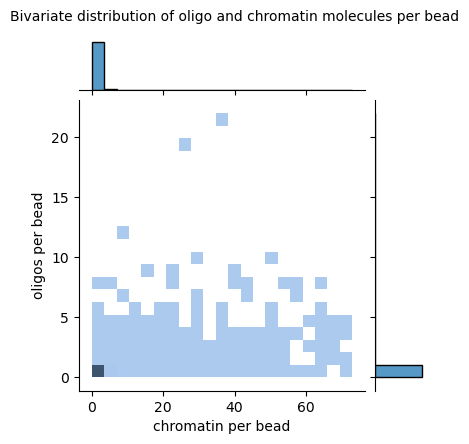

In [239]:
g = sns.jointplot(
    df_molecules_per_bead.loc[(df_molecules_per_bead['chromatin per bead'] < 75) & (df_molecules_per_bead['oligos per bead'] < 25)],
    x='chromatin per bead',
    y='oligos per bead',
    kind='hist'
)
g.figure.suptitle('Bivariate distribution of oligo and chromatin molecules per bead', y=1.05, fontsize='medium')
g.figure.set_size_inches(4, 4)
g.savefig(
    os.path.join(DIR_RESULTS, 'distribution of molecules per bead, zoom.png'),
    dpi=300
)

In [240]:
print('Observed fully barcoded chromatin per bead (mean):', df_molecules_per_bead['chromatin per bead'].mean())
print('Observed fully barcoded chromatin per bead (median):', df_molecules_per_bead['chromatin per bead'].median())
print('Observed fully barcoded oligos per bead (mean):', df_molecules_per_bead['oligos per bead'].mean())
print('Observed fully barcoded oligos per bead (median):', df_molecules_per_bead['oligos per bead'].median())

Observed fully barcoded chromatin per bead (mean): 1.573818224194045
Observed fully barcoded chromatin per bead (median): 1.0
Observed fully barcoded oligos per bead (mean): 0.09993257697462064
Observed fully barcoded oligos per bead (median): 0.0


In [241]:
print('Proportion of beads with single chromatin species:', df_molecules_per_bead['human_chromatin'].isin([0.0, 1.0]).mean())
print('Proportion of beads with single chromatin molecule:', (df_molecules_per_bead['chromatin per bead'] == 1).mean())

Proportion of beads with single chromatin species: 0.9317812164445591
Proportion of beads with single chromatin molecule: 0.8219898948700234


Interpretation
- Most (\~93%) beads with any oligo have only 1 observed oligo read. Of the remaining beads with 2+ observed oligo molecules, a minority (\~26%) have more than 1 observed species of oligo associated.
- Overloaded beads are very evenly mixed.
  - 8 beads with over 100 oligo reads each account for ~19% of all deduplicated oligo reads.
    - 7 of 8 of these beads also have >941 deduplicated chromatin reads, indicating that large aggregates of chromatin and oligos were present on these beads. Potential explanations (not mutually exclusive):
      - Many beads were physically clumped together, such that all beads in a clump got the same barcode.
      - Large, undersonicated chromatin clusters were pulled down by these beads.

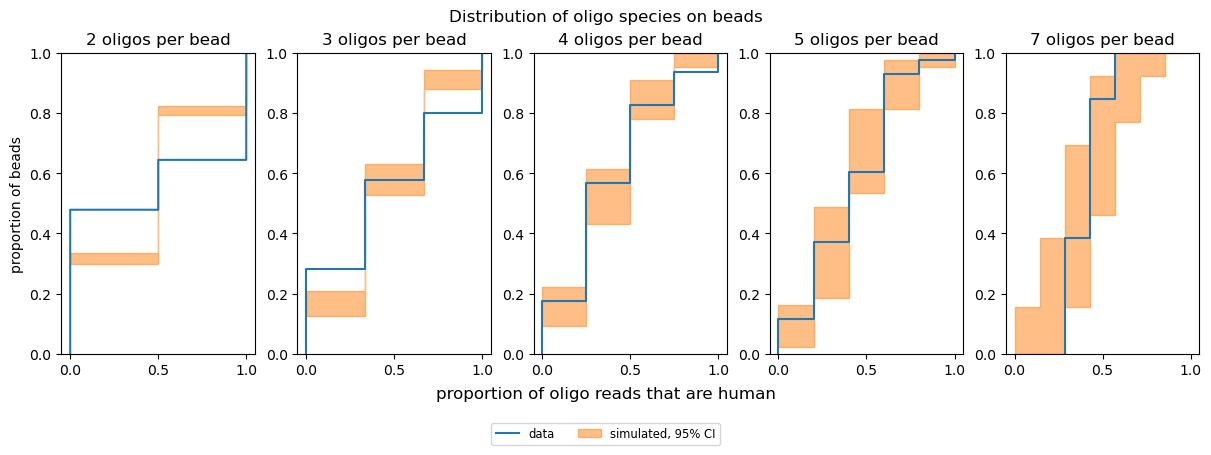

In [242]:
# simulation parameters
trials = 1000
rng = np.random.default_rng(seed=10)

fig, axs = plt.subplots(1, 5, figsize=(12, 4), constrained_layout=True)
for i, total_oligo in enumerate([2, 3, 4, 5, 7]):
    mask = df_oligo_species_per_bead['total'] == total_oligo
    n_beads = mask.sum()

    ecdf_object = axs[i].ecdf(df_oligo_species_per_bead.loc[mask, 'human'], label='data')
    axs[i].set_title(f'{total_oligo} oligos per bead')

    # proportion of all oligo reads that are human
    p = (df_oligo_species_per_bead.loc[mask, 'human'] * df_oligo_species_per_bead.loc[mask, 'total']).sum() / \
        df_oligo_species_per_bead.loc[mask, 'total'].sum()
    simulated_human_oligo_count = rng.binomial(total_oligo, p, size=(n_beads, trials))
    ecdf_ci = []
    for n_oligo_human in np.arange(total_oligo + 1):
        cumulative_n_beads = (simulated_human_oligo_count <= n_oligo_human).sum(axis=0)
        ecdf_ci.append(dict(
            n_oligo_human=n_oligo_human,
            lower=np.percentile(cumulative_n_beads, 2.5) / n_beads,
            upper=np.percentile(cumulative_n_beads, 97.5) / n_beads
        ))
    ecdf_ci = pd.DataFrame(ecdf_ci)
    fill_object = axs[i].fill_between(
        x=ecdf_ci['n_oligo_human'] / total_oligo,
        y1=ecdf_ci['upper'],
        y2=ecdf_ci['lower'],
        step='post',
        color='C1',
        alpha=0.5,
        label='simulated, 95% CI'
    )

handles = [ecdf_object, fill_object]
fig.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.03),
    ncols=2,
    fontsize='small'
)

axs[0].set_ylabel('proportion of beads')
fig.supxlabel('proportion of oligo reads that are human')
fig.suptitle('Distribution of oligo species on beads')
fig.savefig(
    os.path.join(DIR_RESULTS, 'distribution of oligo species on beads (vs. simulation).png'),
    dpi=300,
    bbox_inches='tight'
)
fig.show()

Comparison with simulation results below shows that on beads with 2-3 oligos reads, oligos of the same species are more likely to be distributed together than with oligos of other species, providing evidence of oligos being captured in clusters. While this could imply that oligos are captured in *chromatin* clusters, it may simply reflect that oligos are coupled together on streptavidin at a mean ratio of 2:1.

Cells per bead

In [243]:
df_oligo_cells_per_bead = (
    df_oligo_counts_merged.loc[~df_oligo_counts_merged['cell'].isna()]
    .groupby('bead')
    ['cell']
    .agg(
        max_prop_cell=lambda s: s.value_counts().pipe(lambda x: x.iloc[0] / x.sum()),
        n_oligos='size',
        n_cells=lambda s: len(s.unique())
    )
)

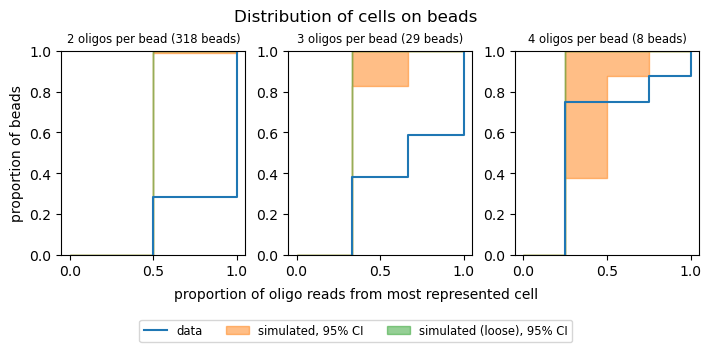

In [244]:
fig, axs = plt.subplots(1, 3, figsize=(7, 3), constrained_layout=True)

for i, n_oligos in enumerate((2, 3, 4)):
    mask = df_oligo_cells_per_bead['n_oligos'] == n_oligos
    n_beads = mask.sum()

    ecdf_object = axs[i].ecdf(
        df_oligo_cells_per_bead.loc[df_oligo_cells_per_bead['n_oligos'] == n_oligos, 'max_prop_cell'],
        label='data'
    )
    axs[i].set_title(f'{n_oligos} oligos per bead ({mask.sum()} beads)', fontsize='small')

    # simulate proportional representation of each cell among beads with n_oligos
    p = df_oligo_counts_merged.loc[
        (~df_oligo_counts_merged['cell'].isna()) & \
          (df_oligo_counts_merged['bead'].isin(mask.loc[mask].index.values)),
        'cell'
    ].value_counts().pipe(lambda s: s / s.sum())
    simulated_cells = rng.choice(p.index.values, p=p.values, size=(n_oligos, n_beads, trials))
    _, mode_count = scipy.stats.mode(simulated_cells, axis=0)
    ecdf_ci = []
    for n_oligo_mode in np.arange(n_oligos + 1):
        cumulative_n_beads = (mode_count <= n_oligo_mode).sum(axis=0)
        ecdf_ci.append(dict(
            prop_oligo_mode=n_oligo_mode / n_oligos,
            lower=np.percentile(cumulative_n_beads, 2.5) / n_beads,
            upper=np.percentile(cumulative_n_beads, 97.5) / n_beads
        ))
    ecdf_ci = pd.DataFrame(ecdf_ci)
    fill_object = axs[i].fill_between(
        x=ecdf_ci['prop_oligo_mode'],
        y1=ecdf_ci['upper'],
        y2=ecdf_ci['lower'],
        step='post',
        color='C1',
        alpha=0.5,
        label='simulated, 95% CI'
    )

    # simulate proportional representation of each cell among all beads
    p_loose = df_oligo_counts_merged.loc[~df_oligo_counts_merged['cell'].isna(), 'cell'] \
        .value_counts().pipe(lambda s: s / s.sum())
    simulated_cells_loose = rng.choice(
        p_loose.index.values,
        p=p_loose.values,
        size=(n_oligos, n_beads, trials)
    )
    _, mode_count = scipy.stats.mode(simulated_cells_loose, axis=0)
    ecdf_ci = []
    for n_oligo_mode in np.arange(n_oligos + 1):
        cumulative_n_beads = (mode_count <= n_oligo_mode).sum(axis=0)
        ecdf_ci.append(dict(
            prop_oligo_mode=n_oligo_mode / n_oligos,
            lower=np.percentile(cumulative_n_beads, 2.5) / n_beads,
            upper=np.percentile(cumulative_n_beads, 97.5) / n_beads
        ))
    ecdf_ci = pd.DataFrame(ecdf_ci)
    fill_object2 = axs[i].fill_between(
        x=ecdf_ci['prop_oligo_mode'],
        y1=ecdf_ci['upper'],
        y2=ecdf_ci['lower'],
        step='post',
        color='C2',
        alpha=0.5,
        label='simulated (loose), 95% CI'
    )

handles = [ecdf_object, fill_object, fill_object2]
fig.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.03),
    ncols=3,
    fontsize='small'
)

axs[0].set_ylabel('proportion of beads')
fig.supxlabel('proportion of oligo reads from most represented cell', fontsize='medium')
fig.suptitle('Distribution of cells on beads')
fig.savefig(
    os.path.join(DIR_RESULTS, 'distribution of cells on beads.png'),
    dpi=300,
    bbox_inches='tight'
)
fig.show()

Interpretation: for beads with 2-4 oligos, oligos on those beads are much more likely to come from the same cell than by chance. While this could imply that oligos are captured in clusters (e.g., on chromatin), it may simply reflect that oligos are coupled together on streptavidin at a mean ratio of 2:1.

## Oligo-chromatin pairing

In [245]:
class Bead:
    def __init__(self, bead_ID, oligos=None, chromatin=None):
        self.bead_ID = bead_ID
        self.oligos = oligos if oligos is not None else set()
        self.chromatin = chromatin if chromatin is not None else set()
        self.oligo_counts = collections.Counter([(oligo_ID, cell) for (oligo_ID, umi, cell) in self.oligos])

    def add_chromatin(self, chrom, start, end):
        self.chromatin.add((chrom, start, end))

    def add_oligo(self, oligo_ID, umi, cell=pd.NA):
        self.oligos.add((oligo_ID, umi, cell))
        self.oligo_counts[(oligo_ID, cell)] += 1

    def oligo_species_counts(self):
        assert len(self.oligos) == sum(self.oligo_counts.values())
        species_counts = np.zeros(2, dtype=int)
        for oligo_ID, _, _ in self.oligos:
            if oligo_ID.startswith('human'):
                species_counts[0] += 1
            elif oligo_ID.startswith('mouse'):
                species_counts[1] += 1
            else:
                raise ValueError(f'Unexpected oligo_ID {oligo_ID}')
        assert len(self.oligos) == species_counts.sum()
        return {'human': species_counts[0], 'mouse': species_counts[1]}

    def max_prop_oligo_species(self):
        '''
        Return
        - species: str or None
        - count: int
        - proportion: np.float64

        If proportion is 0.5, species is 'human'
        '''
        assert len(self.oligos) == sum(self.oligo_counts.values())
        if len(self.oligos) > 0:
            species_counts = self.oligo_species_counts()
            if species_counts['human'] >= species_counts['mouse']:
                species_main = 'human'
                count = species_counts['human']
            else:
                species_main = 'mouse'
                count = species_counts['mouse']
            return species_main, count, count / sum(species_counts.values())
        else:
            return None, 0, np.nan

    def max_prop_oligo(self):
        '''
        Return
        - oligo: tuple or None
          - oligo_ID: str
          - cell: pd.Int64
        - count: int
        - proportion: np.float64
        '''
        assert len(self.oligos) == sum(self.oligo_counts.values())
        if len(self.oligos) > 0:
            (oligo_ID, cell), count = self.oligo_counts.most_common(1)[0]
            return (oligo_ID, cell), count, count / len(self.oligos)
        else:
            return None, 0, np.nan

    def status(self, species_prop_thresh=0.8, species_min_count=1, oligo_prop_thresh=0.8, oligo_min_count=1):
        '''
        Return
        - (species_main, species_status)
        - (oligo_main, oligo_status)
        '''
        if len(self.oligos) == 0 or len(self.chromatin) == 0:
            return None

        # determine oligo main status
        (oligo_ID, cell), oligo_count, oligo_prop = self.max_prop_oligo()
        if oligo_count == 0:
            oligo_status = 'none'
        elif oligo_count < oligo_min_count:
            oligo_status = 'uncertain'
        elif oligo_prop < oligo_prop_thresh:
            oligo_status = 'ambiguous'
        elif oligo_prop == 1:
            oligo_status = 'unique'
        else:
            oligo_status = 'predominant'

        species, species_count, species_prop = self.max_prop_oligo_species()
        if species_count == 0:
            species_status = 'none'
        elif species_count < species_min_count:
            species_status = 'uncertain'
        elif species_prop < species_prop_thresh:
            species_status = 'ambiguous'
        elif species_prop == 1:
            species_status = 'unique'
        else:
            species_status = 'predominant'

        return (species, species_status), ((oligo_ID, cell), oligo_status)

    def get_chromatin_species_counts(self):
        species_counts = dict(mouse=0, human=0)
        for chrom, _, _ in self.chromatin:
            if chrom.startswith('m_chr'):
                species_counts['mouse'] += 1
            elif chrom.startswith('h_chr'):
                species_counts['human'] += 1
            else:
                raise ValueError(f'Unexpected chromosome name {chrom}')
        return species_counts

    def proper_pairing(self, return_type='status', **kwargs):
        '''
        Returns:
        - If 0 oligos, 0 chromatin, or more than 1 type of chromatin species: None
        - Otherwise: (species_pairing, cell_pairing)
        '''
        if len(self.oligos) == 0:
            if len(self.chromatin) == 0:
                return 'empty bead'
            else:
                return 'no oligos'
        elif len(self.chromatin) == 0:
            return 'no chromatin'

        chromatin_species_counts = self.get_chromatin_species_counts()
        if chromatin_species_counts['mouse'] > 0 and chromatin_species_counts['human'] > 0:
            # contains both human and mouse chromatin --> cannot determine whether bead barcode-cell barcode pairing was specific
            return 'overloaded bead'
        if chromatin_species_counts['mouse'] == 0 and chromatin_species_counts['human'] > 0:
            chromatin_species = 'human'
        elif chromatin_species_counts['mouse'] > 0 and chromatin_species_counts['human'] == 0:
            chromatin_species = 'mouse'
        else:
            # no chromatin - should have returned None prior to this point
            raise RuntimeError

        if return_type == 'status':
            (oligo_species, oligo_species_status), ((oligo_ID, cell), oligo_status) = self.status(**kwargs)
    
            # species pairing
            if chromatin_species == oligo_species:
                species_pairing = oligo_species_status
                # oligo pairing
                if oligo_ID[:5] != chromatin_species:
                    return (species_pairing, 'mixed')
                return (species_pairing, oligo_status)
            else:
                return ('mixed', 'mixed')
        elif return_type == 'counts':
            return (chromatin_species, self.oligo_species_counts())
        else:
            raise ValueError(f'return_type of {return_type} not valid.')

In [246]:
beads = {} # map from bead ID to bead object; uses full and partial oligo barcodes
for _, row in tqdm(df_chromatin.iterrows()):
    if row['bead'] not in beads:
        beads[row['bead']] = Bead(row['bead'], chromatin={(row['chr'], row['start'], row['end'])})
    else:
        beads[row['bead']].add_chromatin(row['chr'], row['start'], row['end'])
beads_strict = copy.deepcopy(beads) # same as beads, but uses only full oligo barcdes

for _, row in tqdm(df_oligo_counts_merged.iterrows()):
    if row['bead'] not in beads:
        beads[row['bead']] = Bead(row['bead'], oligos={(row['oligo_ID'], row['umi'], row['cell'])})
    else:
        beads[row['bead']].add_oligo(row['oligo_ID'], row['umi'], row['cell'])

for _, row in tqdm(df_oligo_counts.iterrows()):
    if row['bead'] not in beads_strict:
        beads_strict[row['bead']] = Bead(row['bead'], oligos={(row['oligo_ID'], row['umi'], row['cell'])})
    else:
        beads_strict[row['bead']].add_oligo(row['oligo_ID'], row['umi'], row['cell'])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Specificity

In [248]:
pairing_counts = collections.Counter(bead.proper_pairing() for bead in beads.values())
pairing_counts

Counter({'no oligos': 556188,
         'no chromatin': 34072,
         ('mixed', 'mixed'): 3670,
         ('unique', 'unique'): 3359,
         'overloaded bead': 3275,
         ('unique', 'ambiguous'): 62,
         ('ambiguous', 'ambiguous'): 54,
         ('ambiguous', 'mixed'): 5})

In [249]:
pairing_counts_strict = collections.Counter(bead.proper_pairing() for bead in beads_strict.values())
pairing_counts_strict

Counter({'no oligos': 564322,
         'no chromatin': 6145,
         'overloaded bead': 897,
         ('mixed', 'mixed'): 706,
         ('unique', 'unique'): 683,
         ('ambiguous', 'ambiguous'): 3,
         ('unique', 'ambiguous'): 2})

#### Mixing proportion
For beads with only 1 chromatin species, what proportion have cell oligos from a different species?

##### Overall proportion

In [250]:
numerator = sum(count for statuses, count in pairing_counts.items() if (type(statuses) is tuple) and (statuses[0] != 'unique'))
denominator = sum(count for statuses, count in pairing_counts.items() if type(statuses) is tuple)
print(numerator / denominator)

0.5215384615384615


In [251]:
numerator = sum(count for statuses, count in pairing_counts_strict.items() if (type(statuses) is tuple) and (statuses[0] != 'unique'))
denominator = sum(count for statuses, count in pairing_counts_strict.items() if type(statuses) is tuple)
print(numerator / denominator)

0.5086083213773315


Alternate implementation of computing mixing proportion without using the `Bead` class.

In [252]:
bead_to_cell_oligo_species = (
    df_oligo_counts_merged
    .groupby('bead')
    ['species']
    .agg(
        proportion_human=lambda x: (x == 'human').mean(),
        oligo_count=len
    )
)
bead_to_cell_oligo_species['species, unique'] = bead_to_cell_oligo_species['proportion_human'].map(dict({0.0: 'mouse', 1.0: 'human'}))
bead_to_cell_oligo_species['species, predominant'] = bead_to_cell_oligo_species.apply(
    lambda row: 'human' if row['proportion_human'] >= 0.8 else 'mouse' if row['proportion_human'] < 0.2 else np.nan,
    axis=1
)

How many beads are predominantly (but not uniquely) one oligo species?

In [253]:
bead_to_cell_oligo_species.loc[(~bead_to_cell_oligo_species['species, predominant'].isna()) & bead_to_cell_oligo_species['species, unique'].isna()]

,proportion_human,oligo_count,"species, unique","species, predominant"
bead,,,,
340,0.990099,101,NaN,human
761,0.818182,22,NaN,human
1330,0.800000,5,NaN,human
1346,0.166667,6,NaN,mouse
5382,0.166667,6,NaN,mouse
9443,0.800000,5,NaN,human
10353,0.166667,6,NaN,mouse
17092,0.111111,9,NaN,mouse
18386,0.125000,8,NaN,mouse


In [254]:
# DataFrame of beads with chromatin reads of unique species and at least 1 cell oligo
df_paired_beads = (
    df_chromatin.loc[df_chromatin['bead'].isin(bead_to_cell_oligo_species.index)]
    .groupby('bead')
    .filter(lambda g: len(g['species'].unique()) == 1)
    .reset_index(drop=True)
    .pipe(lambda df: df.assign(**{
        'oligo species': df['bead'].map(bead_to_cell_oligo_species['species, unique']),
        'oligo count': df['bead'].map(bead_to_cell_oligo_species['oligo_count'])
    }))
    .groupby('bead')
    .apply(
        lambda g: pd.Series(dict(
            chromatin_per_bead=len(g),
            oligos_per_bead=g['oligo count'].iloc[0],
            mixed=g['oligo species'].isna().any() or (g['oligo species'] != g['species'].iloc[0]).any()
        )),
        include_groups=False
    )
    .groupby(['chromatin_per_bead', 'oligos_per_bead', 'mixed'])
    .size()
    .rename('number of beads')
    .reset_index()
)

In [255]:
df_paired_beads.loc[df_paired_beads['mixed'], 'number of beads'].sum() / df_paired_beads['number of beads'].sum()

0.5215384615384615

Visualization

In [256]:
df_mixing_results = []
for bead in beads.values():
    result = bead.proper_pairing(return_type='counts')
    if type(result) is tuple:
        df_mixing_results.append((result[0], result[1]['human'], result[1]['mouse']))
df_mixing_results = pd.DataFrame(df_mixing_results, columns=['bead species', 'human oligo counts', 'mouse oligo counts'])
df_mixing_results = df_mixing_results.groupby(list(df_mixing_results.columns)).size().rename('count').reset_index()

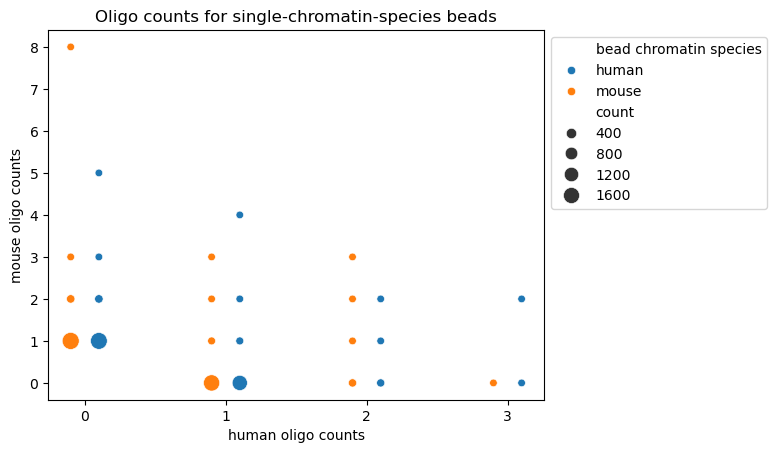

In [259]:
ax = sns.scatterplot(
    # x-jitter human oligo counts for visualization
    df_mixing_results.rename(columns={'bead species': 'bead chromatin species'}) \
        .assign(**{'human oligo counts': df_mixing_results['human oligo counts'] + 0.2 * (df_mixing_results['bead species'] == 'human').astype(float) - 0.1}),
    x='human oligo counts',
    y='mouse oligo counts',
    hue='bead chromatin species',
    size='count',
    sizes=(30, 150)
)
ax.set_title('Oligo counts for single-chromatin-species beads')
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.figure.savefig(
    os.path.join(DIR_RESULTS, 'single-chromatin-species-beads_mixing.png'),
    bbox_inches='tight',
    dpi=300
)

Proportion of human-chromatin-only beads with only mouse oligos

In [260]:
df_mixing_results.loc[
    (df_mixing_results['bead species'] == 'human') & \
    (df_mixing_results['human oligo counts'] == 0),
    'count'
].sum() / df_mixing_results.loc[
    df_mixing_results['bead species'] == 'human',
    'count'
].sum()

0.5537965406039285

Proportion of mouse-chromatin-only beads with only human oligos

In [261]:
df_mixing_results.loc[
    (df_mixing_results['bead species'] == 'mouse') & \
    (df_mixing_results['mouse oligo counts'] == 0),
    'count'
].sum() / df_mixing_results.loc[
    df_mixing_results['bead species'] == 'mouse',
    'count'
].sum()

0.463225461353303

##### Mixing proportion by bead size

In [262]:
mixing_proportion_by_bead_size = (
    df_paired_beads
    .groupby(['chromatin_per_bead', 'oligos_per_bead'])
    .apply(
        lambda g: pd.Series({
            'number of beads': g['number of beads'].sum(),
            'proportion mixed': 0 if (g['mixed'] == False).all() else 1 if (g['mixed'] == True).all() else g.loc[g['mixed'], 'number of beads'].sum() / g['number of beads'].sum()
        }),
        include_groups=False
    )
    .reset_index()
    .astype({'number of beads': int})
)

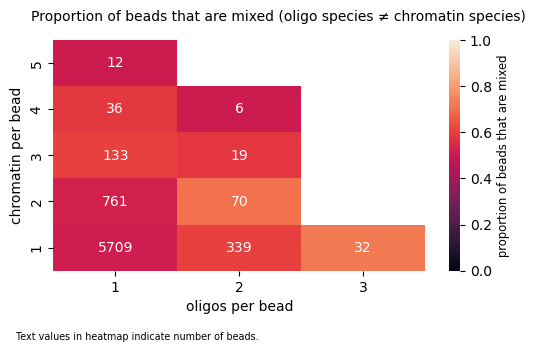

In [267]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.heatmap(
    (
        mixing_proportion_by_bead_size
        .loc[mixing_proportion_by_bead_size['number of beads'] > 4]
        .pivot(index='chromatin_per_bead', columns='oligos_per_bead', values='proportion mixed')
        .sort_index(ascending=False)
    ),
    annot=(
        mixing_proportion_by_bead_size
        .loc[mixing_proportion_by_bead_size['number of beads'] > 4]
        .pivot(index='chromatin_per_bead', columns='oligos_per_bead', values='number of beads')
        .astype('Int64')
        .sort_index(ascending=False)
    ),
    fmt='d',
    vmin=0, vmax=1,
    ax=ax
)
ax.set_xlabel('oligos per bead')
ax.set_ylabel('chromatin per bead')
ax.text(-0.3, 6.5, s='Text values in heatmap indicate number of beads.', fontsize='x-small')
fig.suptitle('Proportion of beads that are mixed (oligo species ≠ chromatin species)', fontsize='medium')
ax.collections[0].colorbar.set_label('proportion of beads that are mixed', fontsize='small')
fig.savefig(
    os.path.join(DIR_RESULTS, 'proportion of beads that are mixed by bead size.png'),
    dpi=300,
    bbox_inches='tight'
)
fig.show()

In [268]:
mixing_proportion_by_chromatin = (
    mixing_proportion_by_bead_size
    .groupby('chromatin_per_bead')
    .apply(lambda g: pd.Series({
        'proportion mixed': (g['number of beads'] * g['proportion mixed']).sum() / g['number of beads'].sum(),
        'number of beads': g['number of beads'].sum()
    }))
    .reset_index()
    .rename(columns={'chromatin_per_bead': 'chromatin per bead'})
)

/tmp/ipykernel_1877134/2054484374.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


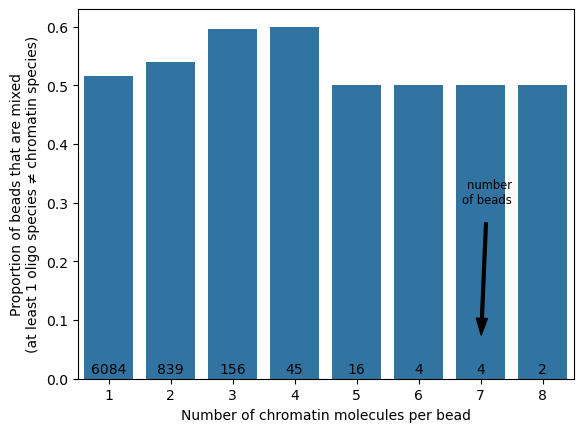

In [269]:
ax = sns.barplot(
    mixing_proportion_by_chromatin,
    x='chromatin per bead',
    y='proportion mixed'
)
ax.set_xlabel('Number of chromatin molecules per bead')
ax.set_ylabel('Proportion of beads that are mixed\n(at least 1 oligo species ≠ chromatin species)')

# add text indicating the number of beads in each category
for _, row in mixing_proportion_by_chromatin.iterrows():
    ax.text(
        x=row['chromatin per bead'] - 1,
        y=0.01,
        s=int(row['number of beads']),
        ha='center',
        # color='C1'
    )

ax.annotate(
    'number\nof beads',
    xy=(6, 0.05),
    xytext=(6.5, 0.3),
    arrowprops=dict(facecolor='black', shrink=0.1, width=2, headwidth=8),
    ha='right',
    fontsize='small'
)

ax.figure.savefig(
    os.path.join(DIR_RESULTS, 'proportion of beads that are mixed by chromatin molecules per bead.png'),
    dpi=300,
    bbox_inches='tight'
)
ax.figure.show()

In [270]:
mixing_proportion_by_oligo = (
    mixing_proportion_by_bead_size
    .groupby('oligos_per_bead')
    .apply(lambda g: pd.Series({
        'proportion mixed': (g['number of beads'] * g['proportion mixed']).sum() / g['number of beads'].sum(),
        'number of beads': g['number of beads'].sum()
    }))
    .reset_index()
    .rename(columns={'oligos_per_bead': 'oligos per bead'})
    .astype({'number of beads': int})
)

/tmp/ipykernel_1877134/526812503.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


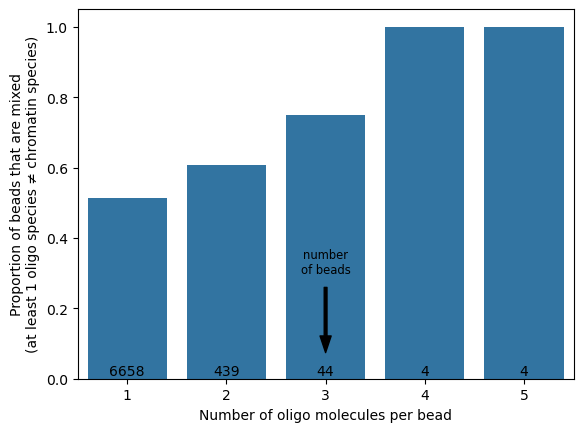

In [328]:
ax = sns.barplot(
    mixing_proportion_by_oligo.loc[mixing_proportion_by_oligo['number of beads'] > 1],
    x='oligos per bead',
    y='proportion mixed'
)
ax.set_xlabel('Number of oligo molecules per bead')
ax.set_ylabel('Proportion of beads that are mixed\n(at least 1 oligo species ≠ chromatin species)')

# add text indicating the number of beads in each category
for _, row in mixing_proportion_by_oligo.loc[mixing_proportion_by_oligo['number of beads'] > 1].iterrows():
    ax.text(
        x=row['oligos per bead'] - 1,
        y=0.01,
        s=int(row['number of beads']),
        ha='center',
        # color='C1'
    )

ax.annotate(
    'number\nof beads',
    xy=(2, 0.05),
    xytext=(2, 0.3),
    arrowprops=dict(facecolor='black', shrink=0.1, width=2, headwidth=8),
    ha='center',
    fontsize='small'
)

ax.figure.savefig(
    os.path.join(DIR_RESULTS, 'proportion of beads that are mixed by oligo molecules per bead.png'),
    dpi=300,
    bbox_inches='tight'
)
ax.figure.show()

#### Mixing analysis of overloaded beads

Idea: If overloaded beads (i.e., beads with both mouse and human chromatin) show similar levels of oligo mixing as these single-chromatin-species beads, then that would be consistent with the hypothesis that these single-chromatin-species beads are in fact just sampling overloaded beads.

In [273]:
mask_overloaded_beads_with_oligo = (df_molecules_per_bead['human_chromatin'] > 0) & \
    (df_molecules_per_bead['mouse_chromatin'] > 0) & \
    (df_molecules_per_bead['oligos per bead'] > 0)

print(
    'Proportion of overloaded oligo-containing beads with only 1 oligo:',
    (mask_overloaded_beads_with_oligo & (df_molecules_per_bead['oligos per bead'] == 1)).sum() / mask_overloaded_beads_with_oligo.sum()
)

Proportion of overloaded oligo-containing beads with only 1 oligo: 0.6955725190839694


In [274]:
print(
    'Proportion of overloaded oligo-containing beads with 1 oligo species:',
    (mask_overloaded_beads_with_oligo & df_molecules_per_bead['human_oligo'].isin([0.0, 1.0])).sum() / mask_overloaded_beads_with_oligo.sum()
)

Proportion of overloaded oligo-containing beads with 1 oligo species: 0.8320610687022901


In [275]:
numerator_mask = mask_overloaded_beads_with_oligo & \
    df_molecules_per_bead['human_oligo'].isin([0.0, 1.0]) & \
    (df_molecules_per_bead['oligos per bead'] > 1)
print(
    'Proportion of overloaded oligo-containing beads with 2+ oligos but only 1 oligo species:',
    numerator_mask.sum() / mask_overloaded_beads_with_oligo.sum()
)

Proportion of overloaded oligo-containing beads with 2+ oligos but only 1 oligo species: 0.1364885496183206


In [276]:
mask = mask_overloaded_beads_with_oligo & (df_molecules_per_bead['oligos per bead'] == 2)
print('Number of overloaded oligo-containing beads with 2 oligos:', mask.sum())
print(
    'Proportion of overloaded oligo-containing beads with 2 oligos but only 1 oligo species:',
    (mask & df_molecules_per_bead['human_oligo'].isin([0.0, 1.0])).sum() / mask.sum()
)
p_human_oligo = (df_molecules_per_bead.loc[mask, 'human_oligo'] * df_molecules_per_bead.loc[mask, 'oligos per bead']).sum() / df_molecules_per_bead.loc[mask, 'oligos per bead'].sum()
simulated_oligo_counts = np.random.default_rng(10).binomial(n=2, p=p_human_oligo, size=(mask.sum(), 1000))
simulated_proportion_beads_1_species = ((simulated_oligo_counts == 0) | (simulated_oligo_counts == 2)).mean(axis=0)
lower = np.percentile(simulated_proportion_beads_1_species, 2.5)
upper = np.percentile(simulated_proportion_beads_1_species, 97.5)
print('Simulated proportion of beads with 2 oligos but only 1 oligo species (95% CI): ({}, {})'.format(lower, upper))

mask = mask & (df_molecules_per_bead['chromatin per bead'] == 2)
print('Number of overloaded oligo-containing beads with 2 chromatin and 2 oligos:', mask.sum())
print(
    'Proportion of overloaded oligo-containing beads with 2 chromatin and 2 oligos but only 1 oligo species:',
    (mask & df_molecules_per_bead['human_oligo'].isin([0.0, 1.0])).sum() / mask.sum()
)
p_human_oligo = (df_molecules_per_bead.loc[mask, 'human_oligo'] * df_molecules_per_bead.loc[mask, 'oligos per bead']).sum() / df_molecules_per_bead.loc[mask, 'oligos per bead'].sum()
simulated_oligo_counts = np.random.default_rng(10).binomial(n=2, p=p_human_oligo, size=(mask.sum(), 1000))
simulated_proportion_beads_1_species = ((simulated_oligo_counts == 0) | (simulated_oligo_counts == 2)).mean(axis=0)
lower = np.percentile(simulated_proportion_beads_1_species, 2.5)
upper = np.percentile(simulated_proportion_beads_1_species, 97.5)
print('Simulated proportion of beads with 2 oligos but only 1 oligo species (95% CI): ({}, {})'.format(lower, upper))

mask = mask_overloaded_beads_with_oligo & (df_molecules_per_bead['oligos per bead'] == 2) & (df_molecules_per_bead['chromatin per bead'] < 5)
print('Number of overloaded oligo-containing beads with < 5 chromatin and 2 oligos:', mask.sum())
print(
    'Proportion of overloaded oligo-containing beads with < 5 chromatin and 2 oligos but only 1 oligo species:',
    (mask & df_molecules_per_bead['human_oligo'].isin([0.0, 1.0])).sum() / mask.sum()
)
p_human_oligo = (df_molecules_per_bead.loc[mask, 'human_oligo'] * df_molecules_per_bead.loc[mask, 'oligos per bead']).sum() / df_molecules_per_bead.loc[mask, 'oligos per bead'].sum()
simulated_oligo_counts = np.random.default_rng(10).binomial(n=2, p=p_human_oligo, size=(mask.sum(), 1000))
simulated_proportion_beads_1_species = ((simulated_oligo_counts == 0) | (simulated_oligo_counts == 2)).mean(axis=0)
lower = np.percentile(simulated_proportion_beads_1_species, 2.5)
upper = np.percentile(simulated_proportion_beads_1_species, 97.5)
print('Simulated proportion of beads with 2 oligos but only 1 oligo species (95% CI): ({}, {})'.format(lower, upper))

Number of overloaded oligo-containing beads with 2 oligos: 592
Proportion of overloaded oligo-containing beads with 2 oligos but only 1 oligo species: 0.6165540540540541
Simulated proportion of beads with 2 oligos but only 1 oligo species (95% CI): (0.4780405405405405, 0.5591216216216216)
Number of overloaded oligo-containing beads with 2 chromatin and 2 oligos: 85
Proportion of overloaded oligo-containing beads with 2 chromatin and 2 oligos but only 1 oligo species: 0.8235294117647058
Simulated proportion of beads with 2 oligos but only 1 oligo species (95% CI): (0.3997058823529412, 0.6120588235294115)
Number of overloaded oligo-containing beads with < 5 chromatin and 2 oligos: 189
Proportion of overloaded oligo-containing beads with < 5 chromatin and 2 oligos but only 1 oligo species: 0.7248677248677249
Simulated proportion of beads with 2 oligos but only 1 oligo species (95% CI): (0.4444444444444444, 0.5873015873015873)


In [281]:
mask = mask_overloaded_beads_with_oligo & (df_molecules_per_bead['oligos per bead'] == 3)
print('Number of overloaded oligo-containing beads with 3 oligos:', mask.sum())
print(
    'Proportion of overloaded oligo-containing beads with 3 oligos but only 1 oligo species:',
    (mask & df_molecules_per_bead['human_oligo'].isin([0.0, 1.0])).sum() / mask.sum()
)
p_human_oligo = (df_molecules_per_bead.loc[mask, 'human_oligo'] * df_molecules_per_bead.loc[mask, 'oligos per bead']).sum() / df_molecules_per_bead.loc[mask, 'oligos per bead'].sum()
simulated_oligo_counts = np.random.default_rng(10).binomial(n=3, p=p_human_oligo, size=(mask.sum(), 1000))
simulated_proportion_beads_1_species = ((simulated_oligo_counts == 0) | (simulated_oligo_counts == 3)).mean(axis=0)
lower = np.percentile(simulated_proportion_beads_1_species, 2.5)
upper = np.percentile(simulated_proportion_beads_1_species, 97.5)
print('Simulated proportion of beads with 3 oligos but only 1 oligo species (95% CI): ({}, {})'.format(lower, upper))

mask = mask & (df_molecules_per_bead['chromatin per bead'] < 5)
print('Number of overloaded oligo-containing beads with < 5 chromatin and 3 oligos:', mask.sum())
print(
    'Proportion of overloaded oligo-containing beads with < 5 chromatin and 3 oligos but only 1 oligo species:',
    (mask & df_molecules_per_bead['human_oligo'].isin([0.0, 1.0])).sum() / mask.sum()
)
p_human_oligo = (df_molecules_per_bead.loc[mask, 'human_oligo'] * df_molecules_per_bead.loc[mask, 'oligos per bead']).sum() / df_molecules_per_bead.loc[mask, 'oligos per bead'].sum()
simulated_oligo_counts = np.random.default_rng(10).binomial(n=3, p=p_human_oligo, size=(mask.sum(), 1000))
simulated_proportion_beads_1_species = ((simulated_oligo_counts == 0) | (simulated_oligo_counts == 3)).mean(axis=0)
lower = np.percentile(simulated_proportion_beads_1_species, 2.5)
upper = np.percentile(simulated_proportion_beads_1_species, 97.5)
print('Simulated proportion of beads with 3 oligos but only 1 oligo species (95% CI): ({}, {})'.format(lower, upper))

Number of overloaded oligo-containing beads with 3 oligos: 188
Proportion of overloaded oligo-containing beads with 3 oligos but only 1 oligo species: 0.2872340425531915
Simulated proportion of beads with 3 oligos but only 1 oligo species (95% CI): (0.2127659574468085, 0.3404255319148936)
Number of overloaded oligo-containing beads with < 5 chromatin and 3 oligos: 20
Proportion of overloaded oligo-containing beads with < 5 chromatin and 3 oligos but only 1 oligo species: 0.5
Simulated proportion of beads with 3 oligos but only 1 oligo species (95% CI): (0.1, 0.5)


In [282]:
mask_underloaded_beads_with_oligo = df_molecules_per_bead['human_chromatin'].isin([0.0, 1.0]) & \
    (df_molecules_per_bead['chromatin per bead'] > 0) & \
    (df_molecules_per_bead['oligos per bead'] > 0)

mask = mask_underloaded_beads_with_oligo & (df_molecules_per_bead['oligos per bead'] == 2)
print('Number of single-chromatin-species oligo-containing beads with 2 oligos:', mask.sum())
print(
    'Proportion of single-chromatin-species oligo-containing beads with 2 oligos but only 1 oligo species:',
    (mask & df_molecules_per_bead['human_oligo'].isin([0.0, 1.0])).sum() / mask.sum()
)
p_human_oligo = (df_molecules_per_bead.loc[mask, 'human_oligo'] * df_molecules_per_bead.loc[mask, 'oligos per bead']).sum() / df_molecules_per_bead.loc[mask, 'oligos per bead'].sum()
simulated_oligo_counts = np.random.default_rng(10).binomial(n=2, p=p_human_oligo, size=(mask.sum(), 1000))
simulated_proportion_beads_1_species = ((simulated_oligo_counts == 0) | (simulated_oligo_counts == 2)).mean(axis=0)
lower = np.percentile(simulated_proportion_beads_1_species, 2.5)
upper = np.percentile(simulated_proportion_beads_1_species, 97.5)
print('Simulated proportion of beads with 2 oligos but only 1 oligo species (95% CI): ({}, {})'.format(lower, upper))

mask = mask & (df_molecules_per_bead['chromatin per bead'] == 2)
print('Number of single-chromatin-species oligo-containing beads with 2 chromatin and 2 oligos:', mask.sum())
print(
    'Proportion of single-chromatin-species oligo-containing beads with 2 chromatin and 2 oligos but only 1 oligo species:',
    (mask & df_molecules_per_bead['human_oligo'].isin([0.0, 1.0])).sum() / mask.sum()
)
p_human_oligo = (df_molecules_per_bead.loc[mask, 'human_oligo'] * df_molecules_per_bead.loc[mask, 'oligos per bead']).sum() / df_molecules_per_bead.loc[mask, 'oligos per bead'].sum()
simulated_oligo_counts = np.random.default_rng(10).binomial(n=2, p=p_human_oligo, size=(mask.sum(), 1000))
simulated_proportion_beads_1_species = ((simulated_oligo_counts == 0) | (simulated_oligo_counts == 2)).mean(axis=0)
lower = np.percentile(simulated_proportion_beads_1_species, 2.5)
upper = np.percentile(simulated_proportion_beads_1_species, 97.5)
print('Simulated proportion of beads with 2 oligos but only 1 oligo species (95% CI): ({}, {})'.format(lower, upper))

Number of single-chromatin-species oligo-containing beads with 2 oligos: 439
Proportion of single-chromatin-species oligo-containing beads with 2 oligos but only 1 oligo species: 0.826879271070615
Simulated proportion of beads with 2 oligos but only 1 oligo species (95% CI): (0.46235763097949883, 0.5558086560364465)
Number of single-chromatin-species oligo-containing beads with 2 chromatin and 2 oligos: 70
Proportion of single-chromatin-species oligo-containing beads with 2 chromatin and 2 oligos but only 1 oligo species: 0.7428571428571429
Simulated proportion of beads with 2 oligos but only 1 oligo species (95% CI): (0.4, 0.6428571428571429)


In [279]:
mask_underloaded_beads_with_oligo = df_molecules_per_bead['human_chromatin'].isin([0.0, 1.0]) & \
    (df_molecules_per_bead['chromatin per bead'] > 0) & \
    (df_molecules_per_bead['oligos per bead'] > 0)
mask = mask_underloaded_beads_with_oligo & (df_molecules_per_bead['oligos per bead'] == 3)
print(
    'Proportion of single-chromatin-species oligo-containing beads with 3 oligos but only 1 oligo species:',
    (mask & df_molecules_per_bead['human_oligo'].isin([0.0, 1.0])).sum() / mask.sum()
)
p_human_oligo = (df_molecules_per_bead.loc[mask, 'human_oligo'] * df_molecules_per_bead.loc[mask, 'oligos per bead']).sum() / df_molecules_per_bead.loc[mask, 'oligos per bead'].sum()
simulated_oligo_counts = np.random.default_rng(10).binomial(n=3, p=p_human_oligo, size=(mask.sum(), 1000))
simulated_proportion_beads_1_species = ((simulated_oligo_counts == 0) | (simulated_oligo_counts == 3)).mean(axis=0)
lower = np.percentile(simulated_proportion_beads_1_species, 2.5)
upper = np.percentile(simulated_proportion_beads_1_species, 97.5)
print('Simulated proportion of beads with 3 oligos but only 1 oligo species (95% CI): ({}, {})'.format(lower, upper))

Proportion of single-chromatin-species oligo-containing beads with 3 oligos but only 1 oligo species: 0.4318181818181818
Simulated proportion of beads with 3 oligos but only 1 oligo species (95% CI): (0.13636363636363635, 0.38636363636363635)


Interpretation
- In aggregate, chromatin-overloaded beads show uniformly random distribution of oligo species. However, there are subpopulations of these beads with biased distributions: for example, the proportion of overloaded (i.e., mixed chromatin species) oligo-containing beads with 2 chromatin and 2 oligos but only 1 oligo species is significantly higher than expected by chance.
  - This probably reflects the 2:1 oligo-to-streptavidin ratio.
- Not sure how to interpret results for similar beads where the chromatin is from the same species (single-chromatin-species oligo-containing beads with 2 chromatin and 2 oligos): the proportion of those beads with only 1 oligo species is also higher than expected by chance. Should this proportion be higher or lower than for overloaded beads?

### Sensitivity

#### Basic numbers

Oligo-to-chromatin ratio on beads

In [283]:
df_molecules_per_bead['oligos per bead'].mean() / df_molecules_per_bead['chromatin per bead'].mean()

0.06349689909442768

Proportion of chromatin-containing beads with any oligo

In [284]:
numerator = (df_molecules_per_bead['chromatin per bead'].astype(bool) & df_molecules_per_bead['oligos per bead'].astype(bool)).sum()
denominator = (df_molecules_per_bead['chromatin per bead'].astype(bool)).sum()
print(
    'Proportion of chromatin-containing beads with any oligo: '
    f'{numerator} / {denominator} = {numerator / denominator:.3%}'
)

Proportion of chromatin-containing beads with any oligo: 10425 / 566613 = 1.840%


Proportion of bead-barcoded chromatin reads associated with chromatin beads with any oligo

In [285]:
numerator = df_molecules_per_bead.loc[
    (df_molecules_per_bead['chromatin per bead'] > 0) & (df_molecules_per_bead['oligos per bead'] > 0),
    'chromatin per bead'
].sum()
denominator = df_molecules_per_bead['chromatin per bead'].sum()
print(
    'Proportion of bead-barcoded chromatin reads associated with chromatin beads with any oligo: '
    f'{numerator} / {denominator} = {numerator / denominator:.3%}'
)

Proportion of bead-barcoded chromatin reads associated with chromatin beads with any oligo: 288855 / 945369 = 30.555%


Proportion of bead-barcoded chromatin reads that are uniquely cell-resolvable

In [286]:
n_beads = 0
n_chromatin = 0
for bead in beads.values():
    if bead.proper_pairing() == ('unique', 'unique') and not pd.isna(bead.status()[1][0][1]):
        n_beads += 1
        n_chromatin += len(bead.chromatin)
print(
    'Proportion of chromatin-containing beads that are cell-resolvable: '
     f"{n_beads} / {len(df_chromatin['bead'].unique())} = {n_beads / len(df_chromatin['bead'].unique()):.3%}"
)
print(
    'Proportion of bead-barcoded chromatin reads that are cell-resolvable: '
     f"{n_chromatin} / {len(df_chromatin)} = {n_chromatin / len(df_chromatin):.3%}"
)

Proportion of chromatin-containing beads that are cell-resolvable: 641 / 566613 = 0.113%
Proportion of bead-barcoded chromatin reads that are cell-resolvable: 776 / 945369 = 0.082%


#### Motif analysis of unmixed chromatin

Do the unmixed chromatin reads retain CTCF motifs? (i.e., does NHS-biotin labeling and oligo conjugation preclude antibody recognition?)

In [287]:
unmixed_chromatin = set()
for bead in beads.values():
    if bead.proper_pairing() == ('unique', 'unique'):
        unmixed_chromatin |= bead.chromatin
unmixed_chromatin = pd.DataFrame(unmixed_chromatin, columns=['chr', 'start', 'end'])

In [288]:
path_bed_human = os.path.join(DIR_PROC, 'unmixed_chromatin_human.bed')
path_bed_mouse = os.path.join(DIR_PROC, 'unmixed_chromatin_mouse.bed')
(
    unmixed_chromatin
    .loc[unmixed_chromatin['chr'].str.startswith('h_')]
    .pipe(lambda df: df.assign(chr=df['chr'].str.replace('h_', '')))
    .sort_values(['chr', 'start', 'end'])
    .to_csv(path_bed_human, sep='\t', index=False, header=False)
)
print('Number of unmixed human chromatin reads:', unmixed_chromatin['chr'].str.startswith('h_').sum())
(
    unmixed_chromatin
    .loc[unmixed_chromatin['chr'].str.startswith('m_')]
    .pipe(lambda df: df.assign(chr=df['chr'].str.replace('m_', '')))
    .sort_values(['chr', 'start', 'end'])
    .to_csv(path_bed_mouse, sep='\t', index=False, header=False)
)
print('Number of unmixed mouse chromatin reads:', unmixed_chromatin['chr'].str.startswith('m_').sum())

Number of unmixed human chromatin reads: 1686
Number of unmixed mouse chromatin reads: 2257


In [289]:
DIR_ANALYSIS = os.path.join(DIR_RESULTS, 'motif_analysis')
os.makedirs(DIR_ANALYSIS, exist_ok=True)

In [290]:
path_sbatch_homer = os.path.join(DIR_PROJECT, 'scripts', '20240625', 'homer_motif_analysis.sbatch')
for species in ('human', 'mouse'):
    path_bed = path_bed_human if species == 'human' else path_bed_mouse
    genome = 'hg38' if species == 'human' else 'mm10'
    for size in (100, 'given'):
        dir_analysis_current = os.path.join(DIR_ANALYSIS, f'unmixed_{species}_size_{size}')
        if not os.path.exists(dir_analysis_current) or reprocess:
            os.makedirs(dir_analysis_current, exist_ok=True)
            path_log = os.path.join(dir_analysis_current, 'homer.log')
            path_err = os.path.join(dir_analysis_current, 'slurm.err')
            path_out = os.path.join(dir_analysis_current, 'slurm.out')
            !sbatch --chdir="{dir_analysis_current}" --output="{path_out}" --error="{path_err}" \
                    --export=ALL,PATH_BED="{path_bed}",GENOME="{genome}",DIR_ANALYSIS="{dir_analysis_current}",SIZE="{size}",PATH_LOG="{path_log}" \
                    "{path_sbatch_homer}"

Submitted batch job 42646944
Submitted batch job 42646945
Submitted batch job 42646946
Submitted batch job 42646947


# Remove unnecessary files

In [291]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

# reads combined from different sequencing runs
rm "${DIR_PROC}/R1.fastq.gz" "${DIR_PROC}/R2.fastq.gz"

# original (unfiltered) Bowtie2 alignment of genomic DNA
rm "${DIR_PROC}/genomic.bam"

# name-sorted filtered genomic DNA alignment file
rm "${DIR_PROC}/genomic_filtered.name_sorted.bam"

# split human and mouse BAM files, unsorted
rm "${DIR_PROC}/genomic_dedup_human.bam" "${DIR_PROC}/genomic_dedup_mouse.bam"